In [1]:
#### importing original data ####
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import seaborn as sns 
import re 
%matplotlib inline
import glob
from tqdm import tqdm


In [2]:
metadata = pd.read_csv('/scratch/gh8sj/brown_nsclc/data/metadata/Vectra_Cohort_Data_metadata.csv')

In [3]:
df = pd.read_csv("/scratch/gh8sj/brown_nsclc/data/neighbor_data/tumor_stroma/tumor_stroma_merged_neighbor_data.csv", index_col=0)


KeyboardInterrupt



In [ ]:
df

In [ ]:
def process_string(s):
    parts = s.split('-')
    if len(parts) == 2 and parts[1].isdigit():
        return f"{parts[0].replace('MAD', '')}-{parts[1][-3:]}"
    else:
        return s



    


metadata['patient'] = metadata['Case Code'].apply(process_string)
#metadata['patient'] = metadata['patient'].str.replace('MAD', '')


In [ ]:
vectra_patients = list(df.PatientID.unique())
cohort_patients = list(metadata.patient.unique())
print(len(vectra_patients))

# I will change this question to greater than or less than 3 years

## conversions

In [ ]:
full_df = pd.read_csv('/scratch/gh8sj/brown_nsclc/data/processed_data/dfs_3_years_labeled_with_neighbors.csv', index_col = 0)

In [ ]:
list(full_df.columns)

In [ ]:
len(full_df.loc[full_df['survival group'] == '> 3 years']['ImageLocation'].unique())

## normalize by dividing the neighbor columns by the number of center cells in that ROI to get an average number of neighbors in that ORI


In [ ]:
#this distinguishes by center cell locatin
#def flatten_list(nested_list):
#    flat_list = []
#    for item in nested_list:
#        if isinstance(item, list):
#            flat_list.extend(flatten_list(item))
#        else:
#            flat_list.append(item)
#    return flat_list

def flatten_list(nested_list):
    flat_list = []
    for item in nested_list:
        if isinstance(item, list):
            flat_list.extend(item)
        else:
            flat_list.append(item)
    return flat_list

full_df = full_df.loc[full_df['ClassifierLabel'] != 'glass']

cell_types = ['PanCyto+MHCI+', 'PanCyto+MHCI-',
       'CD3+CD8+IFNy+', 'CD3+CD8+IFNy-', 'CD3+CD8-IFNy+', 'CD3+CD8-IFNy-',
       'CD56+CD3-IFNy+', 'CD56+CD3-IFNy-']
cancer_cells = ['PanCyto+MHCI+', 'PanCyto+MHCI-']

cd8s =['CD3+CD8+IFNy+', 'CD3+CD8+IFNy-']
cd3s = ['CD3+CD8-IFNy+', 'CD3+CD8-IFNy-']
NK  =  ['CD56+CD3-IFNy+', 'CD56+CD3-IFNy-']
tumor = ['PanCyto+MHCI+', 'PanCyto+MHCI-' ]
neighbors = ['CD3+CD8+IFNy+ Tumor Neighbors_30um','CD3+CD8+IFNy+ Stroma Neighbors_30um','CD3+CD8+IFNy- Tumor Neighbors_30um','CD3+CD8+IFNy- Stroma Neighbors_30um',
             'CD3+CD8-IFNy+ Tumor Neighbors_30um','CD3+CD8-IFNy+ Stroma Neighbors_30um','CD3+CD8-IFNy- Tumor Neighbors_30um','CD3+CD8-IFNy- Stroma Neighbors_30um',
             'CD56+CD3-IFNy+ Tumor Neighbors_30um','CD56+CD3-IFNy+ Stroma Neighbors_30um','CD56+CD3-IFNy- Tumor Neighbors_30um','CD56+CD3-IFNy- Stroma Neighbors_30um',
             'PanCyto+MHCI+ Tumor Neighbors_30um','PanCyto+MHCI+ Stroma Neighbors_30um','PanCyto+MHCI- Tumor Neighbors_30um','PanCyto+MHCI- Stroma Neighbors_30um',  
             'CD3+CD8+IFNy+ Tumor Neighbors_200um','CD3+CD8+IFNy+ Stroma Neighbors_200um','CD3+CD8+IFNy- Tumor Neighbors_200um','CD3+CD8+IFNy- Stroma Neighbors_200um',
             'CD3+CD8-IFNy+ Tumor Neighbors_200um','CD3+CD8-IFNy+ Stroma Neighbors_200um','CD3+CD8-IFNy- Tumor Neighbors_200um','CD3+CD8-IFNy- Stroma Neighbors_200um',
             'CD56+CD3-IFNy+ Tumor Neighbors_200um','CD56+CD3-IFNy+ Stroma Neighbors_200um','CD56+CD3-IFNy- Tumor Neighbors_200um','CD56+CD3-IFNy- Stroma Neighbors_200um',
             'PanCyto+MHCI+ Tumor Neighbors_200um','PanCyto+MHCI+ Stroma Neighbors_200um','PanCyto+MHCI- Tumor Neighbors_200um','PanCyto+MHCI- Stroma Neighbors_200um']

locations = list(full_df['ClassifierLabel'].unique())
results_dict = {}
unique_patients = full_df['ROI'].unique()
for patient_num in tqdm(range(len(unique_patients))):
    patient = unique_patients[patient_num]
    patient_data = full_df[full_df['ROI'] == patient]
    patient_stats = []
    for location in locations:    
        if location in patient_data['ClassifierLabel'].unique():
            #print(location)
            location_data  = patient_data.loc[patient_data['ClassifierLabel'] == location]
  
            location_stats = []
            # Subset the dataframe for the current patient

            patient_code = list(location_data.PatientID.unique())[0]
            ###
            cd8s = location_data.loc[location_data['CD3+CD8+'] == 1.0]
            if len(cd8s != 0):
                cd8_ifng_pos = sum(cd8s['CD3+CD8+IFNy+'] == 1.0)/(sum(cd8s['CD3+CD8+IFNy+'] == 1.0)+sum(cd8s['CD3+CD8+IFNy-'] == 1.0))
            else:
                cd8_ifng_pos = 0

            cd8s_act = location_data.loc[location_data['CD3+CD8+IFNy+'] == 1.0]
            if len(cd8s_act != 0):
                cd8_act_neighbor_counts = (cd8s_act[neighbors].sum(axis=0).values/len(cd8s_act)).tolist()
            else:
                cd8_act_neighbor_counts = np.zeros(len(neighbors)).tolist()

            cd8s_inact = location_data.loc[location_data['CD3+CD8+IFNy-'] == 1.0]
            if len(cd8s_inact != 0):
                cd8_inact_neighbor_counts = (cd8s_inact[neighbors].sum(axis=0).values/len(cd8s_inact)).tolist()
            else:
                cd8_inact_neighbor_counts = np.zeros(len(neighbors)).tolist()
            ###    
            cd3s = location_data.loc[location_data['CD3+CD8-'] == 1.0]
            if len(cd3s) != 0:
                cd3_ifng_pos = sum(cd3s['CD3+CD8-IFNy+'] == 1.0)/(sum(cd3s['CD3+CD8-IFNy+'] == 1.0)+sum(cd3s['CD3+CD8-IFNy-'] == 1.0))
            else:
                cd3_ifng_pos = 0

            cd3s_act = location_data.loc[location_data['CD3+CD8-IFNy+'] == 1.0]
            if len(cd3s_act) != 0:
                cd3_act_neighbor_counts = (cd3s_act[neighbors].sum(axis = 0).values/len(cd3s_act)).tolist()
            else:
                cd3_act_neighbor_counts = np.zeros(len(neighbors)).tolist()  

            cd3s_inact = location_data.loc[location_data['CD3+CD8-IFNy-'] == 1.0]
            if len(cd3s_act) != 0:
                cd3_inact_neighbor_counts = (cd3s_inact[neighbors].sum(axis = 0).values/len(cd3s_inact)).tolist()
            else:
                cd3_inact_neighbor_counts = np.zeros(len(neighbors)).tolist() 

            nks = location_data.loc[location_data['CD56+CD3-'] == 1.0]
            if len(nks) != 0:
                nk_ifng_pos = sum(nks['CD56+CD3-IFNy+'] == 1.0)/(sum(nks['CD56+CD3-IFNy+'] == 1.0)+sum(nks['CD56+CD3-IFNy-'] == 1.0))
            else:
                nk_ifng_pos = 0

            nks_act = location_data.loc[location_data['CD56+CD3-IFNy+'] == 1.0]
            if len(nks_act) != 0:
                nk_act_neighbor_counts = (nks_act[neighbors].sum(axis = 0).values/len(nks_act)).tolist()
            else:
                nk_act_neighbor_counts = np.zeros(len(neighbors)).tolist()      

            nks_inact = location_data.loc[location_data['CD56+CD3-IFNy-'] == 1.0]
            if len(nks_inact) != 0:
                nk_inact_neighbor_counts = (nks_inact[neighbors].sum(axis = 0).values/len(nks_inact)).tolist()
            else:
                nk_inact_neighbor_counts = np.zeros(len(neighbors)).tolist()            

            tumor = location_data.loc[(location_data['PanCyto+MHCI+'] == 1.0)| (location_data['PanCyto+MHCI-'] == 1.0)]
            if len(tumor) != 0:
                tumor_mhci_pos = sum(tumor['PanCyto+MHCI+'] == 1.0)/(sum(tumor['PanCyto+MHCI+'] == 1.0)+sum(tumor['PanCyto+MHCI-'] == 1.0))
            else:
                tumor_mhci_pos = 0

            tumor_mhc1p = location_data.loc[(location_data['PanCyto+MHCI+'] == 1.0)]
            if len(tumor_mhc1p) != 0:
                tumor_mhc1p_neighbor_counts = (tumor_mhc1p[neighbors].sum(axis = 0).values/len(tumor_mhc1p)).tolist()
            else:
                tumor_mhc1p_neighbor_counts = np.zeros(len(neighbors)).tolist()

            tumor_mhc1n = location_data.loc[(location_data['PanCyto+MHCI-'] == 1.0)]
            if len(tumor_mhc1n) != 0:
                tumor_mhc1n_neighbor_counts = (tumor_mhc1n[neighbors].sum(axis = 0).values/len(tumor_mhc1n)).tolist()
            else:
                tumor_mhc1n_neighbor_counts = np.zeros(len(neighbors)).tolist()  
                
            location_stats.extend([location, cd8_ifng_pos, len(cd8s), cd3_ifng_pos, len(cd3s), nk_ifng_pos, len(nks), tumor_mhci_pos, len(tumor)])
            full_location_stats = location_stats + cd8_act_neighbor_counts + cd8_inact_neighbor_counts + cd3_act_neighbor_counts + cd3_inact_neighbor_counts + nk_act_neighbor_counts + nk_inact_neighbor_counts + tumor_mhc1p_neighbor_counts+ tumor_mhc1n_neighbor_counts
        patient_stats.extend([full_location_stats])
    group = location_data['survival group'].value_counts().index[0]
    flattened_patient_stats = [item if not isinstance(item, list) else [subitem for subitem in item] for sublist in patient_stats for item in sublist]
    flattened_patient_stats.extend([group, patient_code])
    #patients_stats = flatten_list(patient_stats)
    #patient_stats.extend([cd8_ifng_pos, len(cd8s), cd3_ifng_pos, len(cd3s), nk_ifng_pos, len(nks), tumor_mhci_pos, len(tumor), group, patient_code])
            #patient_stats.extend([cd8_ifng_pos, cd8_neighbor_counts, cd3_ifng_pos, cd3_neighbor_counts,nk_ifng_pos, nk_neighbor_counts, tumor_mhci_pos, tumor_neighbor_counts, mutation])
    results_dict[patient] = flattened_patient_stats

In [ ]:
#for distinguishing center cells
def flatten_list(nested_list):
    flat_list = []
    for item in nested_list:
        if isinstance(item, list):
            flat_list.extend(flatten_list(item))
        else:
            flat_list.append(item)
    return flat_list

index_list = []
index_list.append(['Location', 'CD8 IFNg+ %' ,'Number of CD8s','CD3 IFNg+ %', 'Number of CD3s','NK IFNg+ %',  'Number of NKs', 'Tumor cell MHC1+ %', 'Number of Tumor cells', ['CD8 act ' + value for value in neighbors],['CD8 inact ' + value for value in neighbors],['CD3 act ' + value for value in neighbors],['CD3 inact ' + value for value in neighbors], ['NK act ' + value for value in neighbors], ['NK inact ' + value for value in neighbors],['MHC1+ Tumor ' + value for value in neighbors],['MHC1- Tumor ' + value for value in neighbors]])
tumor_prefixed = [['tumor ' + item if not isinstance(item, list) else ['tumor ' + subitem for subitem in item] for item in sublist] for sublist in index_list]
stroma_prefixed = [['stroma ' + item if not isinstance(item, list) else ['stroma ' + subitem for subitem in item] for item in sublist] for sublist in index_list]
doubled_index_list = tumor_prefixed + stroma_prefixed
new_index = [item for sublist in doubled_index_list for item in sublist]
flat_list = flatten_list(new_index)
flat_list.extend(['survival group', 'patient'])
results_df = pd.DataFrame(results_dict).T
results_df.columns= flat_list

# now remove the location columns used to track the counting
columns_to_remove = [col for col in results_df.columns if col.endswith('Location')]
results_df = results_df.drop(columns=columns_to_remove)
results_df
# add these back


In [ ]:
# center distinction
# loops through and counts the number of each cell type in each patient -> this information will be used to normalize based on the square root of the neighbor cell

cell_types = ['PanCyto-CD56-', 'PanCyto+MHCI+', 'PanCyto+MHCI-',
       'CD3+CD8+IFNy+', 'CD3+CD8+IFNy-', 'CD3+CD8-IFNy+', 'CD3+CD8-IFNy-',
       'CD56+CD3-IFNy+', 'CD56+CD3-IFNy-']

locations = list(full_df['ClassifierLabel'].unique())
#unique_patients = full_df['ROI'].unique()
patient_cell_type_counts = {}
for patient_num in tqdm(range(len(unique_patients))):
    patient = unique_patients[patient_num]
    patient_data = full_df[full_df['ROI'] == patient]
    location_cell_type_counts = {}
    for location in locations:
        if location == 'tumor':
            location_cap = 'Tumor'
        elif location == 'stroma':
            location_cap = 'Stroma'
        location_data  = patient_data.loc[patient_data['ClassifierLabel'] == location]
        cell_type_counts = {}
        for i in cell_types:
            label = i + ' ' + location_cap
            #print(label)
            cell_type_counts[label] = sum(location_data[i])
            location_cell_type_counts[location] = cell_type_counts
        patient_cell_type_counts[patient] = location_cell_type_counts
        
for key, inner_dict in patient_cell_type_counts.items():
    flattened_data[key] = {}
    for inner_key, inner_value in inner_dict.items():
        flattened_data[key].update(inner_value)
patient_cell_counts_df= pd.DataFrame(flattened_data).T

In [ ]:
patient_cell_counts_df

In [ ]:
# combine into one df
full_results_df = pd.concat([results_df, patient_cell_counts_df], axis =1 )


In [437]:
# for distinguishing center cells
# this normalizes by the square root of the neighbor cells
# need to fix it so it divdes by the number of cells in the location too

cell_types = ['PanCyto-CD56- Tumor','PanCyto+MHCI+ Tumor','PanCyto+MHCI- Tumor','CD3+CD8+IFNy+ Tumor','CD3+CD8+IFNy- Tumor','CD3+CD8-IFNy+ Tumor','CD3+CD8-IFNy- Tumor','CD56+CD3-IFNy+ Tumor','CD56+CD3-IFNy- Tumor','PanCyto-CD56- Stroma','PanCyto+MHCI+ Stroma','PanCyto+MHCI- Stroma','CD3+CD8+IFNy+ Stroma','CD3+CD8+IFNy- Stroma','CD3+CD8-IFNy+ Stroma','CD3+CD8-IFNy- Stroma','CD56+CD3-IFNy+ Stroma','CD56+CD3-IFNy- Stroma']
columns_to_ignore_short = ['CD8 IFNg+ %','Number of CD8s','CD3 IFNg+ %','Number of CD3s','NK IFNg+ %','Number of NKs','Tumor cell MHC1+ %','Number of Tumor cells','PanCyto-CD56-','PanCyto+MHCI+','PanCyto+MHCI-','CD3+CD8+IFNy+','CD3+CD8+IFNy-','CD3+CD8-IFNy+','CD3+CD8-IFNy-','CD56+CD3-IFNy+','CD56+CD3-IFNy-','PanCyto-CD56-','PanCyto+MHCI+','PanCyto+MHCI-','CD3+CD8+IFNy+','CD3+CD8+IFNy-','CD3+CD8-IFNy+','CD3+CD8-IFNy-','CD56+CD3-IFNy+','CD56+CD3-IFNy-']

#tumor_list = [item + ' Tumor' for item in columns_to_ignore_short]
#stroma_list = [item + ' Stroma' for item in columns_to_ignore_short]

tumor_list = ['tumor ' + item if isinstance(item, str) else ['tumor ' + sub_item for sub_item in item] for item in columns_to_ignore_short]
stroma_list = ['stroma ' + item if isinstance(item, str) else ['stroma ' + sub_item for sub_item in item] for item in columns_to_ignore_short]

columns_to_ignore = tumor_list + stroma_list
columns_to_ignore.extend(['survival group','patient'])
count_cols = ['PanCyto-CD56- Tumor','PanCyto+MHCI+ Tumor','PanCyto+MHCI- Tumor','CD3+CD8+IFNy+ Tumor','CD3+CD8+IFNy- Tumor','CD3+CD8-IFNy+ Tumor','CD3+CD8-IFNy- Tumor','CD56+CD3-IFNy+ Tumor','CD56+CD3-IFNy- Tumor','PanCyto-CD56- Stroma','PanCyto+MHCI+ Stroma','PanCyto+MHCI- Stroma','CD3+CD8+IFNy+ Stroma','CD3+CD8+IFNy- Stroma','CD3+CD8-IFNy+ Stroma','CD3+CD8-IFNy- Stroma','CD56+CD3-IFNy+ Stroma','CD56+CD3-IFNy- Stroma']
# count_cols = ['tumor PanCyto-CD56-','tumor PanCyto+MHCI+','tumor PanCyto+MHCI-','tumor CD3+CD8+IFNy+','tumor CD3+CD8+IFNy-','tumor CD3+CD8-IFNy+','tumor CD3+CD8-IFNy-','tumor CD56+CD3-IFNy+','tumor CD56+CD3-IFNy-','stroma PanCyto-CD56-','stroma PanCyto+MHCI+','stroma PanCyto+MHCI-','stroma CD3+CD8+IFNy+','stroma CD3+CD8+IFNy-','stroma CD3+CD8-IFNy+','stroma CD3+CD8-IFNy-','stroma CD56+CD3-IFNy+','stroma CD56+CD3-IFNy-']
for patient_num in tqdm(range(len(full_results_df.index))):
    patient = full_results_df.index[patient_num]
    for col in full_results_df:
        if col not in columns_to_ignore:
            for cell_type in count_cols:
                if full_results_df.loc[patient,cell_type] != 0: # make sure we aren't dividing by zero
                    #print(cell_type, '     ', col) # used for verifying things are working as expected
                    if str(cell_type) in str(col):
                        # print('\n') # used for verifying things are working as expected
                        full_results_df.loc[patient,col] = full_results_df.loc[patient,col]/ np.sqrt(full_results_df.loc[patient,cell_type]) # divides each column by the neighbor cell counts for that cell type
                else:
                     if str(cell_type) in str(col):
                        # print('\n') # used for verifying things are working as expected
                        full_results_df.loc[patient,col] = 0 # if value is zero before, set value to zero
#doubled_index_list
full_results_df.iloc[:5,40:50]

100%|██████████| 389/389 [01:29<00:00,  4.35it/s]


tumor CD8 inact CD3+CD8+IFNy+ Tumor Neighbors_30um  \
17-199_[43424,7543]                                                   0   
17-199_[43424,9043]                                                   0   
17-199_[44446,10543]                                                  0   
17-199_[44675,12043]                                                  0   
17-199_[45431,7543]                                                   0   

                     tumor CD8 inact CD3+CD8+IFNy+ Stroma Neighbors_30um  \
17-199_[43424,7543]                                                   0    
17-199_[43424,9043]                                                   0    
17-199_[44446,10543]                                                  0    
17-199_[44675,12043]                                                  0    
17-199_[45431,7543]                                                   0    

                     tumor CD8 inact CD3+CD8+IFNy- Tumor Neighbors_30um  \
17-199_[43424,7543]                                            0.217119   
17-199_[43424,9043]                                            0.091196   
17-199_[44446,10543]                                           0.033589   
17-199_[44675,12043]                                           0.055276   
17-199_[45431,7543]                                            0.125743   

                     tumor CD8 inact CD3+CD8+IFNy- Stroma Neighbors_30um  \
17-199_[43424,7543]                                            0.005332    
17-199_[43424,9043]                                            0.005333    
17-199_[44446,10543]                                           0.005605    
17-199_[44675,12043]                                           0.014592    
17-199_[45431,7543]                                            0.004027    

                     tumor CD8 inact CD3+CD8-IFNy+ Tumor Neighbors_30um  \
17-199_[43424,7543]                                                   0   
17-199_[43424,9043]                                                   0   
17-199_[44446,10543]                                                  0   
17-199_[44675,12043]                                                  0   
17-199_[45431,7543]                                                   0   

                     tumor CD8 inact CD3+CD8-IFNy+ Stroma Neighbors_30um  \
17-199_[43424,7543]                                                   0    
17-199_[43424,9043]                                                 0.0    
17-199_[44446,10543]                                                0.0    
17-199_[44675,12043]                                                  0    
17-199_[45431,7543]                                                   0    

                     tumor CD8 inact CD3+CD8-IFNy- Tumor Neighbors_30um  \
17-199_[43424,7543]                                            0.171473   
17-199_[43424,9043]                                            0.074377   
17-199_[44446,10543]                                           0.034169   
17-199_[44675,12043]                                           0.053749   
17-199_[45431,7543]                                            0.041459   

                     tumor CD8 inact CD3+CD8-IFNy- Stroma Neighbors_30um  \
17-199_[43424,7543]                                            0.014905    
17-199_[43424,9043]                                            0.008895    
17-199_[44446,10543]                                           0.005136    
17-199_[44675,12043]                                           0.012455    
17-199_[45431,7543]                                            0.007619    

                     tumor CD8 inact CD56+CD3-IFNy+ Tumor Neighbors_30um  \
17-199_[43424,7543]                                                   0    
17-199_[43424,9043]                                                   0    
17-199_[44446,10543]                                           0.001907    
17-199_[44675,12043]                                                  0    
17-199_[4

In [438]:
full_results_df.iloc[:10,40:50]

tumor CD8 inact CD3+CD8+IFNy+ Tumor Neighbors_30um  \
17-199_[43424,7543]                                                   0   
17-199_[43424,9043]                                                   0   
17-199_[44446,10543]                                                  0   
17-199_[44675,12043]                                                  0   
17-199_[45431,7543]                                                   0   
17-199_[45431,9043]                                                   0   
17-199_[46399,13543]                                                  0   
17-199_[46453,10543]                                                  0   
17-199_[46621,6043]                                                   0   
17-199_[46682,12043]                                           0.014652   

                     tumor CD8 inact CD3+CD8+IFNy+ Stroma Neighbors_30um  \
17-199_[43424,7543]                                                   0    
17-199_[43424,9043]                                                   0    
17-199_[44446,10543]                                                  0    
17-199_[44675,12043]                                                  0    
17-199_[45431,7543]                                                   0    
17-199_[45431,9043]                                                   0    
17-199_[46399,13543]                                                  0    
17-199_[46453,10543]                                                  0    
17-199_[46621,6043]                                                   0    
17-199_[46682,12043]                                                  0    

                     tumor CD8 inact CD3+CD8+IFNy- Tumor Neighbors_30um  \
17-199_[43424,7543]                                            0.217119   
17-199_[43424,9043]                                            0.091196   
17-199_[44446,10543]                                           0.033589   
17-199_[44675,12043]                                           0.055276   
17-199_[45431,7543]                                            0.125743   
17-199_[45431,9043]                                            0.045807   
17-199_[46399,13543]                                               0.25   
17-199_[46453,10543]                                           0.038718   
17-199_[46621,6043]                                            0.105627   
17-199_[46682,12043]                                           0.048652   

                     tumor CD8 inact CD3+CD8+IFNy- Stroma Neighbors_30um  \
17-199_[43424,7543]                                            0.005332    
17-199_[43424,9043]                                            0.005333    
17-199_[44446,10543]                                           0.005605    
17-199_[44675,12043]                                           0.014592    
17-199_[45431,7543]                                            0.004027    
17-199_[45431,9043]                                            0.004917    
17-199_[46399,13543]                                           0.014541    
17-199_[46453,10543]                                           0.005673    
17-199_[46621,6043]                                            0.023428    
17-199_[46682,12043]                                           0.006845    

                     tumor CD8 inact CD3+CD8-IFNy+ Tumor Neighbors_30um  \
17-199_[43424,7543]                                                   0   
17-199_[43424,9043]                                                   0   
17-199_[44446,10543]                                                  0   
17-199_[44675,12043]                                                  0   
17-199_[45431,7543]                                                   0   
17-199_[45431,9043]                                                   0   
17-199_[46399,13543]                                                  0   
17-199_[46453,10543]                                                  0   
17-199_[46621,6043] 

## compare the normalization results

# This looks like it worked -> normalizing by the both the abundance of the neighbor and center cell in an ROI

In [439]:

import numpy as np
import statsmodels.api as sm
import pylab
import numpy as np
from scipy import stats
from scipy.stats import boxcox

def boxcox_transform(data, lmbda=None):
    # If lmbda is not provided, calculate the optimal lmbda using scipy.stats.boxcox
    if lmbda is None:
        from scipy.stats import boxcox
        data, lmbda = boxcox(data)
    
    # Apply the Box-Cox transformation
    if lmbda == 0:
        return np.log(data)
    else:
        return (data**lmbda - 1) / lmbda

In [440]:
X_unscaled = full_results_df.iloc[:,:530]
X_unscaled

tumor CD8 IFNg+ % tumor Number of CD8s tumor CD3 IFNg+ %  \
17-199_[43424,7543]                0.0                   14               0.0   
17-199_[43424,9043]                0.0                  228               0.0   
17-199_[44446,10543]               0.0                 1094               0.0   
17-199_[44675,12043]               0.0                  438               0.0   
17-199_[45431,7543]                0.0                   40               0.0   
...                                ...                  ...               ...   
17-536_[47032,15356]          0.083333                   84          0.024952   
17-536_[47032,16856]             0.025                   40          0.002688   
17-536_[49039,10345]               0.0                   34               0.0   
17-536_[49039,11845]               0.0                   42               0.0   
17-536_[49039,13345]          0.166667                    6               0.0   

                     tumor Number of CD3s tumor NK IFNg+ %  \
17-199_[43424,7543]                   176              0.0   
17-199_[43424,9043]                  1758              0.0   
17-199_[44446,10543]                 6514         0.009036   
17-199_[44675,12043]                 2824              0.0   
17-199_[45431,7543]                   164              0.0   
...                                   ...              ...   
17-536_[47032,15356]                  521         0.153846   
17-536_[47032,16856]                  372         0.666667   
17-536_[49039,10345]                  231              0.0   
17-536_[49039,11845]                  248              0.0   
17-536_[49039,13345]                   52              0.0   

                     tumor Number of NKs tumor Tumor cell MHC1+ %  \
17-199_[43424,7543]                   86                      1.0   
17-199_[43424,9043]                  148                      1.0   
17-199_[44446,10543]                 664                 0.996696   
17-199_[44675,12043]                 212                      1.0   
17-199_[45431,7543]                   90                 0.974359   
...                                  ...                      ...   
17-536_[47032,15356]                  13                   0.4377   
17-536_[47032,16856]                   9                  0.46443   
17-536_[49039,10345]                  21                 0.233633   
17-536_[49039,11845]                  30                 0.236631   
17-536_[49039,13345]                   5                 0.277829   

                     tumor Number of Tumor cells  \
17-199_[43424,7543]                          514   
17-199_[43424,9043]                          718   
17-199_[44446,10543]                        1816   
17-199_[44675,12043]                         880   
17-199_[45431,7543]                          234   
...                                          ...   
17-536_[47032,15356]                        1565   
17-536_[47032,16856]                        1490   
17-536_[49039,10345]                        3116   
17-536_[49039,11845]                        3123   
17-536_[49039,13345]                        1087   

                     tumor CD8 act CD3+CD8+IFNy+ Tumor Neighbors_30um  \
17-199_[43424,7543]                                                 0   
17-199_[43424,9043]                                                 0   
17-199_[44446,10543]                                                0   
17-199_[44675,12043]                                                0   
17-199_[45431,7543]                                                 0   
...                                                               ...   
17-536_[47032,15356]                                         0.971909   
17-536_[47032,16856]                                              0.0   
17-536_[49039,10345]                                                0   
17-536_[49039,11845]                                                0   
17-536_[49039,13345]                          

In [441]:
for col in X_unscaled.columns:
    if col not in ['survival group', 'patient']:
        X_unscaled[col] = X_unscaled[col].astype(float)
for col in X_unscaled.columns:
    if 'Neighbor' in str(col):
        X_unscaled.loc[:,col] = np.log1p(X_unscaled.loc[:,col])

In [442]:
X = X_unscaled
X = X.fillna(0)
X


tumor CD8 IFNg+ %  tumor Number of CD8s  \
17-199_[43424,7543]            0.000000                  14.0   
17-199_[43424,9043]            0.000000                 228.0   
17-199_[44446,10543]           0.000000                1094.0   
17-199_[44675,12043]           0.000000                 438.0   
17-199_[45431,7543]            0.000000                  40.0   
...                                 ...                   ...   
17-536_[47032,15356]           0.083333                  84.0   
17-536_[47032,16856]           0.025000                  40.0   
17-536_[49039,10345]           0.000000                  34.0   
17-536_[49039,11845]           0.000000                  42.0   
17-536_[49039,13345]           0.166667                   6.0   

                      tumor CD3 IFNg+ %  tumor Number of CD3s  \
17-199_[43424,7543]            0.000000                 176.0   
17-199_[43424,9043]            0.000000                1758.0   
17-199_[44446,10543]           0.000000                6514.0   
17-199_[44675,12043]           0.000000                2824.0   
17-199_[45431,7543]            0.000000                 164.0   
...                                 ...                   ...   
17-536_[47032,15356]           0.024952                 521.0   
17-536_[47032,16856]           0.002688                 372.0   
17-536_[49039,10345]           0.000000                 231.0   
17-536_[49039,11845]           0.000000                 248.0   
17-536_[49039,13345]           0.000000                  52.0   

                      tumor NK IFNg+ %  tumor Number of NKs  \
17-199_[43424,7543]           0.000000                 86.0   
17-199_[43424,9043]           0.000000                148.0   
17-199_[44446,10543]          0.009036                664.0   
17-199_[44675,12043]          0.000000                212.0   
17-199_[45431,7543]           0.000000                 90.0   
...                                ...                  ...   
17-536_[47032,15356]          0.153846                 13.0   
17-536_[47032,16856]          0.666667                  9.0   
17-536_[49039,10345]          0.000000                 21.0   
17-536_[49039,11845]          0.000000                 30.0   
17-536_[49039,13345]          0.000000                  5.0   

                      tumor Tumor cell MHC1+ %  tumor Number of Tumor cells  \
17-199_[43424,7543]                   1.000000                        514.0   
17-199_[43424,9043]                   1.000000                        718.0   
17-199_[44446,10543]                  0.996696                       1816.0   
17-199_[44675,12043]                  1.000000                        880.0   
17-199_[45431,7543]                   0.974359                        234.0   
...                                        ...                          ...   
17-536_[47032,15356]                  0.437700                       1565.0   
17-536_[47032,16856]                  0.464430                       1490.0   
17-536_[49039,10345]                  0.233633                       3116.0   
17-536_[49039,11845]                  0.236631                       3123.0   
17-536_[49039,13345]                  0.277829                       1087.0   

                      tumor CD8 act CD3+CD8+IFNy+ Tumor Neighbors_30um  \
17-199_[43424,7543]                                           0.000000   
17-199_[43424,9043]                                           0.000000   
17-199_[44446,10543]                                          0.000000   
17-199_[44675,12043]                                          0.000000   
17-199_[45431,7543]                                           0.000000   
...                                                                ...   
17-536_[47032,15356]                                          0.679002   
17-536_[47032,16856]                                          0.000000   
17-536_[49039,10345]                                          0.000000   
17-536_[49039,

## there are NAs in the df after doing the normalization -> convert na to zero
# this is the normalized dataframe

In [4]:
X = pd.read_csv('/scratch/gh8sj/brown_nsclc/data/output_data/q3_dfs_target_neighbor_center_cell_act.csv',index_col=0)

# for no center cell distinguish
#X = pd.read_csv('/scratch/gh8sj/brown_nsclc/data/output_data/q3_dfs_center_cell_act.csv',index_col = 0)
y_str = X['survival group']
X = X.drop(columns=['survival group', 'patient'])
y = y_str.apply(lambda x: 1 if x == '> 3 years' else -1)
y

17-199_[43424,7543]    -1
17-199_[43424,9043]    -1
17-199_[44446,10543]   -1
17-199_[44675,12043]   -1
17-199_[45431,7543]    -1
                       ..
17-536_[47032,15356]    1
17-536_[47032,16856]    1
17-536_[49039,10345]    1
17-536_[49039,11845]    1
17-536_[49039,13345]    1
Name: survival group, Length: 389, dtype: int64

In [5]:

import numpy as np
import statsmodels.api as sm
import pylab
import numpy as np
from scipy import stats
from scipy.stats import boxcox

def boxcox_transform(data, lmbda=None):
    # If lmbda is not provided, calculate the optimal lmbda using scipy.stats.boxcox
    if lmbda is None:
        from scipy.stats import boxcox
        data, lmbda = boxcox(data)
    
    # Apply the Box-Cox transformation
    if lmbda == 0:
        return np.log(data)
    else:
        return (data**lmbda - 1) / lmbda

100%|██████████| 1000/1000 [00:28<00:00, 35.32it/s]


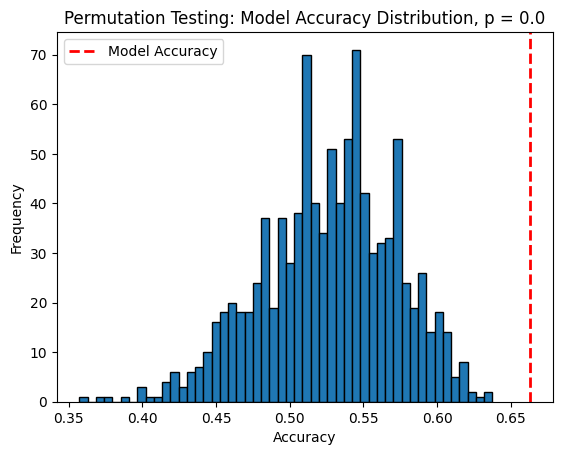

In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import bisect
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from pyopls import OPLS
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict, LeaveOneOut
from sklearn.metrics import r2_score, accuracy_score


def count_values_greater_than(sorted_list, target_value):
    # Use bisect_right to find the index of the first element greater than the target_value
    index = bisect.bisect_right(sorted_list, target_value)
    
    # The count of values greater than the target_value is the length of the list minus the index
    count = len(sorted_list) - index
    
    return count

def round_to_sign(value):
    if value >= 0:
        return np.ceil(value)
    else:
        return np.floor(value)




X = X.fillna(0)
X = stats.zscore(X, ddof = 1)
# do you orthogoranlize all the permutations? -> yes



# Generate some example data
np.random.seed(42)

# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
opls = OPLS(2) # 1 components
Z = opls.fit_transform(X, y)
pls_model = PLSRegression(2)


pls_model.fit(Z, y)
#y_pred= pls.predict(X)
processed_y_pred = cross_val_predict(pls_model, Z, y, cv=5)

                           
processed_q_squared = r2_score(y, processed_y_pred) 
processed_dq_squared = r2_score(y, np.clip(processed_y_pred, -1, 1))  # 0.984
processed_accuracy = accuracy_score(y, np.sign(processed_y_pred))  # 1.0
processed_accuracy_rounded = round(processed_accuracy,2)

variance_in_x = np.var(pls_model.x_scores_, axis = 0) 
total_variance_in_x = np.var(Z, axis = 0)
# normalize variance by total variance:
#fractions_of_explained_variance = variance_in_x / total_variance_in_x

r2_X = opls.score(X)  # 7.8e-12 (most variance is removed)


# Number of permutations
num_permutations = 1000

# List to store permutation accuracies
permuted_accuracies = []

# Permutation testing loop
for _ in tqdm(range(num_permutations)):
    # Randomly permute the labels
    permuted_labels = np.random.permutation(y)
    
    
#processed_y_pred = cross_val_predict(pls, Z, y, cv=1000)
#processed_q_squared = r2_score(y, processed_y_pred)  # 0.981
#processed_dq_squared = r2_score(y, np.clip(processed_y_pred, -1, 1))  # 0.984
#processed_accuracy = accuracy_score(y, np.sign(processed_y_pred))  # 1.0
    opls = OPLS(2) # 1 components
    Z_i = opls.fit_transform(X, permuted_labels)

    #permuted_model.fit(X, permuted_labels)
    pls = PLSRegression(1)
    permuted_pred = cross_val_predict(pls, Z_i, permuted_labels, cv=5) # I should change this to something smaller, leave one out would literally take foever
    # Make predictions with the permuted model
    #permuted_predictions = permuted_model.predict(X)
    
    # Calculate accuracy and store in the list
    permuted_pred = [round_to_sign(value) for value in permuted_pred]# Round each value in the list based on the specified rules


    permuted_accuracy = accuracy_score(y, permuted_pred)
    permuted_accuracies.append(permuted_accuracy)

    
permuted_accuracies = pd.Series(np.sort(permuted_accuracies), index = range(1000))
result_count = count_values_greater_than(permuted_accuracies, processed_accuracy)
p = 1-(1000-result_count)/1000
p_round = round(p,3)

# Plotting the histogram
plt.hist(permuted_accuracies, bins=50, edgecolor='black')
plt.axvline(x=processed_accuracy, color='red', linestyle='dashed', linewidth=2, label='Model Accuracy')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title(f'Permutation Testing: Model Accuracy Distribution, p = {p}')
plt.legend()
plt.show()

In [ ]:
#plt.figure(1)
#df = pd.DataFrame(np.column_stack([pls_model.x_scores_, opls.T_ortho_[:, 0]]),
#                  index=y.index, columns=['t', 't_ortho'])                
df = pd.DataFrame(np.column_stack([pls_model.x_scores_]),
                  index=y.index, columns=['lv1', 'lv2'])       
pos_df = df[y==1]
neg_df = df[y==-1]
plt.scatter(neg_df['lv1'], neg_df['lv2'], c='red', label='short')
plt.scatter(pos_df['lv1'], pos_df['lv2'], c='blue', label='long')
plt.title(f'X Scores: (CV accuracy = {processed_accuracy_rounded})\np ={p_round}')
#plt.xlabel(f'PC1 X_var explained = {round(np.var(df.iloc[:,0])/sum(np.var(df.iloc[:,:], axis = None)), 3)}')
#plt.ylabel(f'PC2 X_var explained = {round(np.var(df.iloc[:,1])/sum(np.var(df.iloc[:,:], axis = None)), 3)}')
plt.legend(loc='upper right')
plt.show()

## 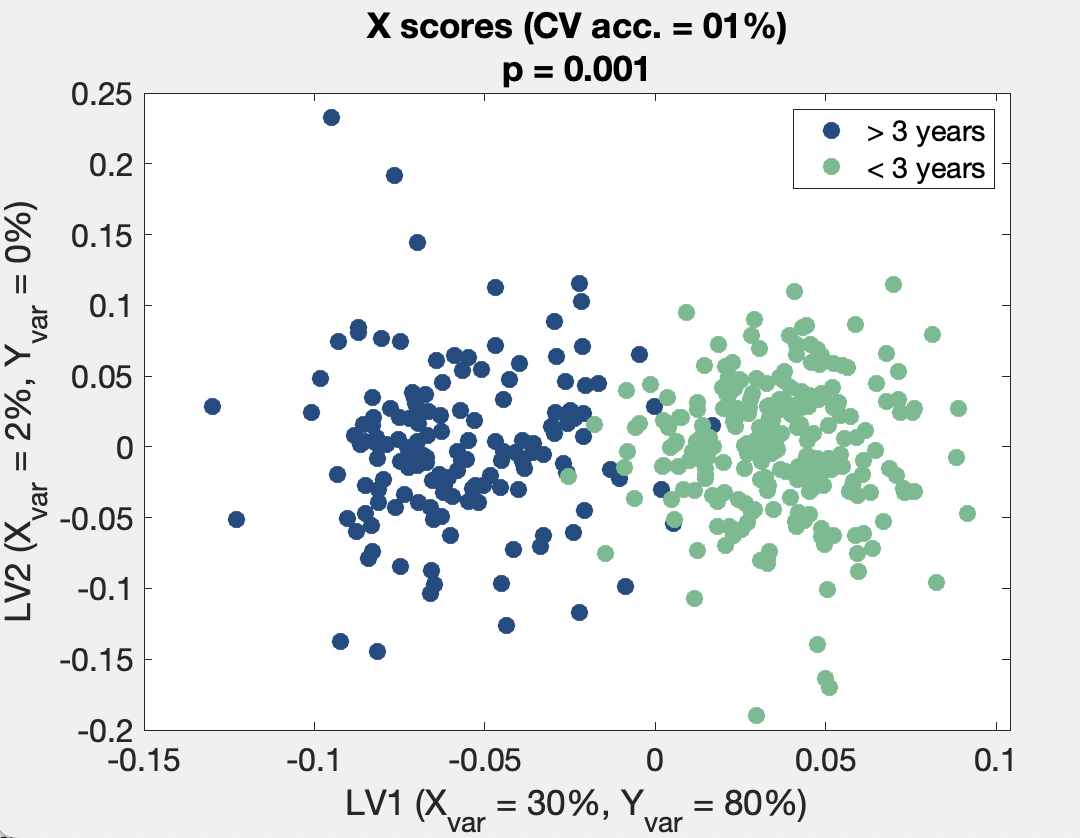


Text(0.5, 1.0, 'Loadings for oPLSDA model')

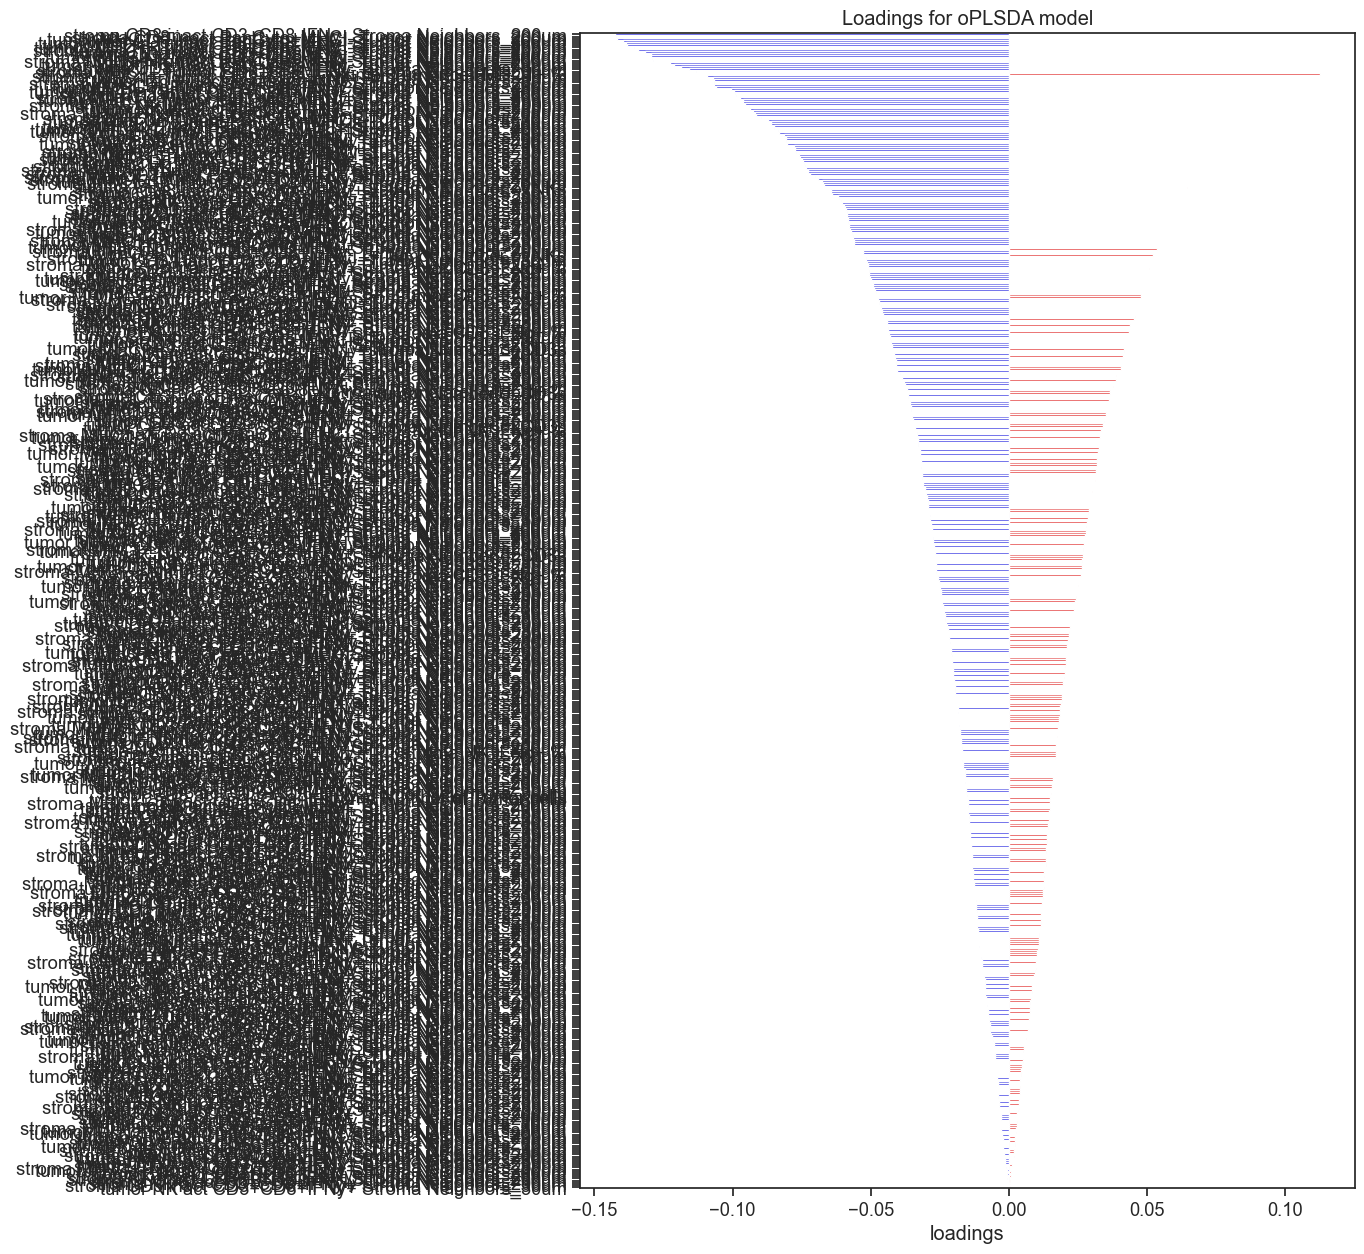

In [40]:
plt.figure(figsize=(10, 15)) 
x_loadings = pd.DataFrame(pls_model.x_loadings_[:,0].flatten(), index= X.columns, columns = ['loadings'])
x_loadings['color'] = np.where(x_loadings['loadings'] > 0, 'red', 'blue')
colors = {'red': 'red', 'blue': 'blue'}

x_loadings['abs_val'] = abs(x_loadings['loadings'])
x_loadings = x_loadings.sort_values(by = 'abs_val', ascending=False)
sns.barplot(data = x_loadings, x=x_loadings['loadings'],y = x_loadings.index, hue = 'color', palette = colors)
plt.legend().set_visible(False)
plt.ylabel('')
plt.title('Loadings for oPLSDA model')

Text(0.5, 1.0, 'VIPs for oPLSDA model')

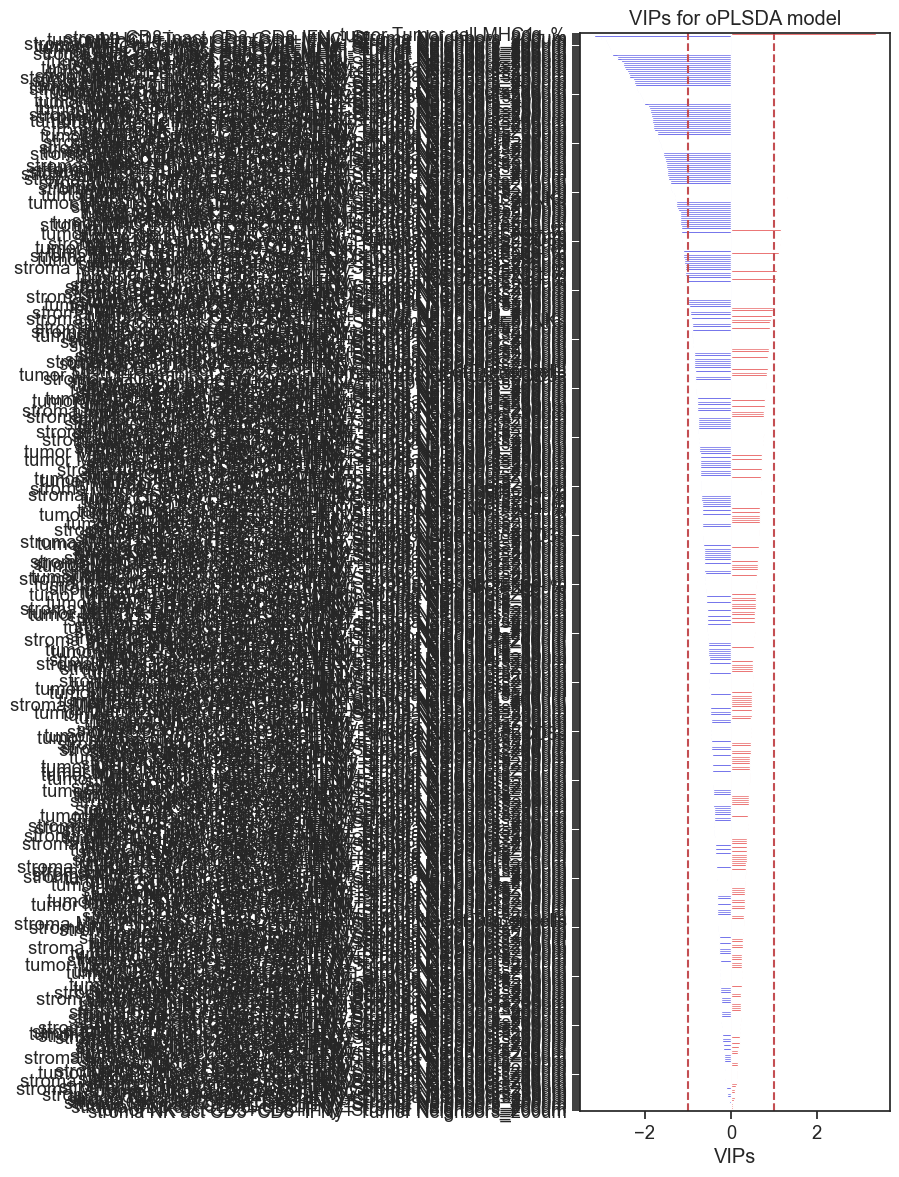

In [41]:

# lets try to make a VIP score with the same logic as Rem's code:
# Calculate VIP scores
def vip_efficient(model):
    t = model.x_scores_
    w = model.x_weights_ # replace with x_rotations_ if needed
    q = model.y_loadings_ 
    features_, _ = w.shape
    vip = np.zeros(shape=(features_,))
    inner_sum = np.diag(t.T @ t @ q.T @ q)
    SS_total = np.sum(inner_sum)
    vip = np.sqrt(features_*(w**2 @ inner_sum)/ SS_total)
    return vip

vips = vip_efficient(pls_model)

plt.figure(figsize=(4, 14)) 


loadings_vips = pd.DataFrame(pls_model.x_loadings_[:,0].flatten(), index= X.columns, columns = ['loadings'])
loadings_vips['VIPs'] = vips
loadings_vips['color'] = np.where(loadings_vips['loadings'] > 0, 'short', 'long')
colors = {'short': 'red', 'long': 'blue'}

loadings_vips = loadings_vips.sort_values(by = 'VIPs', ascending=False)
for i in loadings_vips.index:
    if loadings_vips.loc[i,'loadings'] < 0:
        loadings_vips.loc[i,'VIPs'] = loadings_vips.loc[i,'VIPs']*-1
sns.barplot(data = loadings_vips, x=loadings_vips['VIPs'],y = loadings_vips.index, hue = 'color', palette = colors)
plt.axvline(x = -1, color = 'r', linestyle='--')
plt.axvline(x = 1, color = 'r', linestyle='--')
plt.legend().set_visible(False)
plt.ylabel('')
plt.title('VIPs for oPLSDA model')

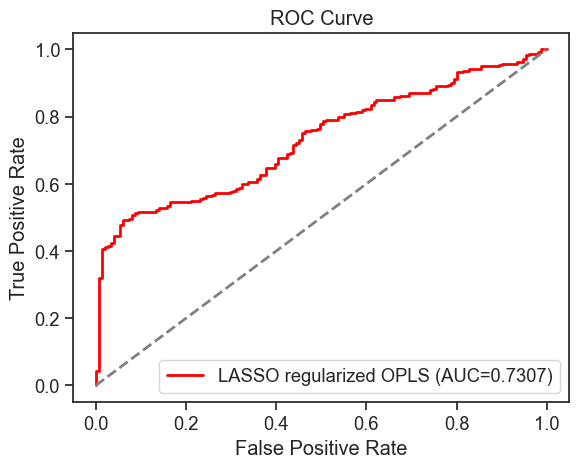

In [42]:
proc_fpr, proc_tpr, proc_thresholds = roc_curve(y, processed_y_pred)
proc_roc_auc = roc_auc_score(y, processed_y_pred)

plt.plot(proc_fpr, proc_tpr, lw=2, color='red',
         label=f'LASSO regularized OPLS (AUC={proc_roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

## LASSO with orthogonalizaiton

In [8]:
# distinguishing the center cells
X = pd.read_csv('/scratch/gh8sj/brown_nsclc/data/output_data/q3_dfs_target_neighbor_center_cell_act.csv',index_col=0)

# no distinguishing center cells
#X = pd.read_csv('/scratch/gh8sj/brown_nsclc/data/output_data/q3_dfs_center_cell_act.csv', index_col=0)

In [9]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold
from scipy import stats
from scipy.stats import zscore 

y_str = X['survival group']
X = X.drop(columns=['survival group', 'patient'])
y = y_str.apply(lambda x: 1 if x == '> 3 years' else -1)
X = X.fillna(0)
X = stats.zscore(X, ddof = 1)


#z_score_x = zscore(X.astype(float), axis = 1, ddof=1)

# parameters to be tested on GridSearchCV


# Number of Folds and adding the random state for replication

# Initializing the Model
lassocv = LassoCV(alphas=[1E-5, 1E-4, 1E-3, 1E-2, 1E-1, 1],cv = 10)


# GridSearchCV with model, params and folds.
lassocv.fit(X,y)
lasso_feat = lassocv.coef_
selected_features = np.array(X.columns)[lasso_feat != 0]
lasso_selected_x = X.loc[:,X.columns.isin(selected_features)]


/home/gh8sj/.conda/envs/spy_cell/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.662e+00, tolerance: 3.046e-02
  model = cd_fast.enet_coordinate_descent(
/home/gh8sj/.conda/envs/spy_cell/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.729e+00, tolerance: 3.046e-02
  model = cd_fast.enet_coordinate_descent(
/home/gh8sj/.conda/envs/spy_cell/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider in

In [10]:
print(lassocv.alpha_, sum(x != 0 for x in lassocv.coef_))

0.1 11


In [11]:
selected_features

array(['tumor Number of CD8s', 'tumor Tumor cell MHC1+ %',
       'tumor MHC1+ Tumor PanCyto+MHCI+ Tumor Neighbors_30um',
       'tumor MHC1- Tumor PanCyto+MHCI- Tumor Neighbors_200um',
       'stroma CD8 inact CD3+CD8-IFNy- Stroma Neighbors_200um',
       'stroma NK act CD56+CD3-IFNy+ Stroma Neighbors_30um',
       'stroma NK inact CD56+CD3-IFNy- Stroma Neighbors_200um',
       'stroma NK inact PanCyto+MHCI+ Stroma Neighbors_200um',
       'stroma NK inact PanCyto+MHCI- Tumor Neighbors_200um',
       'stroma MHC1+ Tumor CD3+CD8-IFNy- Stroma Neighbors_200um',
       'stroma MHC1+ Tumor PanCyto+MHCI- Tumor Neighbors_200um'],
      dtype=object)

In [12]:
#distinguishing center cells 
X = pd.read_csv('/scratch/gh8sj/brown_nsclc/data/output_data/q3_dfs_target_neighbor_center_cell_act.csv',index_col=0)

# no distinguishing center cells
#X = pd.read_csv('/scratch/gh8sj/brown_nsclc/data/output_data/q3_dfs_center_cell_act.csv', index_col=0)
X

tumor CD8 IFNg+ %  tumor Number of CD8s  \
17-199_[43424,7543]            0.000000                  14.0   
17-199_[43424,9043]            0.000000                 228.0   
17-199_[44446,10543]           0.000000                1094.0   
17-199_[44675,12043]           0.000000                 438.0   
17-199_[45431,7543]            0.000000                  40.0   
...                                 ...                   ...   
17-536_[47032,15356]           0.083333                  84.0   
17-536_[47032,16856]           0.025000                  40.0   
17-536_[49039,10345]           0.000000                  34.0   
17-536_[49039,11845]           0.000000                  42.0   
17-536_[49039,13345]           0.166667                   6.0   

                      tumor CD3 IFNg+ %  tumor Number of CD3s  \
17-199_[43424,7543]            0.000000                 176.0   
17-199_[43424,9043]            0.000000                1758.0   
17-199_[44446,10543]           0.000000                6514.0   
17-199_[44675,12043]           0.000000                2824.0   
17-199_[45431,7543]            0.000000                 164.0   
...                                 ...                   ...   
17-536_[47032,15356]           0.024952                 521.0   
17-536_[47032,16856]           0.002688                 372.0   
17-536_[49039,10345]           0.000000                 231.0   
17-536_[49039,11845]           0.000000                 248.0   
17-536_[49039,13345]           0.000000                  52.0   

                      tumor NK IFNg+ %  tumor Number of NKs  \
17-199_[43424,7543]           0.000000                 86.0   
17-199_[43424,9043]           0.000000                148.0   
17-199_[44446,10543]          0.009036                664.0   
17-199_[44675,12043]          0.000000                212.0   
17-199_[45431,7543]           0.000000                 90.0   
...                                ...                  ...   
17-536_[47032,15356]          0.153846                 13.0   
17-536_[47032,16856]          0.666667                  9.0   
17-536_[49039,10345]          0.000000                 21.0   
17-536_[49039,11845]          0.000000                 30.0   
17-536_[49039,13345]          0.000000                  5.0   

                      tumor Tumor cell MHC1+ %  tumor Number of Tumor cells  \
17-199_[43424,7543]                   1.000000                        514.0   
17-199_[43424,9043]                   1.000000                        718.0   
17-199_[44446,10543]                  0.996696                       1816.0   
17-199_[44675,12043]                  1.000000                        880.0   
17-199_[45431,7543]                   0.974359                        234.0   
...                                        ...                          ...   
17-536_[47032,15356]                  0.437700                       1565.0   
17-536_[47032,16856]                  0.464430                       1490.0   
17-536_[49039,10345]                  0.233633                       3116.0   
17-536_[49039,11845]                  0.236631                       3123.0   
17-536_[49039,13345]                  0.277829                       1087.0   

                      tumor CD8 act CD3+CD8+IFNy+ Tumor Neighbors_30um  \
17-199_[43424,7543]                                           0.000000   
17-199_[43424,9043]                                           0.000000   
17-199_[44446,10543]                                          0.000000   
17-199_[44675,12043]                                          0.000000   
17-199_[45431,7543]                                           0.000000   
...                                                                ...   
17-536_[47032,15356]                                          0.679002   
17-536_[47032,16856]                                          0.000000   
17-536_[49039,10345]                                          0.000000   
17-536_[49039,

In [13]:
X = X.fillna(0)
X = X.loc[:,X.columns.isin(selected_features)]
X['survival group'] = y_str

X
X.to_csv('/scratch/gh8sj/brown_nsclc/data/output_data/lasso_selected_q3_dfs_target_neighbor_center_cell_act.csv')


In [14]:
for i in X.columns:
    print(i)

tumor Number of CD8s
tumor Tumor cell MHC1+ %
tumor MHC1+ Tumor PanCyto+MHCI+ Tumor Neighbors_30um
tumor MHC1- Tumor PanCyto+MHCI- Tumor Neighbors_200um
stroma CD8 inact CD3+CD8-IFNy- Stroma Neighbors_200um
stroma NK act CD56+CD3-IFNy+ Stroma Neighbors_30um
stroma NK inact CD56+CD3-IFNy- Stroma Neighbors_200um
stroma NK inact PanCyto+MHCI+ Stroma Neighbors_200um
stroma NK inact PanCyto+MHCI- Tumor Neighbors_200um
stroma MHC1+ Tumor CD3+CD8-IFNy- Stroma Neighbors_200um
stroma MHC1+ Tumor PanCyto+MHCI- Tumor Neighbors_200um
survival group


In [15]:

X = pd.read_csv('/scratch/gh8sj/brown_nsclc/data/output_data/lasso_selected_q3_dfs_target_neighbor_center_cell_act.csv',index_col=0)
y_str = X['survival group']
X = X.drop(columns=['survival group'])
X = X.loc[:,X.columns.isin(selected_features)]
X = stats.zscore(X, ddof = 0)
y = y_str.apply(lambda x: 1 if x == '> 3 years' else -1)
X

tumor Number of CD8s  tumor Tumor cell MHC1+ %  \
17-199_[43424,7543]              -0.600091                  2.592465   
17-199_[43424,9043]               0.122891                  2.592465   
17-199_[44446,10543]              3.048605                  2.581028   
17-199_[44675,12043]              0.832360                  2.592465   
17-199_[45431,7543]              -0.512252                  2.503711   
...                                    ...                       ...   
17-536_[47032,15356]             -0.363602                  0.646119   
17-536_[47032,16856]             -0.512252                  0.738641   
17-536_[49039,10345]             -0.532523                 -0.060238   
17-536_[49039,11845]             -0.505495                 -0.049859   
17-536_[49039,13345]             -0.627118                  0.092742   

                      tumor MHC1+ Tumor PanCyto+MHCI+ Tumor Neighbors_30um  \
17-199_[43424,7543]                                           -0.110275      
17-199_[43424,9043]                                           -0.519780      
17-199_[44446,10543]                                          -0.724039      
17-199_[44675,12043]                                          -0.354390      
17-199_[45431,7543]                                           -0.406935      
...                                                                 ...      
17-536_[47032,15356]                                           0.741248      
17-536_[47032,16856]                                           0.595573      
17-536_[49039,10345]                                          -0.359894      
17-536_[49039,11845]                                          -0.425273      
17-536_[49039,13345]                                          -0.131681      

                      tumor MHC1- Tumor PanCyto+MHCI- Tumor Neighbors_200um  \
17-199_[43424,7543]                                           -1.430154       
17-199_[43424,9043]                                           -1.430154       
17-199_[44446,10543]                                          -0.368426       
17-199_[44675,12043]                                          -1.430154       
17-199_[45431,7543]                                           -0.109573       
...                                                                 ...       
17-536_[47032,15356]                                           0.933424       
17-536_[47032,16856]                                           0.800872       
17-536_[49039,10345]                                           0.990364       
17-536_[49039,11845]                                           0.635208       
17-536_[49039,13345]                                           1.349187       

                      stroma CD8 inact CD3+CD8-IFNy- Stroma Neighbors_200um  \
17-199_[43424,7543]                                           -0.044032       
17-199_[43424,9043]                                           -0.317455       
17-199_[44446,10543]                                          -0.410577       
17-199_[44675,12043]                                           0.004377       
17-199_[45431,7543]                                           -0.721147       
...                                                                 ...       
17-536_[47032,15356]                                           2.053050       
17-536_[47032,16856]                                           2.549508       
17-536_[49039,10345]                                          -0.113082       
17-536_[49039,11845]                                          -0.394239       
17-536_[49039,13345]                                           0.234434       

                      stroma NK act CD56+CD3-IFNy+ Stroma Neighbors_30um  \
17-199_[43424,7543]                                            3.853918    
17-199_[43424,9043]                                           -0.298584    
17-199_[44446,10543]                                          -0.298584    
17-199_[44675,1204

100%|██████████| 1000/1000 [00:04<00:00, 244.58it/s]


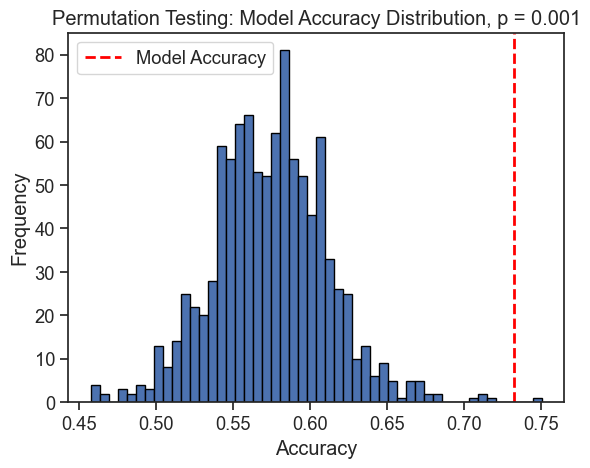

In [25]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import bisect

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from pyopls import OPLS
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict, LeaveOneOut
from sklearn.metrics import r2_score, accuracy_score


def count_values_greater_than(sorted_list, target_value):
    # Use bisect_right to find the index of the first element greater than the target_value
    index = bisect.bisect_right(sorted_list, target_value)
    
    # The count of values greater than the target_value is the length of the list minus the index
    count = len(sorted_list) - index
    
    return count

def round_to_sign(value):
    if value >= 0:
        return np.ceil(value)
    else:
        return np.floor(value)


X = pd.read_csv('/scratch/gh8sj/brown_nsclc/data/output_data/lasso_selected_q3_dfs_target_neighbor_center_cell_act.csv',index_col=0)
y_str = X['survival group']
X = X.drop(columns=['survival group'])
X = X.loc[:,X.columns.isin(selected_features)]
X = stats.zscore(X, ddof = 0)
y = y_str.apply(lambda x: 1 if x == '> 3 years' else -1)
y





# do you orthogoranlize all the permutations? -> yes



# Generate some example data
np.random.seed(42)

# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
opls = OPLS(2) # 1 components
Z = opls.fit_transform(X, y)
pls_model = PLSRegression(2)


pls_model.fit(Z, y)
#y_pred= pls.predict(X)
processed_y_pred = cross_val_predict(pls_model, Z, y, cv=5)

                           
processed_q_squared = r2_score(y, processed_y_pred) 
processed_dq_squared = r2_score(y, np.clip(processed_y_pred, -1, 1))  # 0.984
processed_accuracy = accuracy_score(y, np.sign(processed_y_pred))  # 1.0
processed_accuracy_rounded = round(processed_accuracy,2)

variance_in_x = np.var(pls_model.x_scores_, axis = 0) 
total_variance_in_x = np.var(Z, axis = 0)
# normalize variance by total variance:
#fractions_of_explained_variance = variance_in_x / total_variance_in_x

r2_X = opls.score(X)  # 7.8e-12 (most variance is removed)


# Number of permutations
num_permutations = 1000

# List to store permutation accuracies
permuted_accuracies = []

# Permutation testing loop
for _ in tqdm(range(num_permutations)):
    # Randomly permute the labels
    permuted_labels = np.random.permutation(y)
    
    
#processed_y_pred = cross_val_predict(pls, Z, y, cv=1000)
#processed_q_squared = r2_score(y, processed_y_pred)  # 0.981
#processed_dq_squared = r2_score(y, np.clip(processed_y_pred, -1, 1))  # 0.984
#processed_accuracy = accuracy_score(y, np.sign(processed_y_pred))  # 1.0
    opls = OPLS(2) # 1 components
    Z_i = opls.fit_transform(X, permuted_labels)

    #permuted_model.fit(X, permuted_labels)
    pls = PLSRegression(1)
    permuted_pred = cross_val_predict(pls, Z_i, permuted_labels, cv=5) # I should change this to something smaller, leave one out would literally take foever
    # Make predictions with the permuted model
    #permuted_predictions = permuted_model.predict(X)
    
    # Calculate accuracy and store in the list
    permuted_pred = [round_to_sign(value) for value in permuted_pred]# Round each value in the list based on the specified rules


    permuted_accuracy = accuracy_score(y, permuted_pred)
    permuted_accuracies.append(permuted_accuracy)

    
permuted_accuracies = pd.Series(np.sort(permuted_accuracies), index = range(1000))
result_count = count_values_greater_than(permuted_accuracies, processed_accuracy)
p = 1-(1000-result_count)/1000
p_round = round(p,3)

# Plotting the histogram
plt.hist(permuted_accuracies, bins=50, edgecolor='black')
plt.axvline(x=processed_accuracy, color='red', linestyle='dashed', linewidth=2, label='Model Accuracy')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title(f'Permutation Testing: Model Accuracy Distribution, p = {round(p, 3)}')
plt.legend()
plt.savefig('/scratch/gh8sj/kate_gabe_paper_figures/figure6/figS6a.pdf', format = 'pdf', bbox_inches = 'tight')

plt.show()

In [17]:
y

17-199_[43424,7543]    -1
17-199_[43424,9043]    -1
17-199_[44446,10543]   -1
17-199_[44675,12043]   -1
17-199_[45431,7543]    -1
                       ..
17-536_[47032,15356]    1
17-536_[47032,16856]    1
17-536_[49039,10345]    1
17-536_[49039,11845]    1
17-536_[49039,13345]    1
Name: survival group, Length: 389, dtype: int64

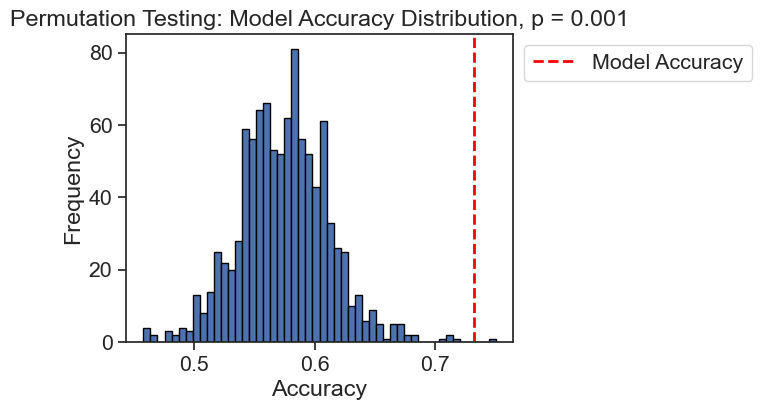

In [18]:
# Plotting the histogram
import matplotlib.colors as colors
sns.set(font_scale = 1.4)
sns.set_style("ticks")
plt.figure(figsize=(5, 4)) 

plt.hist(permuted_accuracies, bins=50, edgecolor='black')
plt.axvline(x=processed_accuracy, color='red', linestyle='dashed', linewidth=2, label='Model Accuracy')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title(f'Permutation Testing: Model Accuracy Distribution, p = {p_round}')
#plt.legend(loc = 'best')
plt.legend(bbox_to_anchor = (1,1))
plt.savefig('/home/gh8sj/projects/gabe_kate_method/figures/nsclc/final_figures/fig_S7a_permutations.pdf',format='pdf',bbox_inches = 'tight')
plt.show()

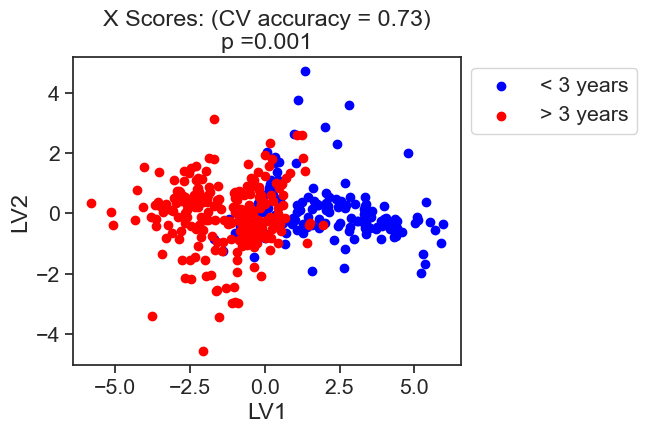

In [21]:
#plt.figure(1)
#df = pd.DataFrame(np.column_stack([pls_model.x_scores_, opls.T_ortho_[:, 0]]),
#                  index=y.index, columns=['t', 't_ortho']) 
import matplotlib.colors as colors
sns.set(font_scale = 1.4)
sns.set_style("ticks")
plt.figure(figsize=(5, 4)) 

df = pd.DataFrame(np.column_stack([pls_model.x_scores_]),
                  index=y.index, columns=['lv1', 'lv2'])       
pos_df = df[y==1]
neg_df = df[y==-1]
plt.scatter(neg_df['lv1'], neg_df['lv2'], c='blue', label='< 3 years')
plt.scatter(pos_df['lv1'], pos_df['lv2'], c='red', label='> 3 years')
plt.title(f'X Scores: (CV accuracy = {processed_accuracy_rounded})\np ={p_round}')
#plt.xlabel(f'PC1 X_var explained = {round(np.var(df.iloc[:,0])/sum(np.var(df.iloc[:,:], axis = None)), 3)}')
plt.xlabel('LV1')
#plt.ylabel(f'PC2 X_var explained = {round(np.var(df.iloc[:,1])/sum(np.var(df.iloc[:,:], axis = None)), 3)}')
plt.ylabel('LV2')
plt.legend(bbox_to_anchor = (1,1))
#plt.savefig('/home/gh8sj/projects/gabe_kate_method/figures/nsclc/final_figures/fig_7c_scores.pdf',format='pdf', bbox_inches = 'tight')
plt.savefig('/scratch/gh8sj/kate_gabe_paper_figures/figure6/fig6c.pdf', format = 'pdf', bbox_inches = 'tight')

plt.show()

##  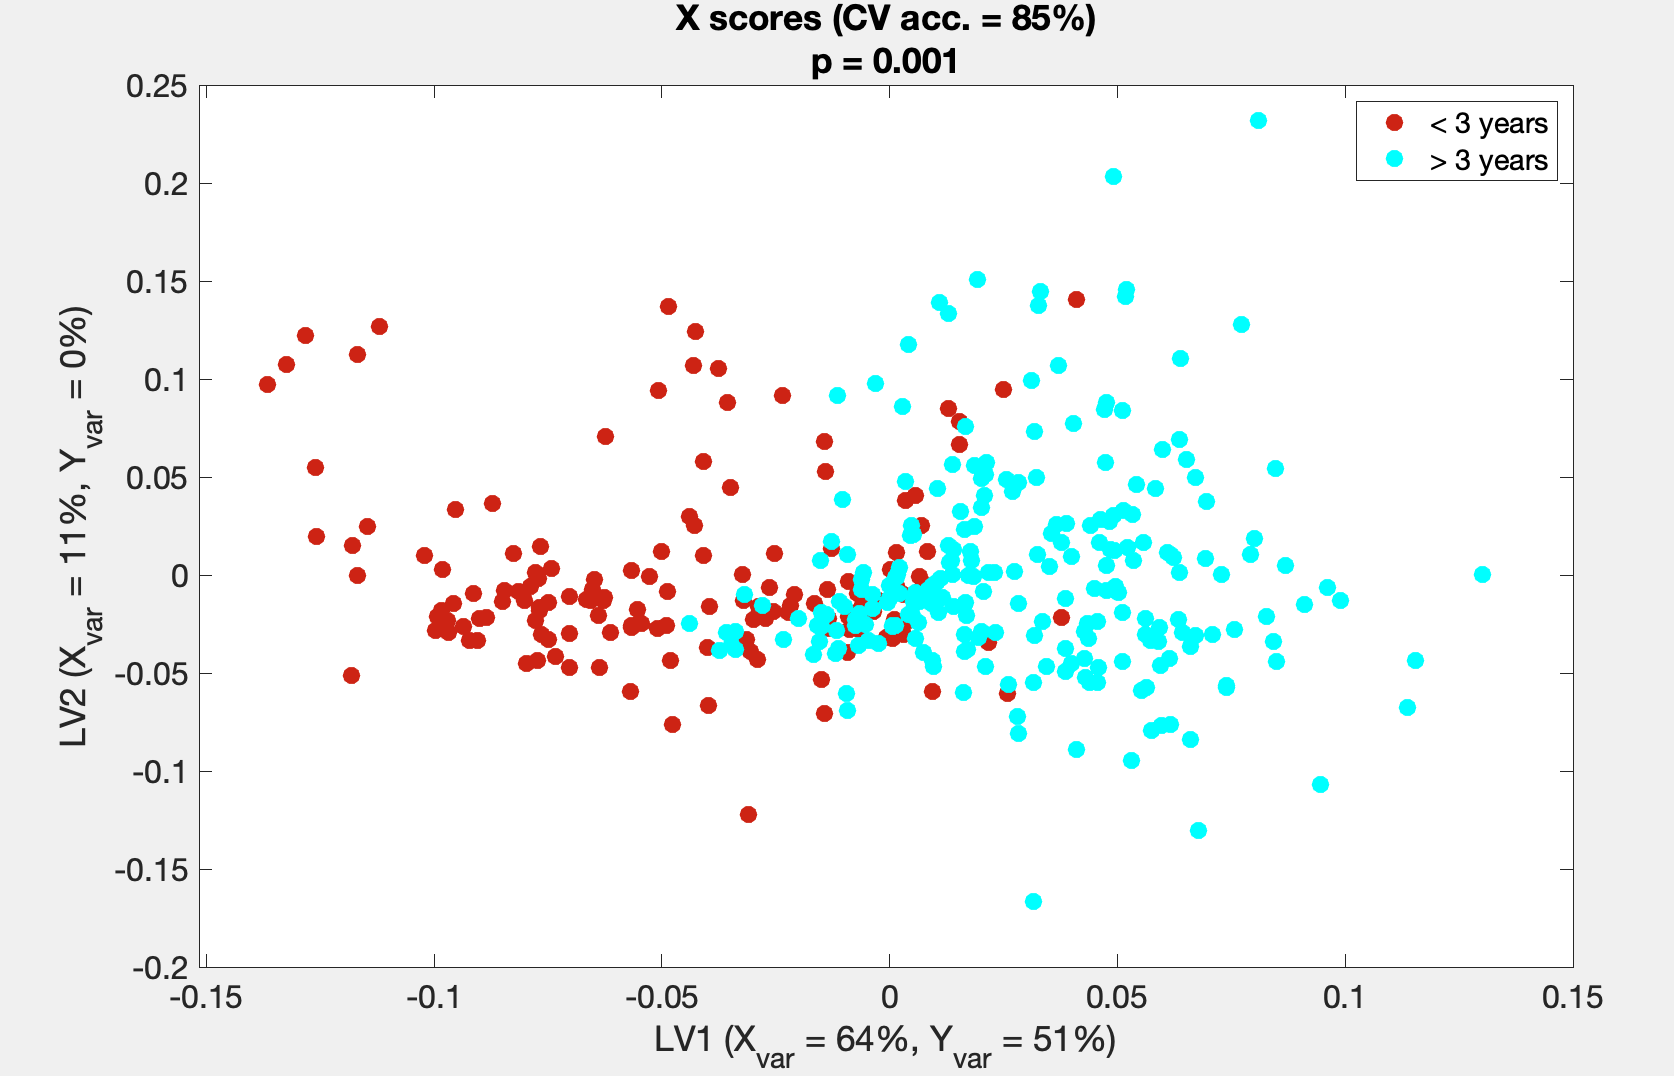
### Matlab Lasso version


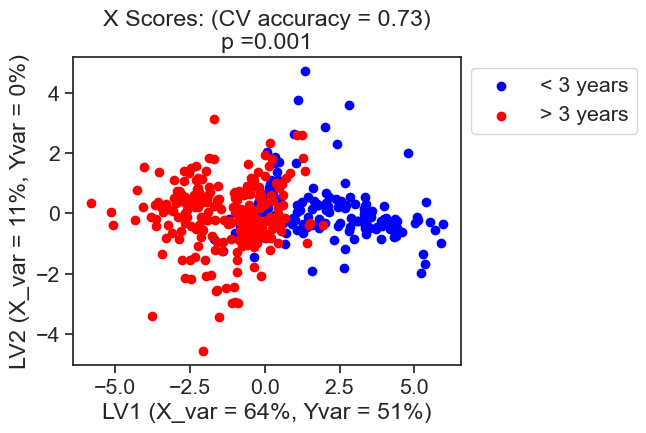

In [22]:
#plt.figure(1)
#df = pd.DataFrame(np.column_stack([pls_model.x_scores_, opls.T_ortho_[:, 0]]),
#                  index=y.index, columns=['t', 't_ortho'])
import matplotlib.colors as colors
sns.set(font_scale = 1.4)
sns.set_style("ticks")
plt.figure(figsize=(5, 4)) 

df = pd.DataFrame(np.column_stack([pls_model.x_scores_]),
                  index=y.index, columns=['lv1', 'lv2'])       
pos_df = df[y==1]
neg_df = df[y==-1]
plt.scatter(neg_df['lv1'], neg_df['lv2'], c='blue', label='< 3 years')
plt.scatter(pos_df['lv1'], pos_df['lv2'], c='red', label='> 3 years')
plt.title(f'X Scores: (CV accuracy = {processed_accuracy_rounded})\np ={p_round}')
plt.xlabel('LV1 (X_var = 64%, Yvar = 51%)')
plt.ylabel('LV2 (X_var = 11%, Yvar = 0%)')
plt.legend(bbox_to_anchor = (1,1))
#plt.savefig('/home/gh8sj/projects/gabe_kate_method/figures/nsclc/final_figures/fig_7c_scores.pdf',format='pdf', bbox_inches = 'tight')
#plt.savefig('/scratch/gh8sj/projects/gabe_kate_method/figures/nsclc/final_figures/fig_7c_scores.pdf',format='pdf', bbox_inches = 'tight')
plt.savefig('/scratch/gh8sj/kate_gabe_paper_figures/figure6/fig6c.pdf', format = 'pdf', bbox_inches = 'tight')

plt.show()


Text(0.5, 1.0, 'Loadings for oPLSDA model')

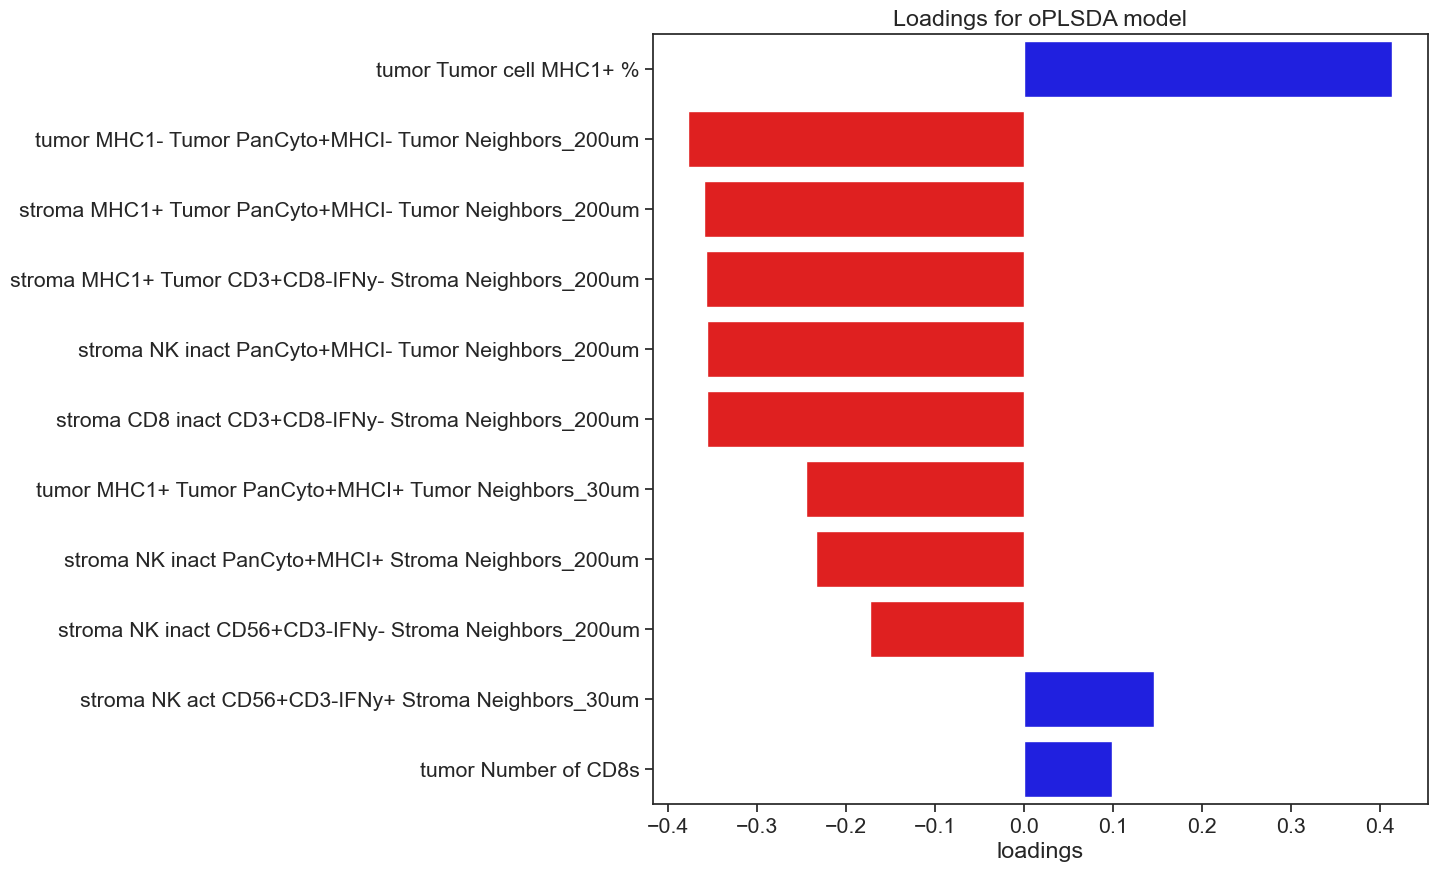

In [20]:
plt.figure(figsize=(10, 10)) 
x_loadings = pd.DataFrame(pls_model.x_loadings_[:,0].flatten(), index= X.columns, columns = ['loadings'])
x_loadings['color'] = np.where(x_loadings['loadings'] > 0, 'blue', 'red')
colors = {'red': 'red', 'blue': 'blue'}

x_loadings['abs_val'] = abs(x_loadings['loadings'])
x_loadings = x_loadings.sort_values(by = 'abs_val', ascending=False)
sns.barplot(data = x_loadings, x=x_loadings['loadings'],y = x_loadings.index, hue = 'color', palette = colors)
plt.legend().set_visible(False)
plt.ylabel('')
plt.title('Loadings for oPLSDA model')

Text(0.5, 1.0, 'VIPs for oPLSDA model')

<Figure size 400x600 with 0 Axes>

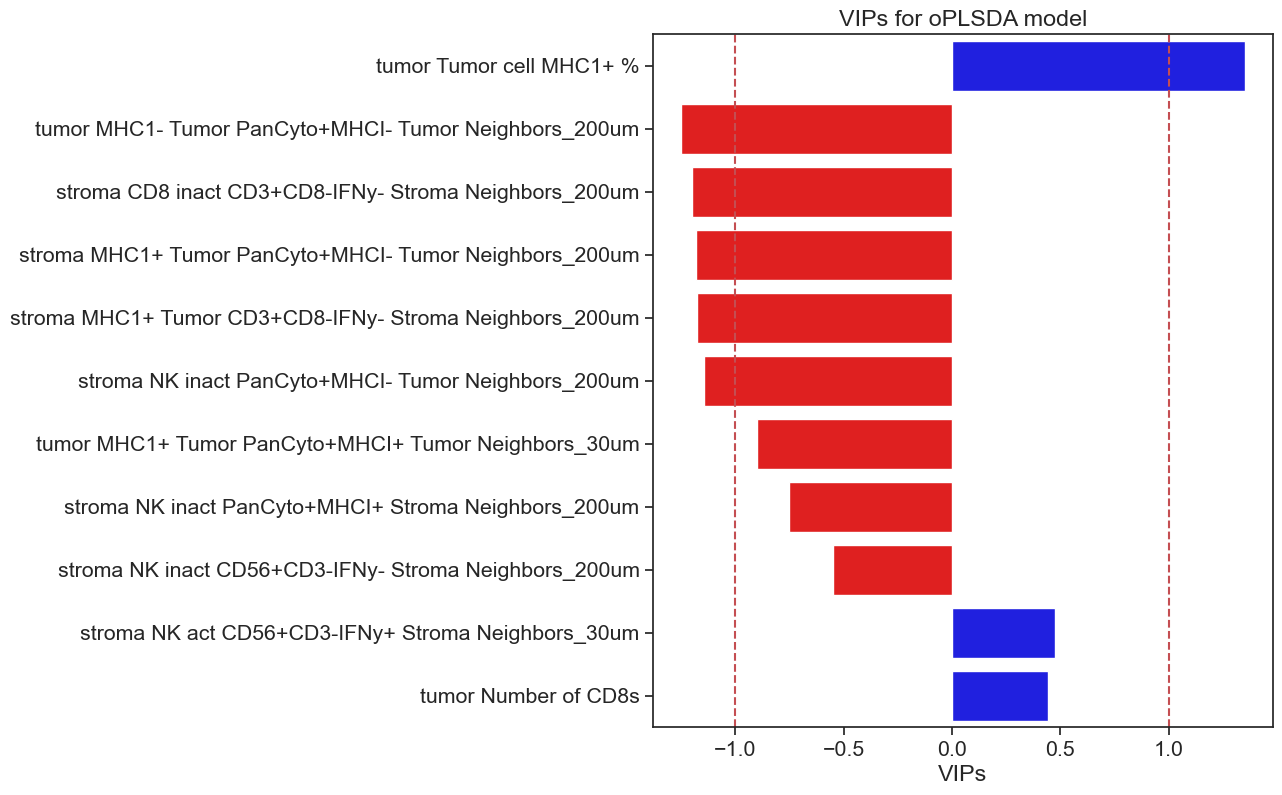

In [23]:

# lets try to make a VIP score with the same logic as Rem's code:
# Calculate VIP scores
def vip_efficient(model):
    t = model.x_scores_
    w = model.x_weights_ # replace with x_rotations_ if needed
    q = model.y_loadings_ 
    features_, _ = w.shape
    vip = np.zeros(shape=(features_,))
    inner_sum = np.diag(t.T @ t @ q.T @ q)
    SS_total = np.sum(inner_sum)
    vip = np.sqrt(features_*(w**2 @ inner_sum)/ SS_total)
    return vip

vips = vip_efficient(pls_model)

sns.set(font_scale = 1.4)
sns.set_style("ticks")
plt.figure(figsize=(4, 6)) 
plt.figure(figsize=(8, 9)) 


loadings_vips = pd.DataFrame(pls_model.x_loadings_[:,0].flatten(), index= X.columns, columns = ['loadings'])
loadings_vips['VIPs'] = vips
loadings_vips['color'] = np.where(loadings_vips['loadings'] > 0, '> 3 years', '< 3 years')
colors = {'< 3 years': 'red', '> 3 years': 'blue'}

loadings_vips = loadings_vips.sort_values(by = 'VIPs', ascending=False)
for i in loadings_vips.index:
    if loadings_vips.loc[i,'loadings'] < 0:
        loadings_vips.loc[i,'VIPs'] = loadings_vips.loc[i,'VIPs']*-1
sns.barplot(data = loadings_vips, x=loadings_vips['VIPs'],y = loadings_vips.index, hue = 'color', palette = colors)
plt.axvline(x = -1, color = 'r', linestyle='--')
plt.axvline(x = 1, color = 'r', linestyle='--')
plt.legend().set_visible(False)
plt.ylabel('')
#plt.savefig('/home/gh8sj/projects/gabe_kate_method/figures/nsclc/final_figures/fig_7d_VIPS.pdf',format='pdf', bbox_inches = 'tight')
plt.savefig('/scratch/gh8sj/kate_gabe_paper_figures/figure6/fig6d_old_names.pdf', format = 'pdf', bbox_inches = 'tight')

plt.title('VIPs for oPLSDA model')

## 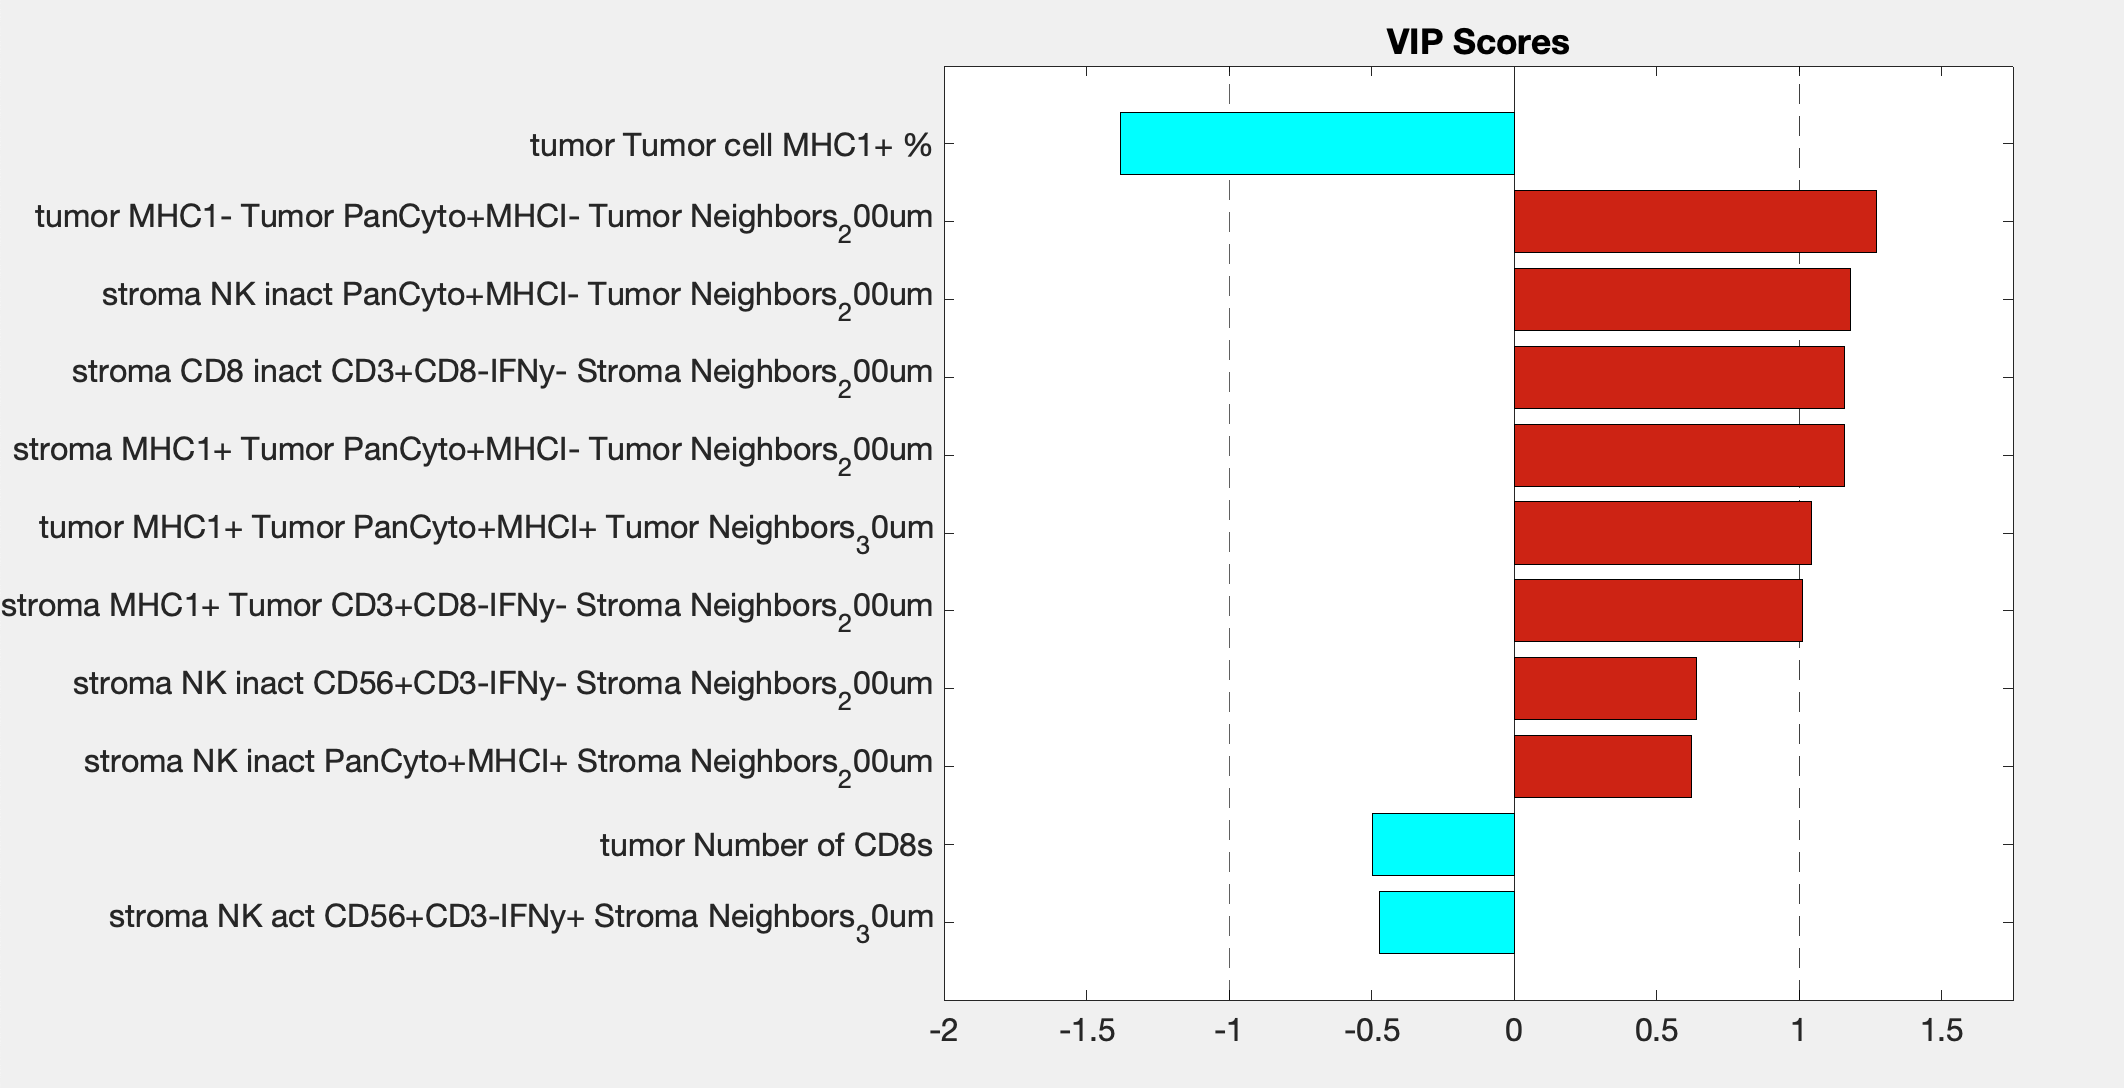
## matlab

 # they do match? - they do for the significant ones

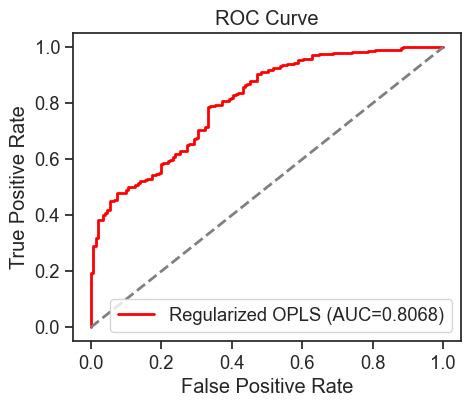

In [24]:
import matplotlib.colors as colors
sns.set(font_scale = 1.2)
sns.set_style("ticks")
plt.figure(figsize=(5, 4)) 

proc_fpr, proc_tpr, proc_thresholds = roc_curve(y, processed_y_pred)
proc_roc_auc = roc_auc_score(y, processed_y_pred)

plt.plot(proc_fpr, proc_tpr, lw=2, color='red',
         label=f'Regularized OPLS (AUC={proc_roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.savefig('/scratch/gh8sj/kate_gabe_paper_figures/figure6/figSB_roc.pdf', format = 'pdf', bbox_inches = 'tight')

plt.show()

In [24]:
cols_to_keep = x_loadings[1:5].index
melted_df = results_df.melt(id_vars = ['survival_group','patient'], value_vars= cols_to_keep)
melted_df

KeyError: "The following id_vars or value_vars are not present in the DataFrame: ['survival_group']"

In [26]:
X = pd.read_csv('/scratch/gh8sj/brown_nsclc/data/output_data/q3_DFS_3_year.csv',index_col=0)

In [27]:
X

CD8 IFNg+ %  Number of CD8s  CD3 IFNg+ %  \
17-199_[43424,7543]      0.000000           216.0     0.000000   
17-199_[43424,9043]      0.000000           988.0     0.000227   
17-199_[44446,10543]     0.000000          2532.0     0.000137   
17-199_[44675,12043]     0.000000           970.0     0.000000   
17-199_[45431,7543]      0.000000           830.0     0.000000   
...                           ...             ...          ...   
17-536_[47032,15356]     0.041237           194.0     0.008264   
17-536_[47032,16856]     0.014925           134.0     0.001807   
17-536_[49039,10345]     0.000000            58.0     0.000000   
17-536_[49039,11845]     0.000000            59.0     0.000000   
17-536_[49039,13345]     0.083333            12.0     0.000000   

                      Number of CD3s  NK IFNg+ %  Number of NKs  \
17-199_[43424,7543]           2596.0    0.002899          690.0   
17-199_[43424,9043]           8808.0    0.000000         1020.0   
17-199_[44446,10543]         14568.0    0.003209         1870.0   
17-199_[44675,12043]          5818.0    0.003704          540.0   
17-199_[45431,7543]           3576.0    0.000000         2086.0   
...                              ...         ...            ...   
17-536_[47032,15356]          1694.0    0.076923           39.0   
17-536_[47032,16856]          1660.0    0.571429           14.0   
17-536_[49039,10345]           315.0    0.000000           29.0   
17-536_[49039,11845]           349.0    0.000000           46.0   
17-536_[49039,13345]            74.0    0.000000           13.0   

                      Tumor cell MHC1+ %  Number of Tumor cells  \
17-199_[43424,7543]             1.000000                  540.0   
17-199_[43424,9043]             1.000000                  828.0   
17-199_[44446,10543]            0.993946                 1982.0   
17-199_[44675,12043]            1.000000                  956.0   
17-199_[45431,7543]             0.980519                  308.0   
...                                  ...                    ...   
17-536_[47032,15356]            0.484785                 1906.0   
17-536_[47032,16856]            0.535714                 1848.0   
17-536_[49039,10345]            0.241717                 3169.0   
17-536_[49039,11845]            0.252163                 3236.0   
17-536_[49039,13345]            0.286613                 1113.0   

                     survival_group patient  ...  \
17-199_[43424,7543]       < 3 years  17-199  ...   
17-199_[43424,9043]       < 3 years  17-199  ...   
17-199_[44446,10543]      < 3 years  17-199  ...   
17-199_[44675,12043]      < 3 years  17-199  ...   
17-199_[45431,7543]       < 3 years  17-199  ...   
...                             ...     ...  ...   
17-536_[47032,15356]      > 3 years  17-536  ...   
17-536_[47032,16856]      > 3 years  17-536  ...   
17-536_[49039,10345]      > 3 years  17-536  ...   
17-536_[49039,11845]      > 3 years  17-536  ...   
17-536_[49039,13345]      > 3 years  17-536  ...   

                      Tumor CD3+CD8-IFNy- Tumor Neighbors_200um  \
17-199_[43424,7543]                                    0.239113   
17-199_[43424,9043]                                    1.280335   
17-199_[44446,10543]                                   1.535268   
17-199_[44675,12043]                                   1.602439   
17-199_[45431,7543]                                    0.216494   
...                                                         ...   
17-536_[47032,15356]                                   0.793725   
17-536_[47032,16856]                                   0.684468   
17-536_[49039,10345]                                   0.650512   
17-536_[49039,11845]                                   0.556766   
17-536_[49039,13345]                                   0.749181   

                      Tumor CD3+CD8-IFNy- Stroma Neighbors_200um  \
17-199_[43424,7543]                                     0.871905   
17-199_[43424,9043]                                  

In [28]:
heat_input = X.drop(['patient', 'survival_group'], axis = 1)

<Axes: >

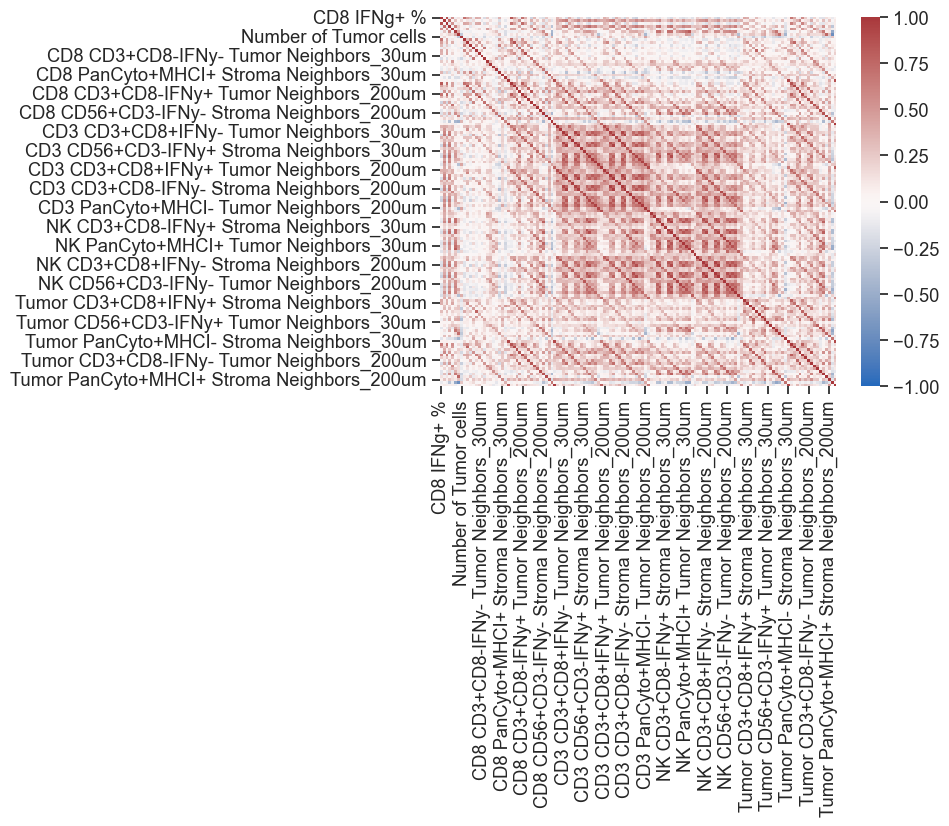

In [29]:
sns.heatmap(heat_input.corr(), cmap = 'vlag', center = 0 , vmin = -1, vmax = 1)

In [30]:
X = pd.read_csv('/scratch/gh8sj/brown_nsclc/data/output_data/q3_dfs_target_neighbor_center_cell_act.csv',index_col=0)

sns.set(font_scale = 1.0)
sns.set_style("ticks")
plt.figure(figsize=(2,4))
cols_to_keep = x_loadings.index[0]
melted_df = X.melt(id_vars = ['survival group','patient'], value_vars= cols_to_keep)
groups = sorted(melted_df['survival group'].unique(), reverse=True)
groups
sns.boxplot(data=melted_df, x = 'variable', y = 'value',  hue_order = groups,hue="survival group", fill=False,
               palette={"< 3 years": "r", "> 3 years": "b"})
sns.swarmplot(data = melted_df.loc[melted_df['variable'] ==cols_to_keep], x="variable", y="value", hue = "survival group", alpha=0.5, legend=False,  palette={"< 3 years": "r", "> 3 years": "b"})  # Jitterplot

# Add labels and title
plt.xlabel('')
plt.ylabel('')
plt.title('')
plt.legend(bbox_to_anchor = (1.5,1))
# Show the plot
plt.show()

NameError: name 'x_loadings' is not defined

<Figure size 200x400 with 0 Axes>

In [31]:
X = pd.read_csv('/scratch/gh8sj/brown_nsclc/data/output_data/q3_dfs_target_neighbor_center_cell_act.csv',index_col=0)

sns.set(font_scale = 1.0)
sns.set_style("ticks")
plt.figure(figsize=(2,4))
cols_to_keep = x_loadings.index[0]
melted_df = X.melt(id_vars = ['survival group','patient'], value_vars= cols_to_keep)
groups = sorted(melted_df['survival group'].unique(), reverse=True)
groups
sns.boxplot(data=X, x = 'survival group', y = cols_to_keep,  hue_order = groups,hue="survival group", fill=False,
               palette={"< 3 years": "r", "> 3 years": "b"}, legend = True)
sns.swarmplot(data=X, x = 'survival group', y = cols_to_keep, alpha=0.5, legend=False,  palette={"< 3 years": "r", "> 3 years": "b"})  # Jitterplot

# Add labels and title
plt.xlabel('')
plt.ylabel('')
plt.title('')
plt.legend(bbox_to_anchor = (1.5,1))
# Show the plot
plt.show()

NameError: name 'x_loadings' is not defined

<Figure size 200x400 with 0 Axes>

In [32]:
sns.set(font_scale = 1.0)
sns.set_style("ticks")
plt.figure(figsize=(2,4))
cols_to_keep = x_loadings.index[0]
melted_df = results_df.melt(id_vars = ['survival_group','patient'], value_vars= cols_to_keep)
groups = sorted(melted_df['survival_group'].unique(), reverse=True)
groups

# Draw a nested violinplot and split the violins for easier comparison
g= sns.violinplot(data=melted_df, x = 'variable', y = 'value',  hue_order = groups,hue="survival_group",
               split=True, inner="quart", fill=False,
               palette={"< 3 years": "r", "> 3 years": "b"})
plt.legend(bbox_to_anchor=(1.8, 1.2))
plt.xticks(rotation=45)
plt.xlabel('')
plt.ylabel('')
plt.show()

NameError: name 'x_loadings' is not defined

<Figure size 200x400 with 0 Axes>

In [33]:
x_loadings

NameError: name 'x_loadings' is not defined

/tmp/ipykernel_112835/3944761288.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=X, x = 'survival group', y = cols_to_keep, alpha=0.5, legend=False,  palette={"> 3 years": "red", "< 3 years": "blue"}, ax = axes[i])  # Jitterplot
/tmp/ipykernel_112835/3944761288.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=X, x = 'survival group', y = cols_to_keep, alpha=0.5, legend=False,  palette={"> 3 years": "red", "< 3 years": "blue"}, ax = axes[i])  # Jitterplot
/tmp/ipykernel_112835/3944761288.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same ef

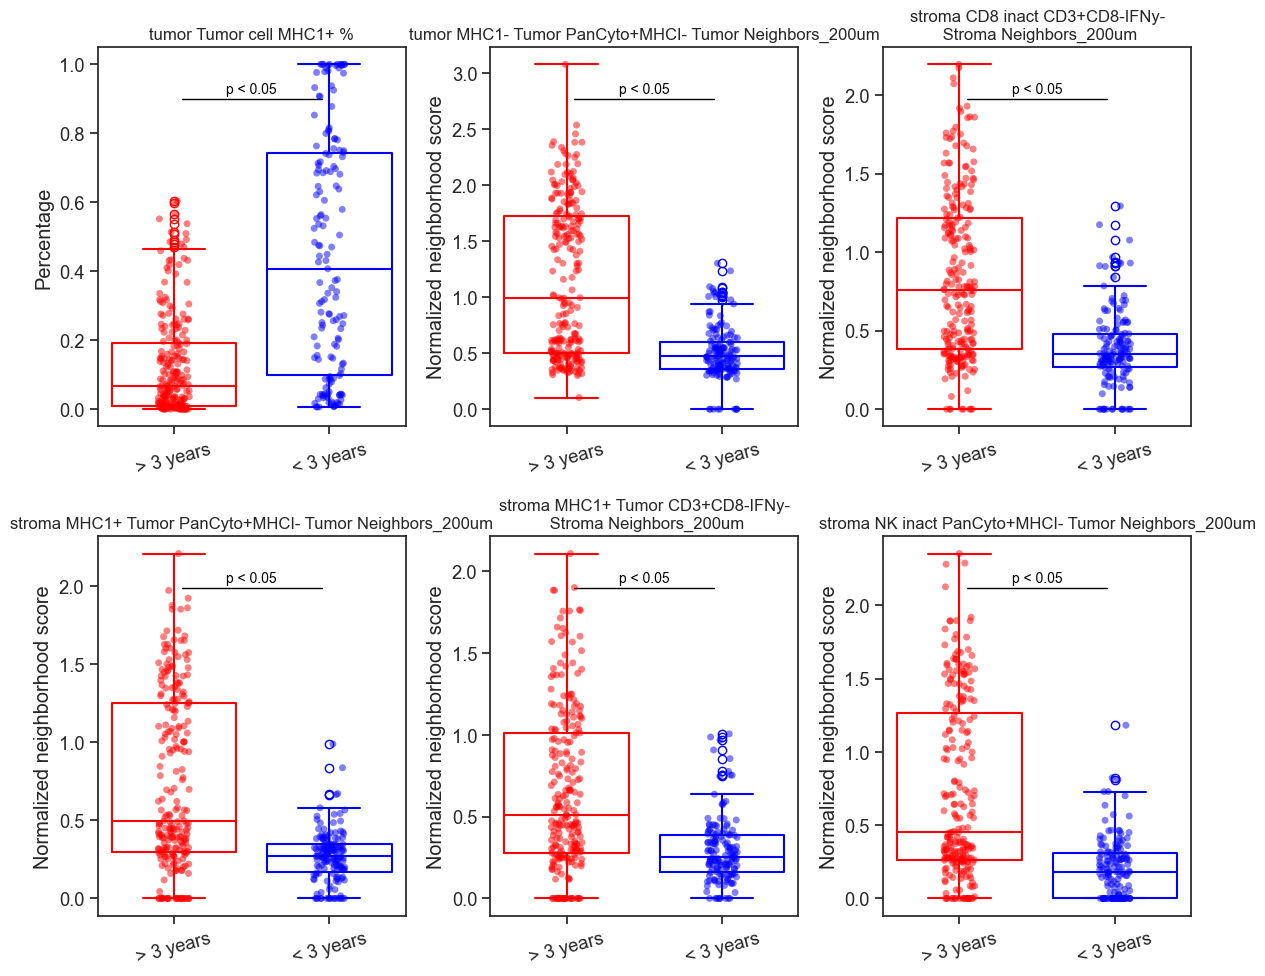

In [38]:
# Set seaborn style and font scale
sns.set(font_scale=1.2)
sns.set_style("ticks")
from scipy.stats import mannwhitneyu

# Function to perform Wilcoxon test and add significance bars
def add_significance_bars(group1, group2, ax):
    statistic, p_value = mannwhitneyu(group1, group2)
    if p_value < 0.05:
        max_y = max(max(group1), max(group2))
        significance_height = max_y - 0.1 * max_y  # Adjust the height of significance bars relative to the maximum y-value
        ax.plot([0.05, 0.95], [significance_height, significance_height], color='black', lw=1)  # Add significance bar if p-value is significant
        ax.text(0.5, significance_height * 1.01, 'p < 0.05', ha='center', va='bottom', color='black', fontsize=10)


# Create a figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(12, 10))

# Flatten the axes array for easier iteration
axes = axes.flatten()

X = pd.read_csv('/scratch/gh8sj/brown_nsclc/data/output_data/q3_dfs_target_neighbor_center_cell_act.csv',index_col=0)
X['survival group'] = pd.Categorical(X['survival group'], categories=['> 3 years', '< 3 years'], ordered=True)
X.sort_values('survival group', inplace=True)

# Iterate over the first four items in x_loadings index
for i, col in enumerate(loadings_vips.index[:6]):
    # Subset the melted DataFrame for the current column
    melted_df = X.melt(id_vars=['survival group', 'patient'], value_vars=[col])
    
    # Draw violin plot for the current column on the corresponding subplot
    cols_to_keep = col
    melted_df = X.melt(id_vars = ['survival group','patient'], value_vars= cols_to_keep)
    groups = sorted(melted_df['survival group'].unique(), reverse=False)
    groups = groups[::-1]
    sns.boxplot(data=X, x = 'survival group', y = cols_to_keep,  hue_order = groups, hue="survival group", fill=False,
               palette={"> 3 years": "red", "< 3 years": "blue"}, legend = True, ax = axes[i])
    sns.stripplot(data=X, x = 'survival group', y = cols_to_keep, alpha=0.5, legend=False,  palette={"> 3 years": "red", "< 3 years": "blue"}, ax = axes[i])  # Jitterplot
    
    # Set legend
    
    #axes[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[i].legend().remove()
    
    # Rotate x-axis labels
    axes[i].tick_params(axis='x', rotation=15)
    #axes[i].set_xticklabels([])
    
    # Set x-axis and y-axis labels
    axes[i].set_xlabel('')
    if 'Neighbors' in col:
        axes[i].set_ylabel('Normalized neighborhood score')
    else:
        axes[i].set_ylabel('Percentage')
        
    split_index = col.find('IFNy-')
    if split_index != -1:
        title_lines = [col[:split_index + 5], col[split_index + 5:]]
        axes[i].set_title('\n'.join(title_lines), size=12)
    else:
        axes[i].set_title(col, size=12)
        
        
    # Perform Wilcoxon test and add significance bars
    group1 = X[X['survival group'] == "> 3 years"][col]
    group2 = X[X['survival group'] == "< 3 years"][col]
    add_significance_bars(group1, group2, axes[i])
        
# Adjust layout
plt.tight_layout()
#plt.savefig('/home/gh8sj/projects/gabe_kate_method/figures/nsclc/final_figures/fig_7e_univariate.pdf', format='pdf')
#plt.savefig('/home/gh8sj/projects/gabe_kate_method/figures/nsclc/final_figures/fig_7e_univariate.png', format='png', bbox_inches = 'tight')
plt.savefig('/scratch/gh8sj/kate_gabe_paper_figures/figure6/fig6e_univariate.pdf', format = 'pdf', bbox_inches = 'tight')

# Show the plot
plt.show()

In [35]:
groups[::-1]

['< 3 years', '> 3 years']

/tmp/ipykernel_403828/4171215155.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=X, x='survival group', y=cols_to_keep, alpha=0.5, legend=False,
/tmp/ipykernel_403828/4171215155.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=X, x='survival group', y=cols_to_keep, alpha=0.5, legend=False,
/tmp/ipykernel_403828/4171215155.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=X, x='survival group', y=cols_to_keep, alpha=0.5, legend=False,
/tmp/ipykernel_403828/4171215155.py:42: FutureWarning: 

Passing `palette` w

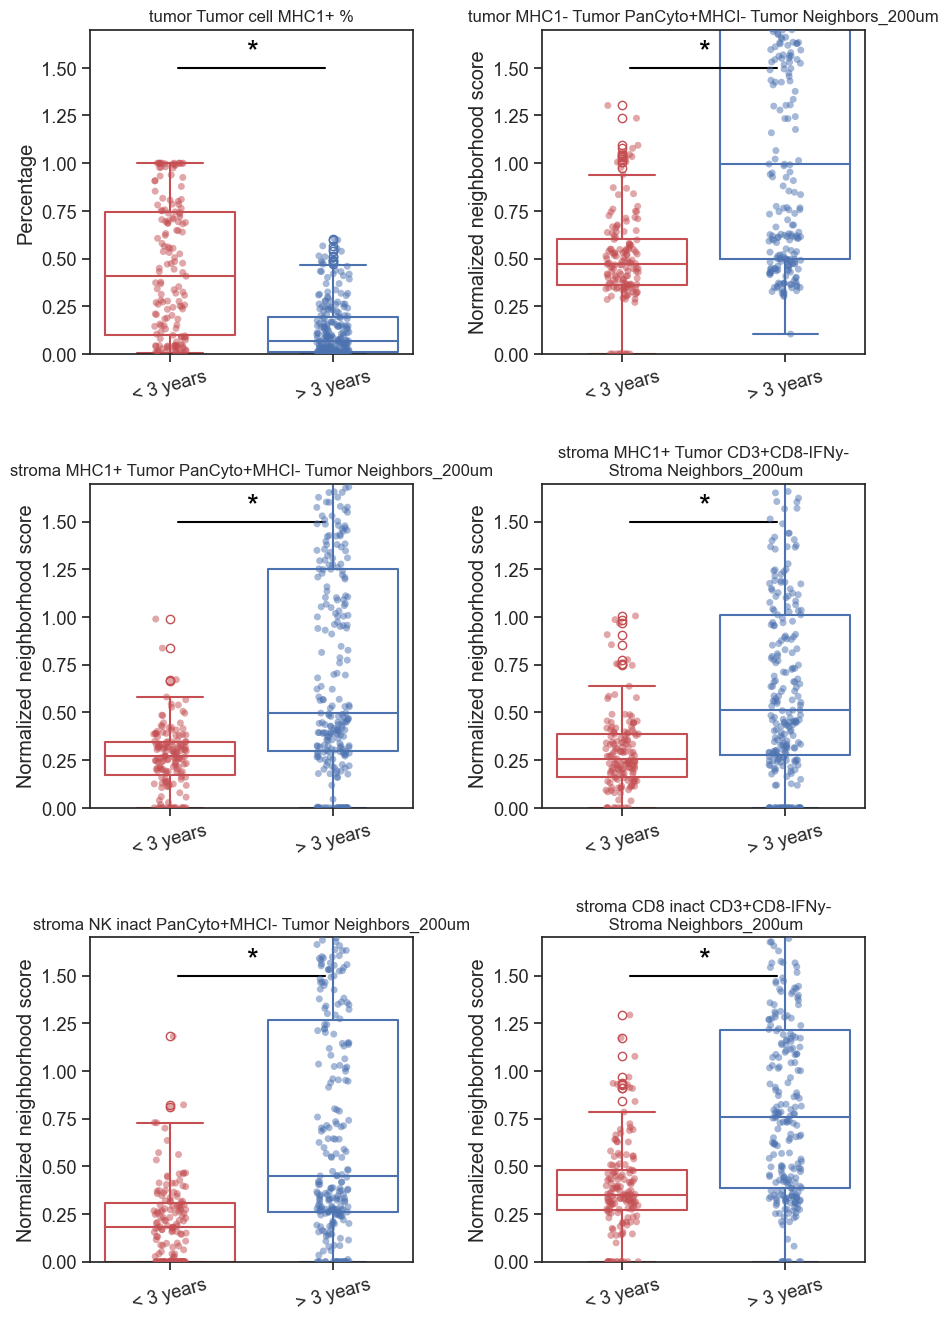

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import mannwhitneyu

# Set seaborn style and font scale
sns.set(font_scale=1.2)
sns.set_style("ticks")

# Create a figure with subplots
fig, axes = plt.subplots(3, 2, figsize=(10, 16))
fig.subplots_adjust(hspace=0.4, wspace=0.4)



# Flatten the axes array for easier iteration
axes = axes.flatten()

X = pd.read_csv('/scratch/gh8sj/brown_nsclc/data/output_data/q3_dfs_target_neighbor_center_cell_act.csv',index_col=0)

# Function to perform Wilcoxon test and add significance bars
def add_significance_bars(group1, group2, ax):
    statistic, p_value = mannwhitneyu(group1, group2)
    if p_value < 0.05:
        ax.plot([0.05, 0.95], [1.5, 1.5], color='black', lw=1.5)  # Add significance bar if p-value is significant
        ax.text(.5, 1.5, '*', ha='center', va='bottom', color='black', fontsize=22)


# Iterate over the first four items in x_loadings index
for i, col in enumerate(x_loadings.index[:6]):
    # Subset the melted DataFrame for the current column
    melted_df = X.melt(id_vars=['survival group', 'patient'], value_vars=[col])
    
    # Draw violin plot for the current column on the corresponding subplot
    cols_to_keep = col
    melted_df = X.melt(id_vars = ['survival group','patient'], value_vars= cols_to_keep)
    groups = sorted(melted_df['survival group'].unique(), reverse=True)
    
    sns.boxplot(data=X, x='survival group', y=cols_to_keep, hue_order=groups, hue='survival group',
                fill=False, palette={"< 3 years": "r", "> 3 years": "b"}, legend=True, ax=axes[i])
    
    sns.stripplot(data=X, x='survival group', y=cols_to_keep, alpha=0.5, legend=False,
                  palette={"< 3 years": "r", "> 3 years": "b"}, ax=axes[i])  # Jitterplot

    # Remove legend
    axes[i].legend().remove()
    
    # Rotate x-axis labels
    axes[i].tick_params(axis='x', rotation=15)
    
    # Set x-axis and y-axis labels
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].set_ylim(0, 1.7)
    

    # Set x-axis and y-axis labels
    axes[i].set_xlabel('')
    if 'Neighbors' in col:
        axes[i].set_ylabel('Normalized neighborhood score')
    else:
        axes[i].set_ylabel('Percentage')
        
    split_index = col.find('IFNy-')
    if split_index != -1:
        title_lines = [col[:split_index + 5], col[split_index + 5:]]
        axes[i].set_title('\n'.join(title_lines), size=12)
    else:
        axes[i].set_title(col, size=12)
    
    # Perform Wilcoxon test and add significance bars
    group1 = X[X['survival group'] == "< 3 years"][col]
    group2 = X[X['survival group'] == "> 3 years"][col]
    add_significance_bars(group1, group2, axes[i])

# Adjust layout
#plt.tight_layout()
plt.savefig('/home/gh8sj/projects/gabe_kate_method/figures/nsclc/final_figures/fig_7e_univariate.pdf', format='pdf')

# Show the plot
plt.show()

In [53]:
group1

17-199_[43424,7543]     0.641256
17-199_[43424,9043]     0.509025
17-199_[44446,10543]    0.463989
17-199_[44675,12043]    0.664667
17-199_[45431,7543]     0.313793
                          ...   
17-549_[47930,14449]    0.302921
17-549_[47930,15949]    0.427463
17-549_[49937,11689]    0.692691
17-549_[49937,13189]    0.274256
17-549_[49937,14689]    0.282949
Name: stroma CD8 inact CD3+CD8-IFNy- Stroma Neighbors_200um, Length: 151, dtype: float64

In [54]:
group2

17-185_[46209,14980]    0.914780
17-185_[46405,13480]    0.495806
17-185_[46736,11980]    0.760841
17-185_[47168,10480]    0.667971
17-185_[48216,14980]    0.486208
                          ...   
17-536_[47032,15356]    1.655435
17-536_[47032,16856]    1.895530
17-536_[49039,10345]    0.607863
17-536_[49039,11845]    0.471891
17-536_[49039,13345]    0.775926
Name: stroma CD8 inact CD3+CD8-IFNy- Stroma Neighbors_200um, Length: 238, dtype: float64

# Network diagram for correlations

In [1]:
### SEE DFS_network_correlations_doc

## remove all neighbor features

In [25]:
X = pd.read_csv('/scratch/gh8sj/brown_nsclc/data/output_data/q3_dfs_target_neighbor_center_cell_act.csv',index_col=0)


In [13]:
X = pd.read_csv('/scratch/gh8sj/brown_nsclc/data/output_data/q3_dfs_target_neighbor_center_cell_act.csv',index_col=0)
y_str = X['survival group']
X = X.drop(columns=['survival group', 'patient'])
y = y_str.apply(lambda x: 1 if x == '> 3 years' else -1)
y
#X = X.iloc[:,8:]
X = X.iloc[:, list(range(0, 8)) + list(range(264, 272))]


In [14]:
X.columns

Index(['tumor CD8 IFNg+ %', 'tumor Number of CD8s', 'tumor CD3 IFNg+ %',
       'tumor Number of CD3s', 'tumor NK IFNg+ %', 'tumor Number of NKs',
       'tumor Tumor cell MHC1+ %', 'tumor Number of Tumor cells',
       'stroma CD8 IFNg+ %', 'stroma Number of CD8s', 'stroma CD3 IFNg+ %',
       'stroma Number of CD3s', 'stroma NK IFNg+ %', 'stroma Number of NKs',
       'stroma Tumor cell MHC1+ %', 'stroma Number of Tumor cells'],
      dtype='object')

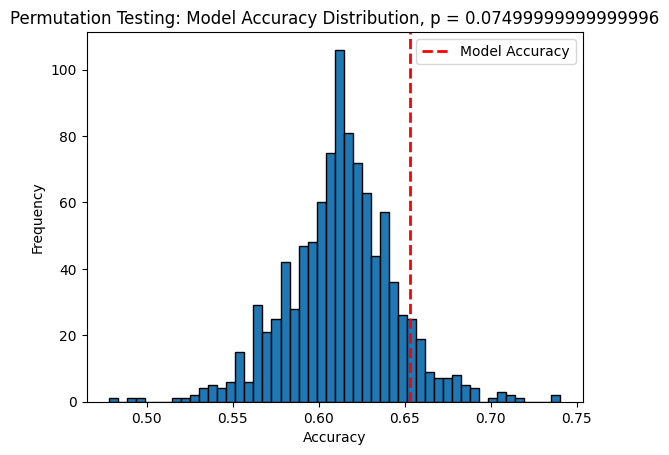

In [16]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import bisect
from scipy import stats
from scipy.stats import boxcox

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from pyopls import OPLS
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict, LeaveOneOut
from sklearn.metrics import r2_score, accuracy_score


def count_values_greater_than(sorted_list, target_value):
    # Use bisect_right to find the index of the first element greater than the target_value
    index = bisect.bisect_right(sorted_list, target_value)
    
    # The count of values greater than the target_value is the length of the list minus the index
    count = len(sorted_list) - index
    
    return count

def round_to_sign(value):
    if value >= 0:
        return np.ceil(value)
    else:
        return np.floor(value)




X = X.fillna(0)
X = stats.zscore(X, ddof = 1)
# do you orthogoranlize all the permutations? -> yes



# Generate some example data
np.random.seed(42)

# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
opls = OPLS(2) # 1 components
Z = opls.fit_transform(X, y)
pls_model = PLSRegression(2)


pls_model.fit(Z, y)
#y_pred= pls.predict(X)
processed_y_pred = cross_val_predict(pls_model, Z, y, cv=5)

                           
processed_q_squared = r2_score(y, processed_y_pred) 
processed_dq_squared = r2_score(y, np.clip(processed_y_pred, -1, 1))  # 0.984
processed_accuracy = accuracy_score(y, np.sign(processed_y_pred))  # 1.0
processed_accuracy_rounded = round(processed_accuracy,2)

variance_in_x = np.var(pls_model.x_scores_, axis = 0) 
total_variance_in_x = np.var(Z, axis = 0)
# normalize variance by total variance:
#fractions_of_explained_variance = variance_in_x / total_variance_in_x

r2_X = opls.score(X)  # 7.8e-12 (most variance is removed)


# Number of permutations
num_permutations = 1000

# List to store permutation accuracies
permuted_accuracies = []

# Permutation testing loop
for _ in range(num_permutations):
    # Randomly permute the labels
    permuted_labels = np.random.permutation(y)
    
    
#processed_y_pred = cross_val_predict(pls, Z, y, cv=1000)
#processed_q_squared = r2_score(y, processed_y_pred)  # 0.981
#processed_dq_squared = r2_score(y, np.clip(processed_y_pred, -1, 1))  # 0.984
#processed_accuracy = accuracy_score(y, np.sign(processed_y_pred))  # 1.0
    opls = OPLS(2) # 1 components
    Z_i = opls.fit_transform(X, permuted_labels)

    #permuted_model.fit(X, permuted_labels)
    pls = PLSRegression(1)
    permuted_pred = cross_val_predict(pls, Z_i, permuted_labels, cv=5) # I should change this to something smaller, leave one out would literally take foever
    # Make predictions with the permuted model
    #permuted_predictions = permuted_model.predict(X)
    
    # Calculate accuracy and store in the list
    permuted_pred = [round_to_sign(value) for value in permuted_pred]# Round each value in the list based on the specified rules


    permuted_accuracy = accuracy_score(y, permuted_pred)
    permuted_accuracies.append(permuted_accuracy)

    
permuted_accuracies = pd.Series(np.sort(permuted_accuracies), index = range(1000))
result_count = count_values_greater_than(permuted_accuracies, processed_accuracy)
p = 1-(1000-result_count)/1000
p_round = round(p,3)

# Plotting the histogram
plt.hist(permuted_accuracies, bins=50, edgecolor='black')
plt.axvline(x=processed_accuracy, color='red', linestyle='dashed', linewidth=2, label='Model Accuracy')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title(f'Permutation Testing: Model Accuracy Distribution, p = {p}')
plt.legend()
plt.show()

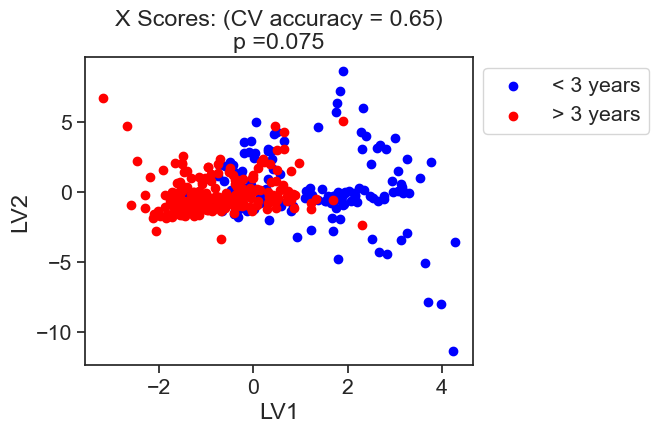

In [17]:
#plt.figure(1)
#df = pd.DataFrame(np.column_stack([pls_model.x_scores_, opls.T_ortho_[:, 0]]),
#                  index=y.index, columns=['t', 't_ortho']) 
import matplotlib.colors as colors
sns.set(font_scale = 1.4)
sns.set_style("ticks")
plt.figure(figsize=(5, 4)) 

df = pd.DataFrame(np.column_stack([pls_model.x_scores_]),
                  index=y.index, columns=['lv1', 'lv2'])       
pos_df = df[y==1]
neg_df = df[y==-1]
plt.scatter(neg_df['lv1'], neg_df['lv2'], c='blue', label='< 3 years')
plt.scatter(pos_df['lv1'], pos_df['lv2'], c='red', label='> 3 years')
plt.title(f'X Scores: (CV accuracy = {processed_accuracy_rounded})\np ={p_round}')
#plt.xlabel(f'PC1 X_var explained = {round(np.var(df.iloc[:,0])/sum(np.var(df.iloc[:,:], axis = None)), 3)}')
plt.xlabel('LV1')
#plt.ylabel(f'PC2 X_var explained = {round(np.var(df.iloc[:,1])/sum(np.var(df.iloc[:,:], axis = None)), 3)}')
plt.ylabel('LV2')
plt.legend(bbox_to_anchor = (1,1))
plt.show()

Text(0.5, 1.0, 'VIPs for oPLSDA model')

<Figure size 400x600 with 0 Axes>

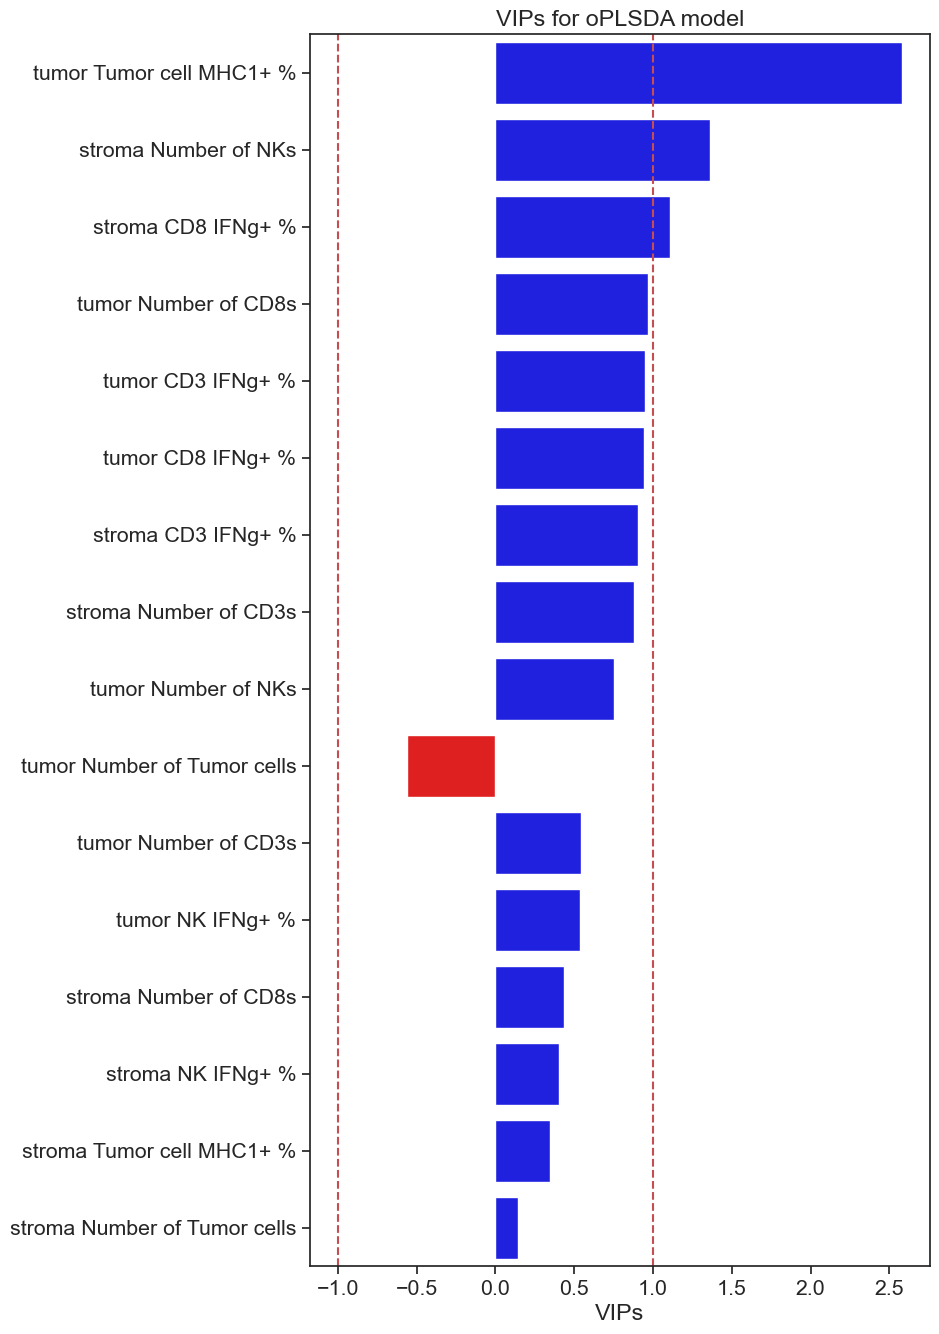

In [19]:

# lets try to make a VIP score with the same logic as Rem's code:
# Calculate VIP scores
def vip_efficient(model):
    t = model.x_scores_
    w = model.x_weights_ # replace with x_rotations_ if needed
    q = model.y_loadings_ 
    features_, _ = w.shape
    vip = np.zeros(shape=(features_,))
    inner_sum = np.diag(t.T @ t @ q.T @ q)
    SS_total = np.sum(inner_sum)
    vip = np.sqrt(features_*(w**2 @ inner_sum)/ SS_total)
    return vip

vips = vip_efficient(pls_model)

sns.set(font_scale = 1.4)
sns.set_style("ticks")
plt.figure(figsize=(4, 6)) 
plt.figure(figsize=(8, 16)) 


loadings_vips = pd.DataFrame(pls_model.x_loadings_[:,0].flatten(), index= X.columns, columns = ['loadings'])
loadings_vips['VIPs'] = vips
loadings_vips['color'] = np.where(loadings_vips['loadings'] > 0, '> 3 years', '< 3 years')
colors = {'< 3 years': 'red', '> 3 years': 'blue'}

loadings_vips = loadings_vips.sort_values(by = 'VIPs', ascending=False)
for i in loadings_vips.index:
    if loadings_vips.loc[i,'loadings'] < 0:
        loadings_vips.loc[i,'VIPs'] = loadings_vips.loc[i,'VIPs']*-1
ax = sns.barplot(data = loadings_vips, x=loadings_vips['VIPs'],y = loadings_vips.index, hue = 'color', palette = colors)
ax.axvline(x = -1, color = 'r', linestyle='--')
ax.axvline(x = 1, color = 'r', linestyle='--')
ax.legend().set_visible(False)
plt.ylabel('')
#ax.set_yticklabels([])
#plt.savefig('/home/gh8sj/projects/gabe_kate_method/figures/nsclc/final_figures/fig_7d_VIPS.pdf',format='pdf')
plt.title('VIPs for oPLSDA model')

## lasso not needed since not many features

# how about if I remove the non neighbor features

## Non LASSO

In [95]:
X = pd.read_csv('/scratch/gh8sj/brown_nsclc/data/output_data/q3_dfs_target_neighbor_center_cell_act.csv',index_col=0)
y_str = X['survival group']
X = X.drop(columns=['survival group', 'patient'])
y = y_str.apply(lambda x: 1 if x == '> 3 years' else -1)
y
#X = X.iloc[:,8:]
X = X.iloc[:, list(range(8, 264)) + list(range(272, len(X.columns)))]


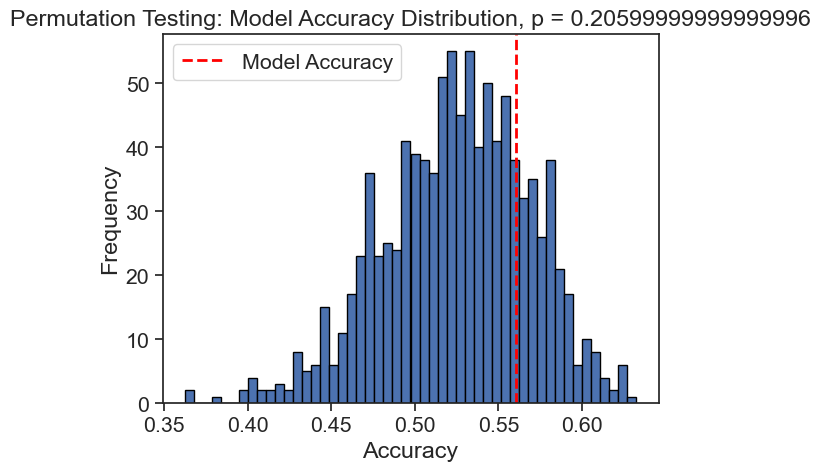

In [97]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import bisect

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from pyopls import OPLS
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict, LeaveOneOut
from sklearn.metrics import r2_score, accuracy_score


def count_values_greater_than(sorted_list, target_value):
    # Use bisect_right to find the index of the first element greater than the target_value
    index = bisect.bisect_right(sorted_list, target_value)
    
    # The count of values greater than the target_value is the length of the list minus the index
    count = len(sorted_list) - index
    
    return count

def round_to_sign(value):
    if value >= 0:
        return np.ceil(value)
    else:
        return np.floor(value)




X = X.fillna(0)
X = stats.zscore(X, ddof = 1)
# do you orthogoranlize all the permutations? -> yes



# Generate some example data
np.random.seed(42)

# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
opls = OPLS(2) # 1 components
Z = opls.fit_transform(X, y)
pls_model = PLSRegression(2)


pls_model.fit(Z, y)
#y_pred= pls.predict(X)
processed_y_pred = cross_val_predict(pls_model, Z, y, cv=5)

                           
processed_q_squared = r2_score(y, processed_y_pred) 
processed_dq_squared = r2_score(y, np.clip(processed_y_pred, -1, 1))  # 0.984
processed_accuracy = accuracy_score(y, np.sign(processed_y_pred))  # 1.0
processed_accuracy_rounded = round(processed_accuracy,2)

variance_in_x = np.var(pls_model.x_scores_, axis = 0) 
total_variance_in_x = np.var(Z, axis = 0)
# normalize variance by total variance:
#fractions_of_explained_variance = variance_in_x / total_variance_in_x

r2_X = opls.score(X)  # 7.8e-12 (most variance is removed)


# Number of permutations
num_permutations = 1000

# List to store permutation accuracies
permuted_accuracies = []

# Permutation testing loop
for _ in range(num_permutations):
    # Randomly permute the labels
    permuted_labels = np.random.permutation(y)
    
    
#processed_y_pred = cross_val_predict(pls, Z, y, cv=1000)
#processed_q_squared = r2_score(y, processed_y_pred)  # 0.981
#processed_dq_squared = r2_score(y, np.clip(processed_y_pred, -1, 1))  # 0.984
#processed_accuracy = accuracy_score(y, np.sign(processed_y_pred))  # 1.0
    opls = OPLS(2) # 1 components
    Z_i = opls.fit_transform(X, permuted_labels)

    #permuted_model.fit(X, permuted_labels)
    pls = PLSRegression(1)
    permuted_pred = cross_val_predict(pls, Z_i, permuted_labels, cv=5) # I should change this to something smaller, leave one out would literally take foever
    # Make predictions with the permuted model
    #permuted_predictions = permuted_model.predict(X)
    
    # Calculate accuracy and store in the list
    permuted_pred = [round_to_sign(value) for value in permuted_pred]# Round each value in the list based on the specified rules


    permuted_accuracy = accuracy_score(y, permuted_pred)
    permuted_accuracies.append(permuted_accuracy)

    
permuted_accuracies = pd.Series(np.sort(permuted_accuracies), index = range(1000))
result_count = count_values_greater_than(permuted_accuracies, processed_accuracy)
p = 1-(1000-result_count)/1000
p_round = round(p,3)

# Plotting the histogram
plt.hist(permuted_accuracies, bins=50, edgecolor='black')
plt.axvline(x=processed_accuracy, color='red', linestyle='dashed', linewidth=2, label='Model Accuracy')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title(f'Permutation Testing: Model Accuracy Distribution, p = {p}')
plt.legend()
plt.show()

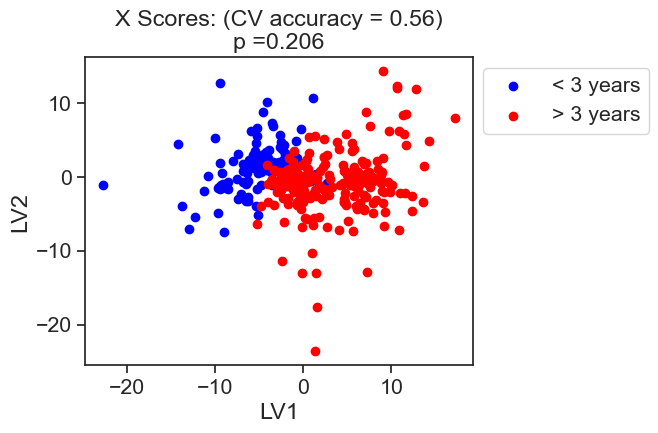

In [98]:
#plt.figure(1)
#df = pd.DataFrame(np.column_stack([pls_model.x_scores_, opls.T_ortho_[:, 0]]),
#                  index=y.index, columns=['t', 't_ortho']) 
import matplotlib.colors as colors
sns.set(font_scale = 1.4)
sns.set_style("ticks")
plt.figure(figsize=(5, 4)) 

df = pd.DataFrame(np.column_stack([pls_model.x_scores_]),
                  index=y.index, columns=['lv1', 'lv2'])       
pos_df = df[y==1]
neg_df = df[y==-1]
plt.scatter(neg_df['lv1'], neg_df['lv2'], c='blue', label='< 3 years')
plt.scatter(pos_df['lv1'], pos_df['lv2'], c='red', label='> 3 years')
plt.title(f'X Scores: (CV accuracy = {processed_accuracy_rounded})\np ={p_round}')
#plt.xlabel(f'PC1 X_var explained = {round(np.var(df.iloc[:,0])/sum(np.var(df.iloc[:,:], axis = None)), 3)}')
plt.xlabel('LV1')
#plt.ylabel(f'PC2 X_var explained = {round(np.var(df.iloc[:,1])/sum(np.var(df.iloc[:,:], axis = None)), 3)}')
plt.ylabel('LV2')
plt.legend(bbox_to_anchor = (1,1))
plt.show()

Text(0.5, 1.0, 'VIPs for oPLSDA model')

<Figure size 400x600 with 0 Axes>

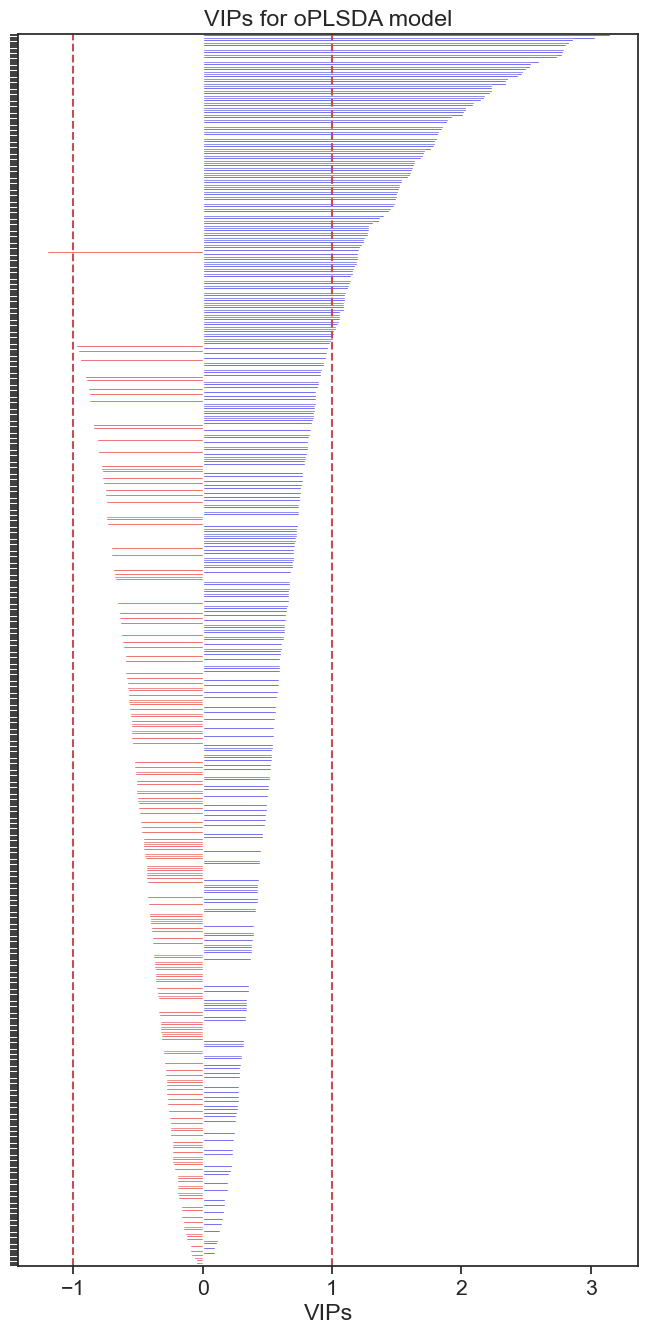

In [106]:

# lets try to make a VIP score with the same logic as Rem's code:
# Calculate VIP scores
def vip_efficient(model):
    t = model.x_scores_
    w = model.x_weights_ # replace with x_rotations_ if needed
    q = model.y_loadings_ 
    features_, _ = w.shape
    vip = np.zeros(shape=(features_,))
    inner_sum = np.diag(t.T @ t @ q.T @ q)
    SS_total = np.sum(inner_sum)
    vip = np.sqrt(features_*(w**2 @ inner_sum)/ SS_total)
    return vip

vips = vip_efficient(pls_model)

sns.set(font_scale = 1.4)
sns.set_style("ticks")
plt.figure(figsize=(4, 6)) 
plt.figure(figsize=(8, 16)) 


loadings_vips = pd.DataFrame(pls_model.x_loadings_[:,0].flatten(), index= X.columns, columns = ['loadings'])
loadings_vips['VIPs'] = vips
loadings_vips['color'] = np.where(loadings_vips['loadings'] > 0, '> 3 years', '< 3 years')
colors = {'< 3 years': 'red', '> 3 years': 'blue'}

loadings_vips = loadings_vips.sort_values(by = 'VIPs', ascending=False)
for i in loadings_vips.index:
    if loadings_vips.loc[i,'loadings'] < 0:
        loadings_vips.loc[i,'VIPs'] = loadings_vips.loc[i,'VIPs']*-1
ax = sns.barplot(data = loadings_vips, x=loadings_vips['VIPs'],y = loadings_vips.index, hue = 'color', palette = colors)
ax.axvline(x = -1, color = 'r', linestyle='--')
ax.axvline(x = 1, color = 'r', linestyle='--')
ax.legend().set_visible(False)
plt.ylabel('')
ax.set_yticklabels([])
#plt.savefig('/home/gh8sj/projects/gabe_kate_method/figures/nsclc/final_figures/fig_7d_VIPS.pdf',format='pdf')
plt.title('VIPs for oPLSDA model')

## LASSO

In [78]:
X = pd.read_csv('/scratch/gh8sj/brown_nsclc/data/output_data/q3_dfs_target_neighbor_center_cell_act.csv',index_col=0)
y_str = X['survival group']
X = X.drop(columns=['survival group', 'patient'])
y = y_str.apply(lambda x: 1 if x == '> 3 years' else -1)
y

17-199_[43424,7543]    -1
17-199_[43424,9043]    -1
17-199_[44446,10543]   -1
17-199_[44675,12043]   -1
17-199_[45431,7543]    -1
                       ..
17-536_[47032,15356]    1
17-536_[47032,16856]    1
17-536_[49039,10345]    1
17-536_[49039,11845]    1
17-536_[49039,13345]    1
Name: survival group, Length: 389, dtype: int64

In [79]:
#X = X.iloc[:,8:]
X = X.iloc[:, list(range(8, 264)) + list(range(272, len(X.columns)))]


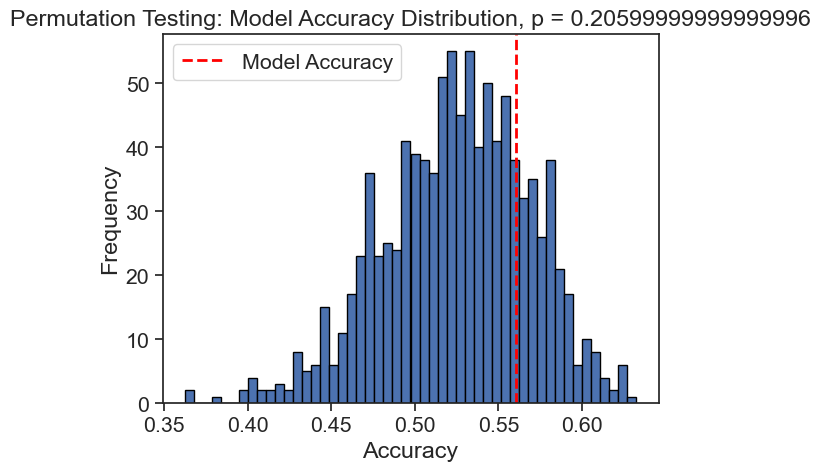

In [96]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import bisect

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from pyopls import OPLS
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict, LeaveOneOut
from sklearn.metrics import r2_score, accuracy_score


def count_values_greater_than(sorted_list, target_value):
    # Use bisect_right to find the index of the first element greater than the target_value
    index = bisect.bisect_right(sorted_list, target_value)
    
    # The count of values greater than the target_value is the length of the list minus the index
    count = len(sorted_list) - index
    
    return count

def round_to_sign(value):
    if value >= 0:
        return np.ceil(value)
    else:
        return np.floor(value)




X = X.fillna(0)
X = stats.zscore(X, ddof = 1)
# do you orthogoranlize all the permutations? -> yes



# Generate some example data
np.random.seed(42)

# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
opls = OPLS(2) # 1 components
Z = opls.fit_transform(X, y)
pls_model = PLSRegression(2)


pls_model.fit(Z, y)
#y_pred= pls.predict(X)
processed_y_pred = cross_val_predict(pls_model, Z, y, cv=5)

                           
processed_q_squared = r2_score(y, processed_y_pred) 
processed_dq_squared = r2_score(y, np.clip(processed_y_pred, -1, 1))  # 0.984
processed_accuracy = accuracy_score(y, np.sign(processed_y_pred))  # 1.0
processed_accuracy_rounded = round(processed_accuracy,2)

variance_in_x = np.var(pls_model.x_scores_, axis = 0) 
total_variance_in_x = np.var(Z, axis = 0)
# normalize variance by total variance:
#fractions_of_explained_variance = variance_in_x / total_variance_in_x

r2_X = opls.score(X)  # 7.8e-12 (most variance is removed)


# Number of permutations
num_permutations = 1000

# List to store permutation accuracies
permuted_accuracies = []

# Permutation testing loop
for _ in range(num_permutations):
    # Randomly permute the labels
    permuted_labels = np.random.permutation(y)
    
    
#processed_y_pred = cross_val_predict(pls, Z, y, cv=1000)
#processed_q_squared = r2_score(y, processed_y_pred)  # 0.981
#processed_dq_squared = r2_score(y, np.clip(processed_y_pred, -1, 1))  # 0.984
#processed_accuracy = accuracy_score(y, np.sign(processed_y_pred))  # 1.0
    opls = OPLS(2) # 1 components
    Z_i = opls.fit_transform(X, permuted_labels)

    #permuted_model.fit(X, permuted_labels)
    pls = PLSRegression(1)
    permuted_pred = cross_val_predict(pls, Z_i, permuted_labels, cv=5) # I should change this to something smaller, leave one out would literally take foever
    # Make predictions with the permuted model
    #permuted_predictions = permuted_model.predict(X)
    
    # Calculate accuracy and store in the list
    permuted_pred = [round_to_sign(value) for value in permuted_pred]# Round each value in the list based on the specified rules


    permuted_accuracy = accuracy_score(y, permuted_pred)
    permuted_accuracies.append(permuted_accuracy)

    
permuted_accuracies = pd.Series(np.sort(permuted_accuracies), index = range(1000))
result_count = count_values_greater_than(permuted_accuracies, processed_accuracy)
p = 1-(1000-result_count)/1000
p_round = round(p,3)

# Plotting the histogram
plt.hist(permuted_accuracies, bins=50, edgecolor='black')
plt.axvline(x=processed_accuracy, color='red', linestyle='dashed', linewidth=2, label='Model Accuracy')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title(f'Permutation Testing: Model Accuracy Distribution, p = {p}')
plt.legend()
plt.show()

In [81]:
print(lassocv.alpha_, sum(x != 0 for x in lassocv.coef_))

0.1 11


In [82]:
selected_features

array(['tumor MHC1+ Tumor PanCyto+MHCI+ Tumor Neighbors_30um',
       'tumor MHC1- Tumor PanCyto+MHCI- Stroma Neighbors_30um',
       'tumor MHC1- Tumor PanCyto+MHCI- Tumor Neighbors_200um',
       'stroma CD8 inact CD3+CD8-IFNy- Stroma Neighbors_30um',
       'stroma CD8 inact CD3+CD8-IFNy- Stroma Neighbors_200um',
       'stroma NK act CD56+CD3-IFNy+ Stroma Neighbors_30um',
       'stroma NK inact CD56+CD3-IFNy- Stroma Neighbors_200um',
       'stroma NK inact PanCyto+MHCI- Tumor Neighbors_200um',
       'stroma MHC1+ Tumor CD3+CD8-IFNy+ Stroma Neighbors_30um',
       'stroma MHC1+ Tumor PanCyto+MHCI- Tumor Neighbors_200um',
       'stroma MHC1- Tumor PanCyto+MHCI- Stroma Neighbors_30um'],
      dtype=object)

In [89]:
X = pd.read_csv('/scratch/gh8sj/brown_nsclc/data/output_data/q3_dfs_target_neighbor_center_cell_act.csv',index_col=0)
y_str = X['survival group']
X = X.drop(columns=['survival group', 'patient'])
y = y_str.apply(lambda x: 1 if x == '> 3 years' else -1)
y

17-199_[43424,7543]    -1
17-199_[43424,9043]    -1
17-199_[44446,10543]   -1
17-199_[44675,12043]   -1
17-199_[45431,7543]    -1
                       ..
17-536_[47032,15356]    1
17-536_[47032,16856]    1
17-536_[49039,10345]    1
17-536_[49039,11845]    1
17-536_[49039,13345]    1
Name: survival group, Length: 389, dtype: int64

In [90]:
#X = X.iloc[:,8:]
#X = X.iloc[:, list(range(8, 264)) + list(range(272, len(X.columns)))]
X = X.loc[:,X.columns.isin(selected_features)]


In [91]:
X

tumor MHC1+ Tumor PanCyto+MHCI+ Tumor Neighbors_30um  \
17-199_[43424,7543]                                            0.098800      
17-199_[43424,9043]                                            0.049196      
17-199_[44446,10543]                                           0.024454      
17-199_[44675,12043]                                           0.069230      
17-199_[45431,7543]                                            0.062865      
...                                                                 ...      
17-536_[47032,15356]                                           0.201946      
17-536_[47032,16856]                                           0.184300      
17-536_[49039,10345]                                           0.068563      
17-536_[49039,11845]                                           0.060644      
17-536_[49039,13345]                                           0.096207      

                      tumor MHC1- Tumor PanCyto+MHCI- Stroma Neighbors_30um  \
17-199_[43424,7543]                                            0.000000       
17-199_[43424,9043]                                            0.000000       
17-199_[44446,10543]                                           0.000000       
17-199_[44675,12043]                                           0.000000       
17-199_[45431,7543]                                            0.000000       
...                                                                 ...       
17-536_[47032,15356]                                           0.031128       
17-536_[47032,16856]                                           0.020188       
17-536_[49039,10345]                                           0.001570       
17-536_[49039,11845]                                           0.005233       
17-536_[49039,13345]                                           0.011376       

                      tumor MHC1- Tumor PanCyto+MHCI- Tumor Neighbors_200um  \
17-199_[43424,7543]                                            0.000000       
17-199_[43424,9043]                                            0.000000       
17-199_[44446,10543]                                           0.671127       
17-199_[44675,12043]                                           0.000000       
17-199_[45431,7543]                                            0.834750       
...                                                                 ...       
17-536_[47032,15356]                                           1.494037       
17-536_[47032,16856]                                           1.410250       
17-536_[49039,10345]                                           1.530029       
17-536_[49039,11845]                                           1.305532       
17-536_[49039,13345]                                           1.756844       

                      stroma CD8 inact CD3+CD8-IFNy- Stroma Neighbors_30um  \
17-199_[43424,7543]                                            0.031522      
17-199_[43424,9043]                                            0.021056      
17-199_[44446,10543]                                           0.018995      
17-199_[44675,12043]                                           0.035117      
17-199_[45431,7543]                                            0.013110      
...                                                                 ...      
17-536_[47032,15356]                                           0.210165      
17-536_[47032,16856]                                           0.250263      
17-536_[49039,10345]                                           0.131846      
17-536_[49039,11845]                                           0.153181      
17-536_[49039,13345]                                           0.068655      

                      stroma CD8 inact CD3+CD8-IFNy- Stroma Neighbors_200um  \
17-199_[43424,7543]                                            0.641256       
17-199_[43424,9043]                                            0.509025       
17-199_[44446

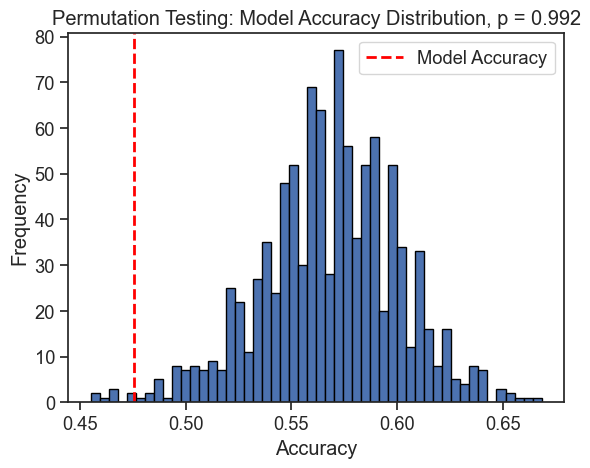

In [92]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import bisect

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from pyopls import OPLS
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict, LeaveOneOut
from sklearn.metrics import r2_score, accuracy_score


def count_values_greater_than(sorted_list, target_value):
    # Use bisect_right to find the index of the first element greater than the target_value
    index = bisect.bisect_right(sorted_list, target_value)
    
    # The count of values greater than the target_value is the length of the list minus the index
    count = len(sorted_list) - index
    
    return count

def round_to_sign(value):
    if value >= 0:
        return np.ceil(value)
    else:
        return np.floor(value)




X = X.fillna(0)
X = stats.zscore(X, ddof = 1)
# do you orthogoranlize all the permutations? -> yes



# Generate some example data
np.random.seed(42)

# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
opls = OPLS(2) # 1 components
Z = opls.fit_transform(X, y)
pls_model = PLSRegression(2)


pls_model.fit(Z, y)
#y_pred= pls.predict(X)
processed_y_pred = cross_val_predict(pls_model, Z, y, cv=5)

                           
processed_q_squared = r2_score(y, processed_y_pred) 
processed_dq_squared = r2_score(y, np.clip(processed_y_pred, -1, 1))  # 0.984
processed_accuracy = accuracy_score(y, np.sign(processed_y_pred))  # 1.0
processed_accuracy_rounded = round(processed_accuracy,2)

variance_in_x = np.var(pls_model.x_scores_, axis = 0) 
total_variance_in_x = np.var(Z, axis = 0)
# normalize variance by total variance:
#fractions_of_explained_variance = variance_in_x / total_variance_in_x

r2_X = opls.score(X)  # 7.8e-12 (most variance is removed)


# Number of permutations
num_permutations = 1000

# List to store permutation accuracies
permuted_accuracies = []

# Permutation testing loop
for _ in range(num_permutations):
    # Randomly permute the labels
    permuted_labels = np.random.permutation(y)
    
    
#processed_y_pred = cross_val_predict(pls, Z, y, cv=1000)
#processed_q_squared = r2_score(y, processed_y_pred)  # 0.981
#processed_dq_squared = r2_score(y, np.clip(processed_y_pred, -1, 1))  # 0.984
#processed_accuracy = accuracy_score(y, np.sign(processed_y_pred))  # 1.0
    opls = OPLS(2) # 1 components
    Z_i = opls.fit_transform(X, permuted_labels)

    #permuted_model.fit(X, permuted_labels)
    pls = PLSRegression(1)
    permuted_pred = cross_val_predict(pls, Z_i, permuted_labels, cv=5) # I should change this to something smaller, leave one out would literally take foever
    # Make predictions with the permuted model
    #permuted_predictions = permuted_model.predict(X)
    
    # Calculate accuracy and store in the list
    permuted_pred = [round_to_sign(value) for value in permuted_pred]# Round each value in the list based on the specified rules


    permuted_accuracy = accuracy_score(y, permuted_pred)
    permuted_accuracies.append(permuted_accuracy)

    
permuted_accuracies = pd.Series(np.sort(permuted_accuracies), index = range(1000))
result_count = count_values_greater_than(permuted_accuracies, processed_accuracy)
p = 1-(1000-result_count)/1000
p_round = round(p,3)

# Plotting the histogram
plt.hist(permuted_accuracies, bins=50, edgecolor='black')
plt.axvline(x=processed_accuracy, color='red', linestyle='dashed', linewidth=2, label='Model Accuracy')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title(f'Permutation Testing: Model Accuracy Distribution, p = {p}')
plt.legend()
plt.show()

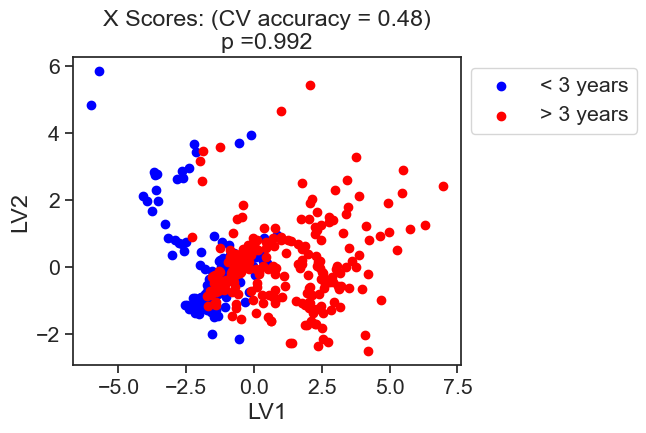

In [93]:
#plt.figure(1)
#df = pd.DataFrame(np.column_stack([pls_model.x_scores_, opls.T_ortho_[:, 0]]),
#                  index=y.index, columns=['t', 't_ortho']) 
import matplotlib.colors as colors
sns.set(font_scale = 1.4)
sns.set_style("ticks")
plt.figure(figsize=(5, 4)) 

df = pd.DataFrame(np.column_stack([pls_model.x_scores_]),
                  index=y.index, columns=['lv1', 'lv2'])       
pos_df = df[y==1]
neg_df = df[y==-1]
plt.scatter(neg_df['lv1'], neg_df['lv2'], c='blue', label='< 3 years')
plt.scatter(pos_df['lv1'], pos_df['lv2'], c='red', label='> 3 years')
plt.title(f'X Scores: (CV accuracy = {processed_accuracy_rounded})\np ={p_round}')
#plt.xlabel(f'PC1 X_var explained = {round(np.var(df.iloc[:,0])/sum(np.var(df.iloc[:,:], axis = None)), 3)}')
plt.xlabel('LV1')
#plt.ylabel(f'PC2 X_var explained = {round(np.var(df.iloc[:,1])/sum(np.var(df.iloc[:,:], axis = None)), 3)}')
plt.ylabel('LV2')
plt.legend(bbox_to_anchor = (1,1))
plt.show()

Text(0.5, 1.0, 'VIPs for oPLSDA model')

<Figure size 400x600 with 0 Axes>

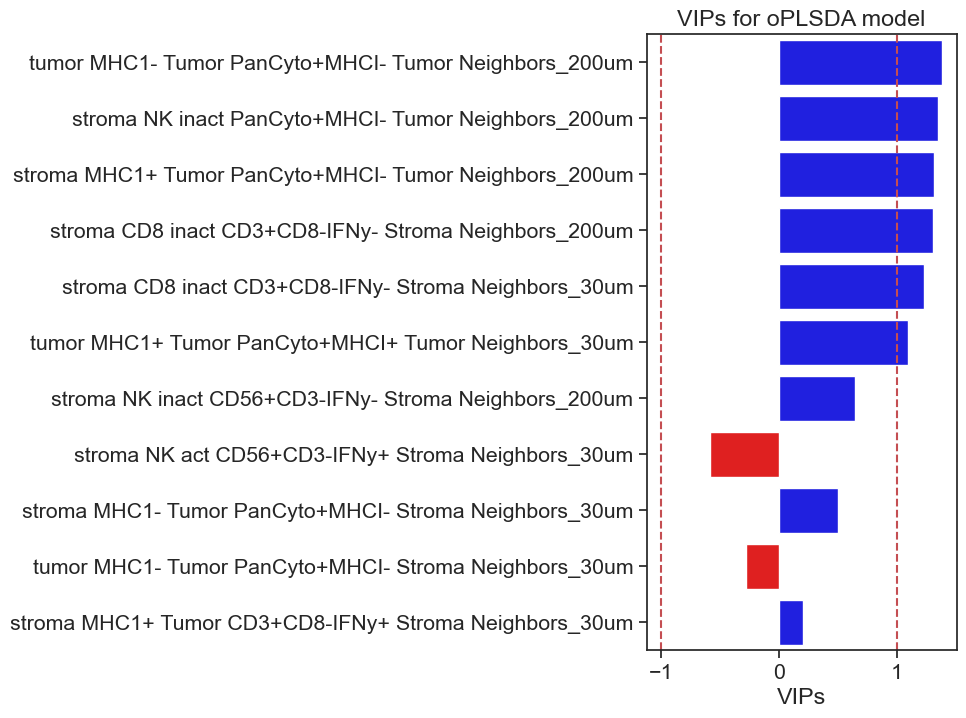

In [94]:

# lets try to make a VIP score with the same logic as Rem's code:
# Calculate VIP scores
def vip_efficient(model):
    t = model.x_scores_
    w = model.x_weights_ # replace with x_rotations_ if needed
    q = model.y_loadings_ 
    features_, _ = w.shape
    vip = np.zeros(shape=(features_,))
    inner_sum = np.diag(t.T @ t @ q.T @ q)
    SS_total = np.sum(inner_sum)
    vip = np.sqrt(features_*(w**2 @ inner_sum)/ SS_total)
    return vip

vips = vip_efficient(pls_model)

sns.set(font_scale = 1.4)
sns.set_style("ticks")
plt.figure(figsize=(4, 6)) 
plt.figure(figsize=(4, 8)) 


loadings_vips = pd.DataFrame(pls_model.x_loadings_[:,0].flatten(), index= X.columns, columns = ['loadings'])
loadings_vips['VIPs'] = vips
loadings_vips['color'] = np.where(loadings_vips['loadings'] > 0, '> 3 years', '< 3 years')
colors = {'< 3 years': 'red', '> 3 years': 'blue'}

loadings_vips = loadings_vips.sort_values(by = 'VIPs', ascending=False)
for i in loadings_vips.index:
    if loadings_vips.loc[i,'loadings'] < 0:
        loadings_vips.loc[i,'VIPs'] = loadings_vips.loc[i,'VIPs']*-1
sns.barplot(data = loadings_vips, x=loadings_vips['VIPs'],y = loadings_vips.index, hue = 'color', palette = colors)
plt.axvline(x = -1, color = 'r', linestyle='--')
plt.axvline(x = 1, color = 'r', linestyle='--')
plt.legend().set_visible(False)
plt.ylabel('')
#plt.savefig('/home/gh8sj/projects/gabe_kate_method/figures/nsclc/final_figures/fig_7d_VIPS.pdf',format='pdf')
plt.title('VIPs for oPLSDA model')

## doesn't work at all

# This normalization didn't help the model at all, lets try the pipeline without normalizing and see where that gets us

In [57]:
cd8s =['CD3+CD8+IFNy+', 'CD3+CD8+IFNy-']
cd3s = ['CD3+CD8-IFNy+', 'CD3+CD8-IFNy-']
NK  =  ['CD56+CD3-IFNy+', 'CD56+CD3-IFNy-']
tumor = ['PanCyto+MHCI+', 'PanCyto+MHCI-' ]
neighbors =  ['PanCyto+MHCI+ Neighbors_30um', 'PanCyto+MHCI- Neighbors_30um', 'CD3+CD8+IFNy+ Neighbors_30um', 'CD3+CD8+IFNy- Neighbors_30um', 'CD3+CD8-IFNy+ Neighbors_30um', 'CD3+CD8-IFNy- Neighbors_30um', 'CD56+CD3-IFNy+ Neighbors_30um', 'CD56+CD3-IFNy- Neighbors_30um', 'PanCyto+MHCI+ Neighbors_200um', 'PanCyto+MHCI- Neighbors_200um', 'CD3+CD8+IFNy+ Neighbors_200um', 'CD3+CD8+IFNy- Neighbors_200um', 'CD3+CD8-IFNy+ Neighbors_200um', 'CD3+CD8-IFNy- Neighbors_200um', 'CD56+CD3-IFNy+ Neighbors_200um', 'CD56+CD3-IFNy- Neighbors_200um']

results_dict = {}
unique_patients = full_df['ROI'].unique()
for patient in unique_patients:
    patient_stats = []
    # Subset the dataframe for the current patient
    patient_data = full_df[full_df['ROI'] == patient]
    patient_code = list(patient_data.PatientID.unique())[0]
    cd8s = patient_data.loc[patient_data['CD3+CD8+'] == 1.0]
    if len(cd8s != 0):
        cd8_ifng_pos = sum(cd8s['CD3+CD8+IFNy+'] == 1.0)/(sum(cd8s['CD3+CD8+IFNy+'] == 1.0)+sum(cd8s['CD3+CD8+IFNy-'] == 1.0))
    else:
        cd8_ifng_pos = 0
    cd8_neighbor_counts = cd8s[neighbors].sum(axis=0).values.tolist()    
    cd3s = patient_data.loc[patient_data['CD3+CD8-'] == 1.0]
    if len(cd3s) != 0:
        cd3_ifng_pos = sum(cd3s['CD3+CD8-IFNy+'] == 1.0)/(sum(cd3s['CD3+CD8-IFNy+'] == 1.0)+sum(cd3s['CD3+CD8-IFNy-'] == 1.0))
    else:
        cd3_ifng_pos = 0
    cd3_neighbor_counts = cd3s[neighbors].sum(axis = 0).values.tolist()
    nks = patient_data.loc[patient_data['CD56+CD3-'] == 1.0]
    if len(nks) != 0:
        nk_ifng_pos = sum(nks['CD56+CD3-IFNy+'] == 1.0)/(sum(nks['CD56+CD3-IFNy+'] == 1.0)+sum(nks['CD56+CD3-IFNy-'] == 1.0))
    else:
        nk_ifng_pos = 0
    nk_neighbor_counts = nks[neighbors].sum(axis = 0).values.tolist()
    tumor = patient_data.loc[(patient_data['PanCyto+MHCI+'] == 1.0)| (patient_data['PanCyto+MHCI-'] == 1.0)]
    if len(tumor) != 0:
        tumor_mhci_pos = sum(tumor['PanCyto+MHCI+'] == 1.0)/(sum(tumor['PanCyto+MHCI+'] == 1.0)+sum(tumor['PanCyto+MHCI-'] == 1.0))
    else:
        tumor_mhci_pos = 0
    tumor_neighbor_counts = tumor[neighbors].sum(axis = 0).values.tolist()
    survival_group = patient_data['survival group'].value_counts().index[0]
    patient_stats.extend([cd8_ifng_pos, len(cd8s), cd3_ifng_pos, len(cd3s), nk_ifng_pos, len(nks), tumor_mhci_pos, len(tumor), survival_group, patient_code])
    full_patient_stats =  patient_stats + cd8_neighbor_counts + cd3_neighbor_counts + nk_neighbor_counts + tumor_neighbor_counts
    #patient_stats.extend([cd8_ifng_pos, cd8_neighbor_counts, cd3_ifng_pos, cd3_neighbor_counts,nk_ifng_pos, nk_neighbor_counts, tumor_mhci_pos, tumor_neighbor_counts, mutation])

    results_dict[patient] = full_patient_stats

In [58]:
def flatten_list(nested_list):
    flat_list = []
    for item in nested_list:
        if isinstance(item, list):
            flat_list.extend(flatten_list(item))
        else:
            flat_list.append(item)
    return flat_list

index_list = []
index_list.append(['CD8 IFNg+ %' ,'Number of CD8s','CD3 IFNg+ %', 'Number of CD3s','NK IFNg+ %',  'Number of NKs', 'Tumor cell MHC1+ %', 'Number of Tumor cells', 'survival_group', 'patient', ['CD8 ' + value for value in neighbors],['CD3 ' + value for value in neighbors], ['NK ' + value for value in neighbors],['Tumor ' + value for value in neighbors]])
new_index = [item for sublist in index_list for item in sublist]
flat_list = flatten_list(new_index)
results_df = pd.DataFrame(results_dict).T
results_df.columns= flat_list

results_df


CD8 IFNg+ % Number of CD8s CD3 IFNg+ % Number of CD3s  \
17-199_[43424,7543]          0.0            108         0.0           1298   
17-199_[43424,9043]          0.0            494    0.000227           4404   
17-199_[44446,10543]         0.0           1266    0.000137           7284   
17-199_[44675,12043]         0.0            485         0.0           2909   
17-199_[45431,7543]          0.0            415         0.0           1788   
...                          ...            ...         ...            ...   
17-536_[47032,15356]    0.041237            194    0.008264           1694   
17-536_[47032,16856]    0.014925            134    0.001807           1660   
17-536_[49039,10345]         0.0             58         0.0            315   
17-536_[49039,11845]         0.0             59         0.0            349   
17-536_[49039,13345]    0.083333             12         0.0             74   

                     NK IFNg+ % Number of NKs Tumor cell MHC1+ %  \
17-199_[43424,7543]    0.002899           345                1.0   
17-199_[43424,9043]         0.0           510                1.0   
17-199_[44446,10543]   0.003209           935           0.993946   
17-199_[44675,12043]   0.003704           270                1.0   
17-199_[45431,7543]         0.0          1043           0.980519   
...                         ...           ...                ...   
17-536_[47032,15356]   0.076923            39           0.484785   
17-536_[47032,16856]   0.571429            14           0.535714   
17-536_[49039,10345]        0.0            29           0.241717   
17-536_[49039,11845]        0.0            46           0.252163   
17-536_[49039,13345]        0.0            13           0.286613   

                     Number of Tumor cells survival_group patient  ...  \
17-199_[43424,7543]                    270          short  17-199  ...   
17-199_[43424,9043]                    414          short  17-199  ...   
17-199_[44446,10543]                   991          short  17-199  ...   
17-199_[44675,12043]                   478          short  17-199  ...   
17-199_[45431,7543]                    154          short  17-199  ...   
...                                    ...            ...     ...  ...   
17-536_[47032,15356]                  1906           long  17-536  ...   
17-536_[47032,16856]                  1848           long  17-536  ...   
17-536_[49039,10345]                  3169           long  17-536  ...   
17-536_[49039,11845]                  3236           long  17-536  ...   
17-536_[49039,13345]                  1113           long  17-536  ...   

                     Tumor CD56+CD3-IFNy+ Neighbors_30um  \
17-199_[43424,7543]                                  0.0   
17-199_[43424,9043]                                  0.0   
17-199_[44446,10543]                                10.0   
17-199_[44675,12043]                                 0.0   
17-199_[45431,7543]                                  0.0   
...                                                  ...   
17-536_[47032,15356]                                 2.0   
17-536_[47032,16856]                                53.0   
17-536_[49039,10345]                                 0.0   
17-536_[49039,11845]                                 0.0   
17-536_[49039,13345]                                 0.0   

                     Tumor CD56+CD3-IFNy- Neighbors_30um  \
17-199_[43424,7543]                                248.0   
17-199_[43424,9043]                                504.0   
17-199_[44446,10543]                              2286.0   
17-199_[44675,12043]                               562.0   
17-199_[45431,7543]                                298.0   
...                                                  ...   
17-536_[47032,15356]                                80.0   
17-536_[47032,16856]                                19.0   
17-536_[49039,10345]                                92.0   
17-536_[49039,11845]                               172.0 

In [59]:
for col in results_df.columns:
    if col not in ['survival_group', 'patient']:
        results_df[col] = results_df[col].astype(float)
for col in results_df.columns:
    if 'Neighbor' in str(col):
        results_df.loc[:,col] = np.log1p(results_df.loc[:,col])

In [60]:
long_survival_df = results_df.loc[results_df.survival_group == 'long',:]
short_survival_df = results_df.loc[results_df.survival_group == 'short',:]

In [61]:
len(full_df.loc[full_df['survival group'] == 'long']['patient'].unique())

18

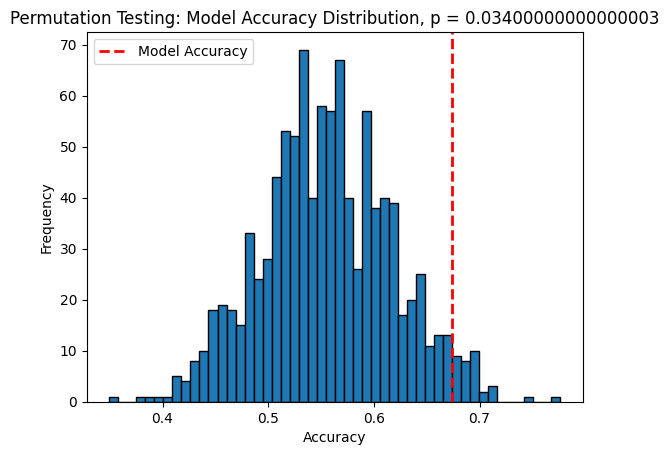

In [65]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import bisect
import scipy.stats as stats

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from pyopls import OPLS
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict, LeaveOneOut
from sklearn.metrics import r2_score, accuracy_score


def count_values_greater_than(sorted_list, target_value):
    # Use bisect_right to find the index of the first element greater than the target_value
    index = bisect.bisect_right(sorted_list, target_value)
    
    # The count of values greater than the target_value is the length of the list minus the index
    count = len(sorted_list) - index
    
    return count

def round_to_sign(value):
    if value >= 0:
        return np.ceil(value)
    else:
        return np.floor(value)



X = results_df.iloc[:,:90]
X = X.drop(columns=['survival_group', 'patient'])
y_str = results_df['survival_group']
y = y_str.apply(lambda x: 1 if x == 'short' else -1)
X = X.fillna(0)
X = stats.zscore(X)
# do you orthogoranlize all the permutations? -> yes



# Generate some example data
np.random.seed(42)

# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
opls = OPLS(2) # 1 components
Z = opls.fit_transform(X, y)
pls_model = PLSRegression(2)


pls_model.fit(Z, y)
#y_pred= pls.predict(X)
processed_y_pred = cross_val_predict(pls_model, Z, y, cv=5)

                           
processed_q_squared = r2_score(y, processed_y_pred) 
processed_dq_squared = r2_score(y, np.clip(processed_y_pred, -1, 1))  # 0.984
processed_accuracy = accuracy_score(y, np.sign(processed_y_pred))  # 1.0
processed_accuracy_rounded = round(processed_accuracy,2)

variance_in_x = np.var(pls_model.x_scores_, axis = 0) 
total_variance_in_x = np.var(Z, axis = 0)
# normalize variance by total variance:
#fractions_of_explained_variance = variance_in_x / total_variance_in_x

r2_X = opls.score(X)  # 7.8e-12 (most variance is removed)


# Number of permutations
num_permutations = 1000

# List to store permutation accuracies
permuted_accuracies = []

# Permutation testing loop
for _ in range(num_permutations):
    # Randomly permute the labels
    permuted_labels = np.random.permutation(y)
    
    
#processed_y_pred = cross_val_predict(pls, Z, y, cv=1000)
#processed_q_squared = r2_score(y, processed_y_pred)  # 0.981
#processed_dq_squared = r2_score(y, np.clip(processed_y_pred, -1, 1))  # 0.984
#processed_accuracy = accuracy_score(y, np.sign(processed_y_pred))  # 1.0
    opls = OPLS(2) # 1 components
    Z_i = opls.fit_transform(X, permuted_labels)

    #permuted_model.fit(X, permuted_labels)
    pls = PLSRegression(1)
    permuted_pred = cross_val_predict(pls, Z_i, permuted_labels, cv=5) # I should change this to something smaller, leave one out would literally take foever
    # Make predictions with the permuted model
    #permuted_predictions = permuted_model.predict(X)
    
    # Calculate accuracy and store in the list
    permuted_pred = [round_to_sign(value) for value in permuted_pred]# Round each value in the list based on the specified rules


    permuted_accuracy = accuracy_score(y, permuted_pred)
    permuted_accuracies.append(permuted_accuracy)

    
permuted_accuracies = pd.Series(np.sort(permuted_accuracies), index = range(1000))
result_count = count_values_greater_than(permuted_accuracies, processed_accuracy)
p = 1-(1000-result_count)/1000
p_round = round(p,3)

# Plotting the histogram
plt.hist(permuted_accuracies, bins=50, edgecolor='black')
plt.axvline(x=processed_accuracy, color='red', linestyle='dashed', linewidth=2, label='Model Accuracy')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title(f'Permutation Testing: Model Accuracy Distribution, p = {p}')
plt.legend()
plt.show()

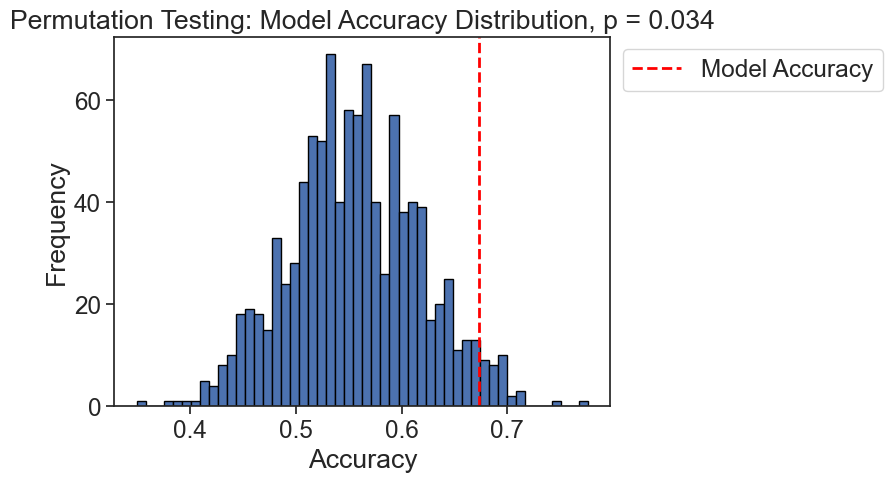

In [73]:
sns.set(font_scale = 1.6)
sns.set_style("ticks")

# Plotting the histogram
plt.hist(permuted_accuracies, bins=50, edgecolor='black')
plt.axvline(x=processed_accuracy, color='red', linestyle='dashed', linewidth=2, label='Model Accuracy')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title(f'Permutation Testing: Model Accuracy Distribution, p = {np.round(p,3)}')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

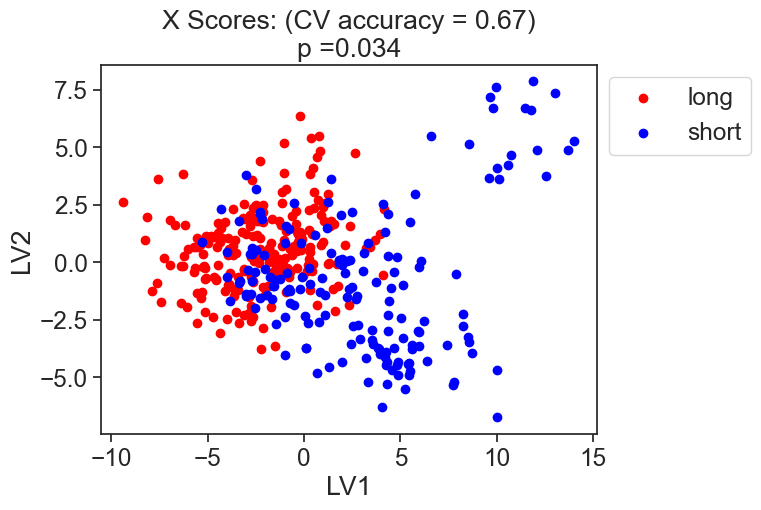

In [71]:
#plt.figure(1)
sns.set(font_scale = 1.6)
sns.set_style("ticks")
#df = pd.DataFrame(np.column_stack([pls_model.x_scores_, opls.T_ortho_[:, 0]]),
#                  index=y.index, columns=['t', 't_ortho'])                
df = pd.DataFrame(np.column_stack([pls_model.x_scores_]),
                  index=y.index, columns=['lv1', 'lv2'])       
pos_df = df[y==1]
neg_df = df[y==-1]
plt.scatter(neg_df['lv1'], neg_df['lv2'], c='red', label='long')
plt.scatter(pos_df['lv1'], pos_df['lv2'], c='blue', label='short')
plt.title(f'X Scores: (CV accuracy = {processed_accuracy_rounded})\np ={p_round}')
#plt.xlabel(f'PC1 X_var explained = {round(np.var(df.iloc[:,0])/sum(np.var(df.iloc[:,:], axis = None)), 3)}')
plt.xlabel('LV1')
plt.ylabel('LV2')
#plt.ylabel(f'PC2 X_var explained = {round(np.var(df.iloc[:,1])/sum(np.var(df.iloc[:,:], axis = None)), 3)}')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

Text(0.5, 1.0, 'Loadings for oPLSDA model')

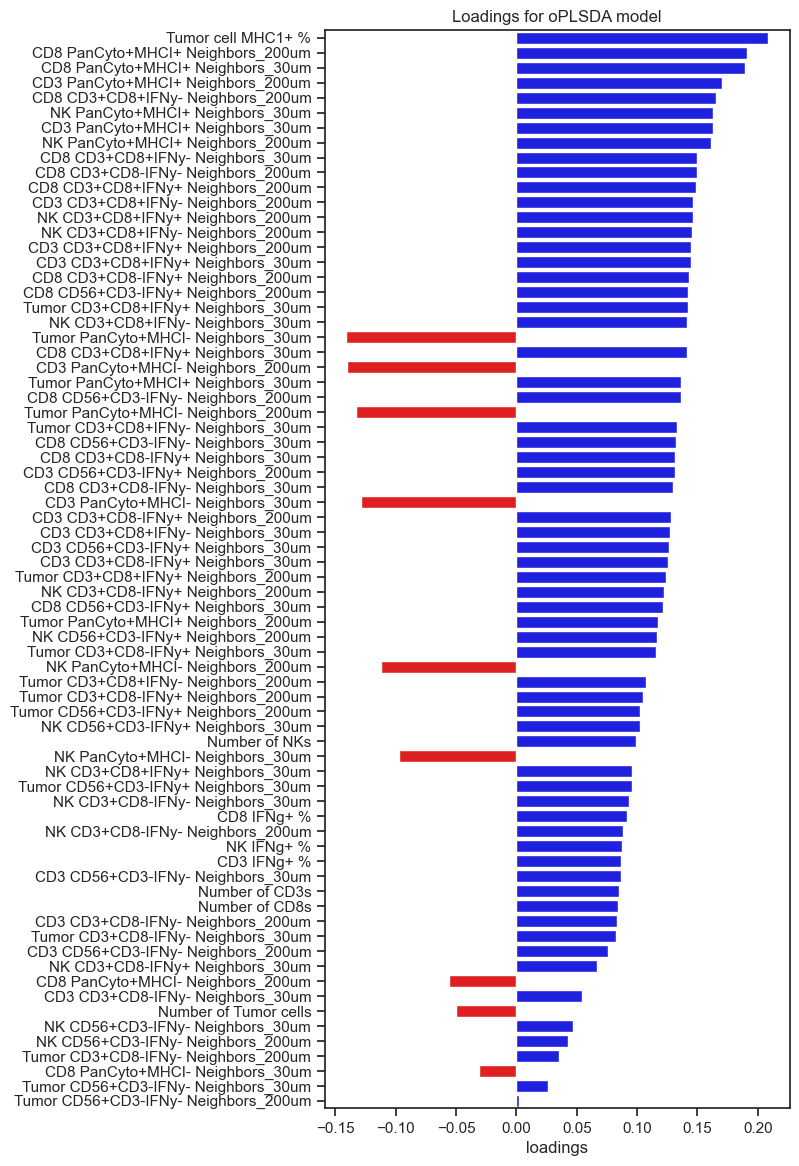

In [80]:
sns.set(font_scale = 1.0)
sns.set_style("ticks")
plt.figure(figsize=(6, 14)) 
x_loadings = pd.DataFrame(pls_model.x_loadings_[:,0].flatten(), index= X.columns, columns = ['loadings'])
x_loadings['color'] = np.where(x_loadings['loadings'] > 0, 'blue', 'red')
colors = {'red': 'red', 'blue': 'blue'}

x_loadings['abs_val'] = abs(x_loadings['loadings'])
x_loadings = x_loadings.sort_values(by = 'abs_val', ascending=False)
sns.barplot(data = x_loadings, x=x_loadings['loadings'],y = x_loadings.index, hue = 'color', palette = colors)
plt.legend().set_visible(False)
plt.ylabel('')
plt.title('Loadings for oPLSDA model')

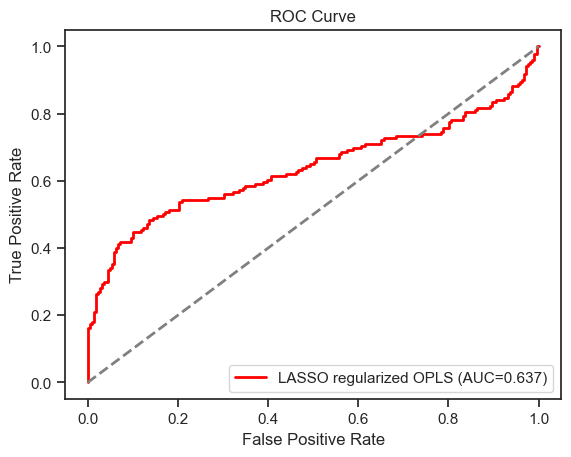

In [82]:
proc_fpr, proc_tpr, proc_thresholds = roc_curve(y, processed_y_pred)
proc_roc_auc = roc_auc_score(y, processed_y_pred)

plt.plot(proc_fpr, proc_tpr, lw=2, color='red',
         label=f'LASSO regularized OPLS (AUC={proc_roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [195]:
results_df

CD8 IFNg+ % Number of CD8s CD3 IFNg+ % Number of CD3s  \
17-199_[43424,7543]          0.0            216         0.0           2596   
17-199_[43424,9043]          0.0            988    0.000227           8808   
17-199_[44446,10543]         0.0           2532    0.000137          14568   
17-199_[44675,12043]         0.0            970         0.0           5818   
17-199_[45431,7543]          0.0            830         0.0           3576   
...                          ...            ...         ...            ...   
17-536_[47032,15356]    0.041237            194    0.008264           1694   
17-536_[47032,16856]    0.014925            134    0.001807           1660   
17-536_[49039,10345]         0.0             58         0.0            315   
17-536_[49039,11845]         0.0             59         0.0            349   
17-536_[49039,13345]    0.083333             12         0.0             74   

                     NK IFNg+ % Number of NKs Tumor cell MHC1+ %  \
17-199_[43424,7543]    0.002899           690                1.0   
17-199_[43424,9043]         0.0          1020                1.0   
17-199_[44446,10543]   0.003209          1870           0.993946   
17-199_[44675,12043]   0.003704           540                1.0   
17-199_[45431,7543]         0.0          2086           0.980519   
...                         ...           ...                ...   
17-536_[47032,15356]   0.076923            39           0.484785   
17-536_[47032,16856]   0.571429            14           0.535714   
17-536_[49039,10345]        0.0            29           0.241717   
17-536_[49039,11845]        0.0            46           0.252163   
17-536_[49039,13345]        0.0            13           0.286613   

                     Number of Tumor cells survival_group patient  ...  \
17-199_[43424,7543]                    540      < 3 years  17-199  ...   
17-199_[43424,9043]                    828      < 3 years  17-199  ...   
17-199_[44446,10543]                  1982      < 3 years  17-199  ...   
17-199_[44675,12043]                   956      < 3 years  17-199  ...   
17-199_[45431,7543]                    308      < 3 years  17-199  ...   
...                                    ...            ...     ...  ...   
17-536_[47032,15356]                  1906      > 3 years  17-536  ...   
17-536_[47032,16856]                  1848      > 3 years  17-536  ...   
17-536_[49039,10345]                  3169      > 3 years  17-536  ...   
17-536_[49039,11845]                  3236      > 3 years  17-536  ...   
17-536_[49039,13345]                  1113      > 3 years  17-536  ...   

                     Tumor CD3+CD8-IFNy- Tumor Neighbors_200um  \
17-199_[43424,7543]                                  13.762963   
17-199_[43424,9043]                                 243.782609   
17-199_[44446,10543]                                439.620585   
17-199_[44675,12043]                                302.443515   
17-199_[45431,7543]                                  14.454545   
...                                                        ...   
17-536_[47032,15356]                                 49.661595   
17-536_[47032,16856]                                 40.002706   
17-536_[49039,10345]                                 16.266646   
17-536_[49039,11845]                                 13.918109   
17-536_[49039,13345]                                   9.59389   

                     Tumor CD3+CD8-IFNy- Stroma Neighbors_200um  \
17-199_[43424,7543]                                   70.896296   
17-199_[43424,9043]                                   358.57971   
17-199_[44446,10543]                                  354.41776   
17-199_[44675,12043]                                  231.74477   
17-199_[45431,7543]                                  146.675325   
...                                                         ...   
17-536_[47032,15356]                                 110.206716   
17-536_[47032,16856]                             

In [196]:
x_loadings[:10]

loadings color   abs_val
Tumor CD3+CD8+IFNy- Tumor Neighbors_200um  0.451385   red  0.451385
Tumor CD3+CD8+IFNy- Tumor Neighbors_30um   0.399999   red  0.399999
Tumor cell MHC1+ %                         0.385608   red  0.385608
Tumor PanCyto+MHCI+ Tumor Neighbors_200um  0.384432   red  0.384432
CD8 CD3+CD8-IFNy- Stroma Neighbors_30um   -0.335051  blue  0.335051
NK CD3+CD8+IFNy- Stroma Neighbors_30um     0.279193   red  0.279193
CD8 CD3+CD8+IFNy- Stroma Neighbors_30um   -0.276710  blue  0.276710
CD8 IFNg+ %                                0.204948   red  0.204948
CD3 PanCyto+MHCI+ Stroma Neighbors_30um   -0.142515  blue  0.142515
NK PanCyto+MHCI- Stroma Neighbors_200um    0.134901   red  0.134901

In [197]:
cols_to_keep = x_loadings[1:5].index
melted_df = results_df.melt(id_vars = ['survival_group','patient'], value_vars= cols_to_keep)
melted_df

survival_group patient                                  variable  \
0         < 3 years  17-199  Tumor CD3+CD8+IFNy- Tumor Neighbors_30um   
1         < 3 years  17-199  Tumor CD3+CD8+IFNy- Tumor Neighbors_30um   
2         < 3 years  17-199  Tumor CD3+CD8+IFNy- Tumor Neighbors_30um   
3         < 3 years  17-199  Tumor CD3+CD8+IFNy- Tumor Neighbors_30um   
4         < 3 years  17-199  Tumor CD3+CD8+IFNy- Tumor Neighbors_30um   
...             ...     ...                                       ...   
1551      > 3 years  17-536   CD8 CD3+CD8-IFNy- Stroma Neighbors_30um   
1552      > 3 years  17-536   CD8 CD3+CD8-IFNy- Stroma Neighbors_30um   
1553      > 3 years  17-536   CD8 CD3+CD8-IFNy- Stroma Neighbors_30um   
1554      > 3 years  17-536   CD8 CD3+CD8-IFNy- Stroma Neighbors_30um   
1555      > 3 years  17-536   CD8 CD3+CD8-IFNy- Stroma Neighbors_30um   

         value  
0     0.266667  
1     1.942029  
2     2.680121  
3     1.845188  
4     0.350649  
...        ...  
1551  6.108247  
1552  8.149254  
1553  0.655172  
1554  0.762712  
1555  0.333333  

[1556 rows x 4 columns]

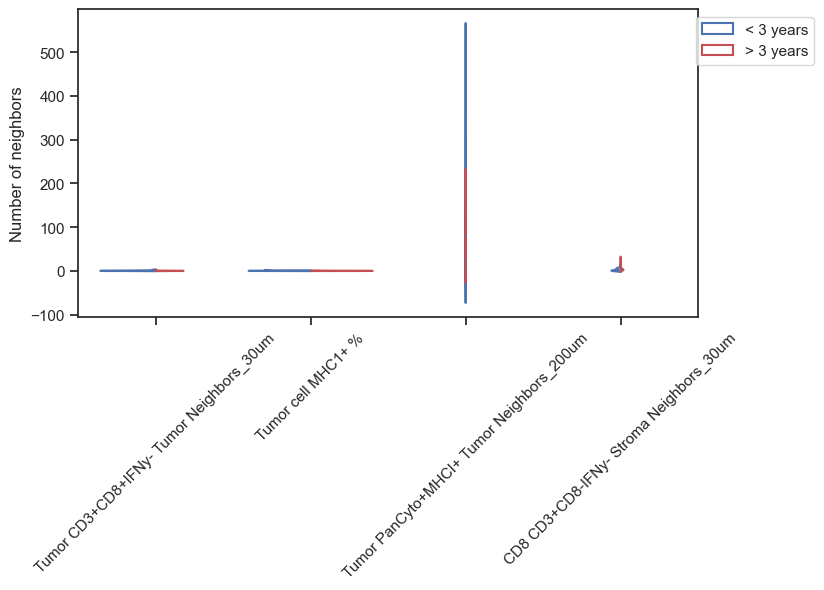

In [198]:
sns.set(font_scale = 1.0)
sns.set_style("ticks")
plt.figure(figsize=(8,4))


# Draw a nested violinplot and split the violins for easier comparison
g= sns.violinplot(data=melted_df, x = 'variable', y = 'value', hue="survival_group",
               split=True, inner="quart", fill=False,
               palette={"> 3 years": "r", "< 3 years": "b"})
plt.legend(bbox_to_anchor=(1.2, 1))
plt.xticks(rotation=45)
plt.xlabel('')
plt.ylabel('Number of neighbors')
plt.show()

In [203]:
x_loadings.index[2]

'Tumor cell MHC1+ %'

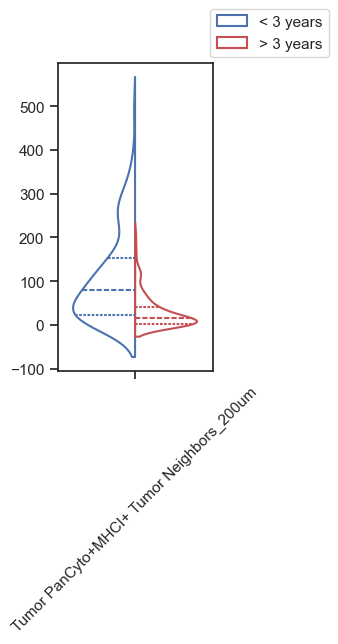

In [208]:
cols_to_keep = x_loadings.index[3]
melted_df = results_df.melt(id_vars = ['survival_group','patient'], value_vars= cols_to_keep)
sns.set(font_scale = 1.0)
sns.set_style("ticks")
plt.figure(figsize=(2,4))


# Draw a nested violinplot and split the violins for easier comparison
g= sns.violinplot(data=melted_df, x = 'variable', y = 'value', hue="survival_group",
               split=True, inner="quart", fill=False,
               palette={"< 3 years": "b", "> 3 years": "r"})
plt.legend(bbox_to_anchor=(1.8, 1.2))
plt.xticks(rotation=45)
plt.xlabel('')
plt.ylabel('')
plt.show()

## with LASSO

In [186]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold

from scipy.stats import zscore 



X = results_df.iloc[:,:90]
X = X.drop(columns=['survival_group', 'patient'])
y_str = results_df['survival_group']
y = y_str.apply(lambda x: 1 if x == 'short' else -1)
X = X.fillna(0)
X = stats.zscore(X)

#z_score_x = zscore(X.astype(float), axis = 1, ddof=1)

# parameters to be tested on GridSearchCV


# Number of Folds and adding the random state for replication

# Initializing the Model
lassocv = LassoCV(alphas=[1E-5, 1E-4, 1E-3, 1E-2, 1E-1, 1],cv = 10)


# GridSearchCV with model, params and folds.
lassocv.fit(X,y)
lasso_feat = lassocv.coef_
selected_features = np.array(X.columns)[lasso_feat != 0]
lasso_selected_x = X.loc[:,X.columns.isin(selected_features)]


/home/gh8sj/.conda/envs/spy_cell/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.3004450509457115, tolerance: 0.03258171428571432
  model = cd_fast.enet_coordinate_descent_gram(
/home/gh8sj/.conda/envs/spy_cell/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.112907125822275, tolerance: 0.03258171428571432
  model = cd_fast.enet_coordinate_descent_gram(
/home/gh8sj/.conda/envs/spy_cell/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54.74094019988947, tolerance: 0.03258171428571432
  model = cd_fast.enet_coordinate_descent_gram(
/home/gh8sj/.conda/envs/spy_c

In [187]:
print(lassocv.alpha_, sum(x != 0 for x in lassocv.coef_))

0.001 64


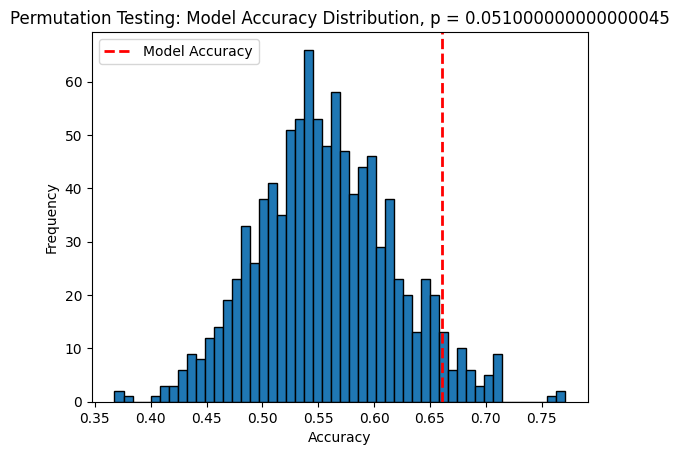

In [188]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import bisect

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from pyopls import OPLS
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict, LeaveOneOut
from sklearn.metrics import r2_score, accuracy_score


def count_values_greater_than(sorted_list, target_value):
    # Use bisect_right to find the index of the first element greater than the target_value
    index = bisect.bisect_right(sorted_list, target_value)
    
    # The count of values greater than the target_value is the length of the list minus the index
    count = len(sorted_list) - index
    
    return count

def round_to_sign(value):
    if value >= 0:
        return np.ceil(value)
    else:
        return np.floor(value)



X = results_df.iloc[:,:90]
X = X.drop(columns=['survival_group', 'patient'])
X = X.fillna(0)
X = stats.zscore(X)
X = X.loc[:,X.columns.isin(selected_features)]
y_str = results_df['survival_group']
y = y_str.apply(lambda x: 1 if x == 'short' else -1)







# do you orthogoranlize all the permutations? -> yes



# Generate some example data
np.random.seed(42)

# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
opls = OPLS(2) # 1 components
Z = opls.fit_transform(X, y)
pls_model = PLSRegression(2)


pls_model.fit(Z, y)
#y_pred= pls.predict(X)
processed_y_pred = cross_val_predict(pls_model, Z, y, cv=5)

                           
processed_q_squared = r2_score(y, processed_y_pred) 
processed_dq_squared = r2_score(y, np.clip(processed_y_pred, -1, 1))  # 0.984
processed_accuracy = accuracy_score(y, np.sign(processed_y_pred))  # 1.0
processed_accuracy_rounded = round(processed_accuracy,2)

variance_in_x = np.var(pls_model.x_scores_, axis = 0) 
total_variance_in_x = np.var(Z, axis = 0)
# normalize variance by total variance:
#fractions_of_explained_variance = variance_in_x / total_variance_in_x

r2_X = opls.score(X)  # 7.8e-12 (most variance is removed)


# Number of permutations
num_permutations = 1000

# List to store permutation accuracies
permuted_accuracies = []

# Permutation testing loop
for _ in range(num_permutations):
    # Randomly permute the labels
    permuted_labels = np.random.permutation(y)
    
    
#processed_y_pred = cross_val_predict(pls, Z, y, cv=1000)
#processed_q_squared = r2_score(y, processed_y_pred)  # 0.981
#processed_dq_squared = r2_score(y, np.clip(processed_y_pred, -1, 1))  # 0.984
#processed_accuracy = accuracy_score(y, np.sign(processed_y_pred))  # 1.0
    opls = OPLS(2) # 1 components
    Z_i = opls.fit_transform(X, permuted_labels)

    #permuted_model.fit(X, permuted_labels)
    pls = PLSRegression(1)
    permuted_pred = cross_val_predict(pls, Z_i, permuted_labels, cv=5) # I should change this to something smaller, leave one out would literally take foever
    # Make predictions with the permuted model
    #permuted_predictions = permuted_model.predict(X)
    
    # Calculate accuracy and store in the list
    permuted_pred = [round_to_sign(value) for value in permuted_pred]# Round each value in the list based on the specified rules


    permuted_accuracy = accuracy_score(y, permuted_pred)
    permuted_accuracies.append(permuted_accuracy)

    
permuted_accuracies = pd.Series(np.sort(permuted_accuracies), index = range(1000))
result_count = count_values_greater_than(permuted_accuracies, processed_accuracy)
p = 1-(1000-result_count)/1000
p_round = round(p,3)

# Plotting the histogram
plt.hist(permuted_accuracies, bins=50, edgecolor='black')
plt.axvline(x=processed_accuracy, color='red', linestyle='dashed', linewidth=2, label='Model Accuracy')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title(f'Permutation Testing: Model Accuracy Distribution, p = {p}')
plt.legend()
plt.show()

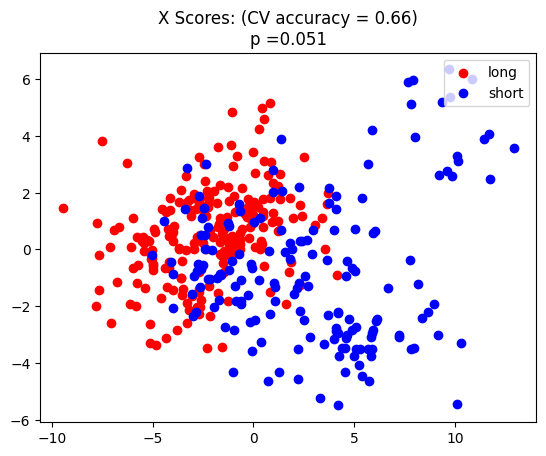

In [189]:
#plt.figure(1)
#df = pd.DataFrame(np.column_stack([pls_model.x_scores_, opls.T_ortho_[:, 0]]),
#                  index=y.index, columns=['t', 't_ortho'])                
df = pd.DataFrame(np.column_stack([pls_model.x_scores_]),
                  index=y.index, columns=['lv1', 'lv2'])       
pos_df = df[y==1]
neg_df = df[y==-1]
plt.scatter(neg_df['lv1'], neg_df['lv2'], c='red', label='long')
plt.scatter(pos_df['lv1'], pos_df['lv2'], c='blue', label='short')
plt.title(f'X Scores: (CV accuracy = {processed_accuracy_rounded})\np ={p_round}')
#plt.xlabel(f'PC1 X_var explained = {round(np.var(df.iloc[:,0])/sum(np.var(df.iloc[:,:], axis = None)), 3)}')
#plt.ylabel(f'PC2 X_var explained = {round(np.var(df.iloc[:,1])/sum(np.var(df.iloc[:,:], axis = None)), 3)}')
plt.legend(loc='upper right')
plt.show()

Text(0.5, 1.0, 'Loadings for oPLSDA model')

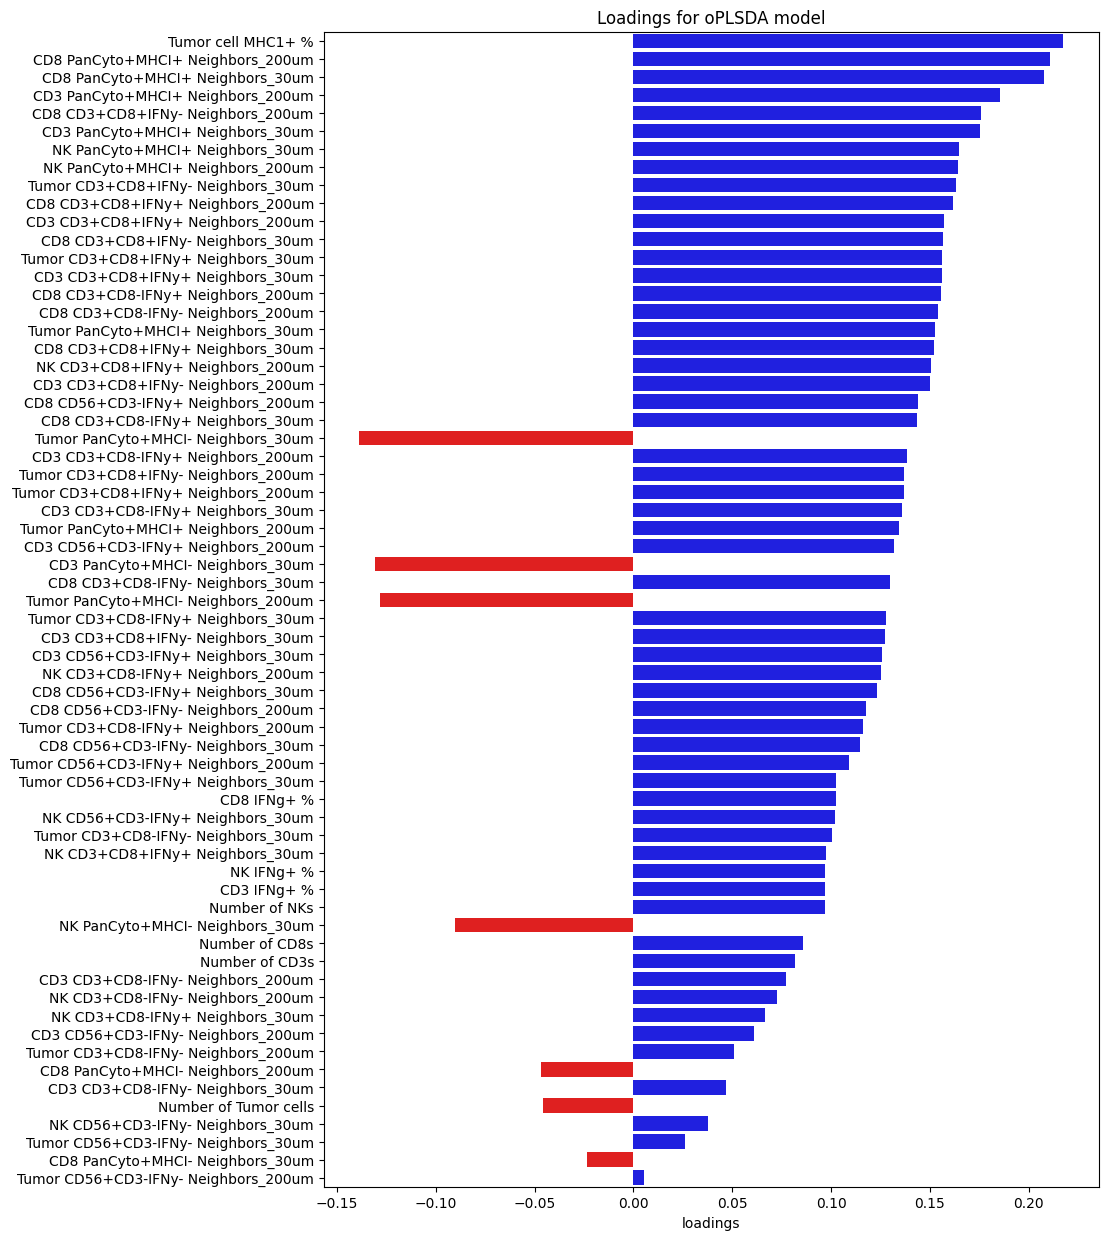

In [190]:
plt.figure(figsize=(10, 15)) 
x_loadings = pd.DataFrame(pls_model.x_loadings_[:,0].flatten(), index= X.columns, columns = ['loadings'])
x_loadings['color'] = np.where(x_loadings['loadings'] > 0, 'blue', 'red')
colors = {'red': 'red', 'blue': 'blue'}

x_loadings['abs_val'] = abs(x_loadings['loadings'])
x_loadings = x_loadings.sort_values(by = 'abs_val', ascending=False)
sns.barplot(data = x_loadings, x=x_loadings['loadings'],y = x_loadings.index, hue = 'color', palette = colors)
plt.legend().set_visible(False)
plt.ylabel('')
plt.title('Loadings for oPLSDA model')

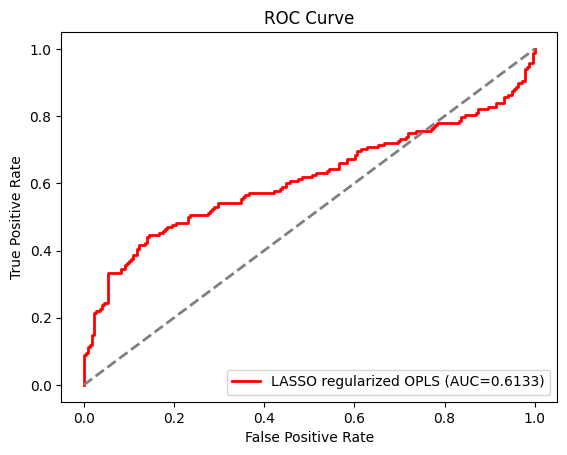

In [191]:
proc_fpr, proc_tpr, proc_thresholds = roc_curve(y, processed_y_pred)
proc_roc_auc = roc_auc_score(y, processed_y_pred)

plt.plot(proc_fpr, proc_tpr, lw=2, color='red',
         label=f'LASSO regularized OPLS (AUC={proc_roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# this worked really well when I switched to using a log1p transform on the neighbor data